In [1]:
import pandas as pd

import numpy as np



In [2]:
'''
1) Load Covid Actual Tally Data, smoothen it and generate ground truth labels and confirm the visualizations

2) Load Model Data for Cases and using N-1 actual covid and 4 weeks predictions and assign desired week number inline to actual covid tally numbers and use shapelets pearson correlaiton to generate labels

3) Use Cross Entropy Logloss method to evaulate labels and generate summary 

4) Repeat for Deaths

'''

'\n1) Load Covid Actual Tally Data, smoothen it and generate ground truth labels and confirm the visualizations\n\n2) Load Model Data for Cases and using N-1 actual covid and 4 weeks predictions and assign desired week number inline to actual covid tally numbers and use shapelets pearson correlaiton to generate labels\n\n3) Use Cross Entropy Logloss method to evaulate labels and generate summary \n\n4) Repeat for Deaths\n\n'

In [3]:
state_population = pd.read_csv("../Data/US State Population.csv")

state_population.dtypes

population_dictionary = state_population.set_index("State").to_dict()["Population"]

In [4]:
cases_tmp = pd.read_csv("../Data/Deaths/us_deaths.csv")


In [5]:
US_total = pd.DataFrame(cases_tmp.sum(axis=0))

cases = pd.concat([cases_tmp,US_total.T])

impute = {}

impute['Country'] = {'WashingtonIllinoisCaliforniaArizonaMassachusettsWisconsinTexasNebraskaUtahOregonFloridaNew YorkRhode IslandGeorgiaNew HampshireNorth CarolinaNew JerseyColoradoMarylandNevadaTennesseeHawaiiIndianaKentuckyMinnesotaOklahomaPennsylvaniaSouth CarolinaDistrict of ColumbiaKansasMissouriVermontVirginiaConnecticutIowaLouisianaOhioMichiganSouth DakotaArkansasDelawareMississippiNew MexicoNorth DakotaWyomingAlaskaMaineAlabamaIdahoMontanaPuerto RicoVirgin IslandsGuamWest VirginiaNorthern Mariana IslandsAmerican Samoa':"United States"}

cases = cases.replace(impute)


In [6]:
from datetime import datetime, timedelta

N = 157
t = 'Jan 22 2020'
format = '%b %d %Y'
now = datetime.strptime(t,format)
after = now + timedelta(days = N)
print(now)
print(after)

cases_for_use = cases.iloc[:,157:]
start = 157

days = [i for i in range(start,start+cases_for_use.shape[1])]


2020-01-22 00:00:00
2020-06-27 00:00:00


In [7]:
cases_for_use.columns = days


In [8]:
weekly_cases = pd.DataFrame()
for i in range(start, start+cases_for_use.shape[1],7):
    weekly_cases = pd.concat([weekly_cases,cases_for_use[i]],axis=1)


In [9]:
weekly_cases_2 = weekly_cases.copy()

# for i in range(1,weekly_cases_2.shape[1]):
#     weekly_cases_2.iloc[:,-i] = weekly_cases_2.iloc[:,-i] - weekly_cases_2.iloc[:,-i-1]


In [10]:
weekly_cases_2 = weekly_cases.diff(axis=1)

In [11]:
weekly_cases_2[weekly_cases_2<0] = 0


In [12]:





weekly_cases1 = weekly_cases_2[list(weekly_cases_2.columns)[1:]]


weekly_cases1.index = list(cases['Country'].values)

states_list = list(cases['Country'].values)

Actual_covid_tally = weekly_cases1.copy()
# 2020-6-28 is a Sunday

In [13]:

# from datetime import datetime, timedelta

# N = 164
# t = 'Jan 22 2020'
# format = '%b %d %Y'
# now = datetime.strptime(t,format)
# after = now + timedelta(days = N)
# print(now)
# print(after)
# cases_for_use = cases.iloc[:,after:]
# start = 154

# days = [i for i in range(start,start+cases_for_use.shape[1])]


# cases_for_use.columns = days

# weekly_cases = pd.DataFrame()
# for i in range(start, start+cases_for_use.shape[1],7):
#     weekly_cases = pd.concat([weekly_cases,cases_for_use[i]],axis=1)

# for i in range(1,weekly_cases.shape[1]):
#     weekly_cases.iloc[:,-i] = weekly_cases.iloc[:,-i] - weekly_cases.iloc[:,-i-1]

# weekly_cases[weekly_cases<0] = 0

# weekly_cases1 = weekly_cases.iloc[:,1:]

# weekly_cases1.index = list(cases['Country'].values)

# states_list = list(cases['Country'].values)

# Actual_covid_tally = weekly_cases1.copy()
# # 2020-6-28 is a Sunday

In [14]:
JHU_actual_pd = Actual_covid_tally.copy()

data_array = JHU_actual_pd.values

week_numbers = JHU_actual_pd.columns

In [15]:
pd.set_option('display.max_columns', None)
#JHU_actual_pd

In [16]:
Actual_covid_tally_dict = Actual_covid_tally.T.to_dict()

In [17]:
#### Using a sliding window, compute the runnning averages of fixed window sizes


state_wise_running_averages = []

for state in range(len(states_list)):
    vector = data_array[state]
    running_average = [0]*len(vector)
    
    for k in range(len(vector)):
        #print(k)
        if k==0:
#             print(k)
#             print(vector[k:k+2])
            running_average[k]=sum(vector[k:k+2])/2
            
        elif k>0 and k < len(vector)-1:
            running_average[k] = sum(vector[k-1:k+2])/3
        elif k==len(vector)-1:
#             print(k)
            running_average[k] = sum(vector[k-1:k+1])/2
#             print(vector[k-1:k+1])
    state_wise_running_averages.append(running_average)
    
        
running_average={}
for state in range(len(states_list)):
    
    running_average[states_list[state]] = list(zip(week_numbers,state_wise_running_averages[state]))    


In [18]:
# ##### 
# {'Washington': [(136, 5071.5),
#   (143, 5307.666666666667),
#   (150, 5844.666666666667),
#   (157, 5544.666666666667),
#   (164, 5140.666666666667),


## Generating Shapelets for Actual Covid tally

In [19]:
from numpy import corrcoef as pcor

from numpy import exp as exp

flat = [1.0, 1.00000001, 1.00000002, 1.00000003, 1.00000004]
stable_inc = [1 ,2, 3, 4, 5]#, i.e., linear
stable_dec = [5, 4, 3 ,2, 1]#, i.e., linear but decreasing
surge =[exp(-1/2), exp(0/2), exp(1/2), exp(2/2), exp(3/2)]#, i.e., like exp(x)
peaking = [-1*w for w in [exp(1/2) ,exp(0/2), exp(-1/2), exp(-2/2), exp(-3/2)]]#, i.e., like -exp(-x)
at_near_peak=  [-1*w for w in [exp(-1/2) ,exp(0/2) ,exp(1/2) ,exp(2/2), exp(3/2)]]#, i.e., like -exp(x)

In [20]:
from itertools import combinations

In [21]:

shapelet_Combinatinos = list(combinations([flat,stable_inc,stable_dec,surge,peaking,at_near_peak],2))

shapelet_Combinatinos_names = list(combinations(["flat","stable_inc","stable_dec","surge","peaking","at_near_peak"],2))


In [22]:
from scipy import spatial

pairwise_dissimilairty = {}
for i in range(len(shapelet_Combinatinos_names)):
    vector1 = shapelet_Combinatinos[i][0]
    vector2 = shapelet_Combinatinos[i][1]
    pairwise_dissimilairty[shapelet_Combinatinos_names[i]]  = spatial.distance.cosine(vector1,vector2)
    
    

In [23]:
overall_sum = sum(pairwise_dissimilairty.values())
for k,v in pairwise_dissimilairty.items():
    pairwise_dissimilairty[k] = v/overall_sum
    

In [24]:

import pickle

with open('Pickle_objects/ShapeLet_loss_weight_deaths.pickle', 'wb') as handle:
    pickle.dump(pairwise_dissimilairty, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
def return_best_shapelet_pearson(vector):
    f1 = pcor(vector,flat)[0][1]
    f2 = pcor(vector,stable_inc)[0][1]
    f3 = pcor(vector,stable_dec)[0][1]
    f4 = pcor(vector,surge)[0][1]
    f5 = pcor(vector,peaking)[0][1]
    f6 = pcor(vector,at_near_peak)[0][1]
    corrs = [f1,f2,f3,f4,f5,f6]
    scenario = corrs.index(max(corrs))
    scenario+=1
    if scenario ==1:
        return "Flat"
    elif scenario==2:
        return "Inc"
    elif scenario==3:
        return 'Dec'
    elif scenario==4:
        return "Surge"
    elif scenario==5:
        return 'Peaking'
    else:
        return "Near Peak"


In [26]:
def return_all_shapelet_pearson(vector):
    f1 = pcor(vector,flat)[0][1]
    f2 = pcor(vector,stable_inc)[0][1]
    f3 = pcor(vector,stable_dec)[0][1]
    f4 = pcor(vector,surge)[0][1]
    f5 = pcor(vector,peaking)[0][1]
    f6 = pcor(vector,at_near_peak)[0][1]
    corrs = [f1,f2,f3,f4,f5,f6]
    return corrs
#     scenario = corrs.index(max(corrs))
#     scenario+=1
#     if scenario ==1:
#         return "Flat"
#     elif scenario==2:
#         return "Inc"
#     elif scenario==3:
#         return 'Dec'
#     elif scenario==4:
#         return "Surge"
#     elif scenario==5:
#         return 'Peaking'
#     else:
#         return "Near Peak"


In [ ]:
### Lets Generate for each week/ state, running vectors of size 5

Washington
Illinois
California
Arizona
Massachusetts
Wisconsin
Texas
Nebraska
Utah
Oregon
Florida
New York
Rhode Island
Georgia
New Hampshire
North Carolina
New Jersey
Colorado
Maryland
Nevada
Tennessee


<ipython-input-27-13ee79411f1f>:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(24,8 ), dpi=80)


Hawaii
Indiana
Kentucky
Minnesota
Oklahoma
Pennsylvania
South Carolina
District of Columbia
Kansas
Missouri
Vermont


/Users/satwant/Documents/Anaconda3/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/satwant/Documents/Anaconda3/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Virginia
Connecticut
Iowa
Louisiana
Ohio
Michigan
South Dakota
Arkansas
Delaware
Mississippi
New Mexico
North Dakota
Wyoming
Alaska
Maine
Alabama
Idaho
Montana
Puerto Rico
Virgin Islands
Guam
West Virginia
Northern Mariana Islands
American Samoa
United States


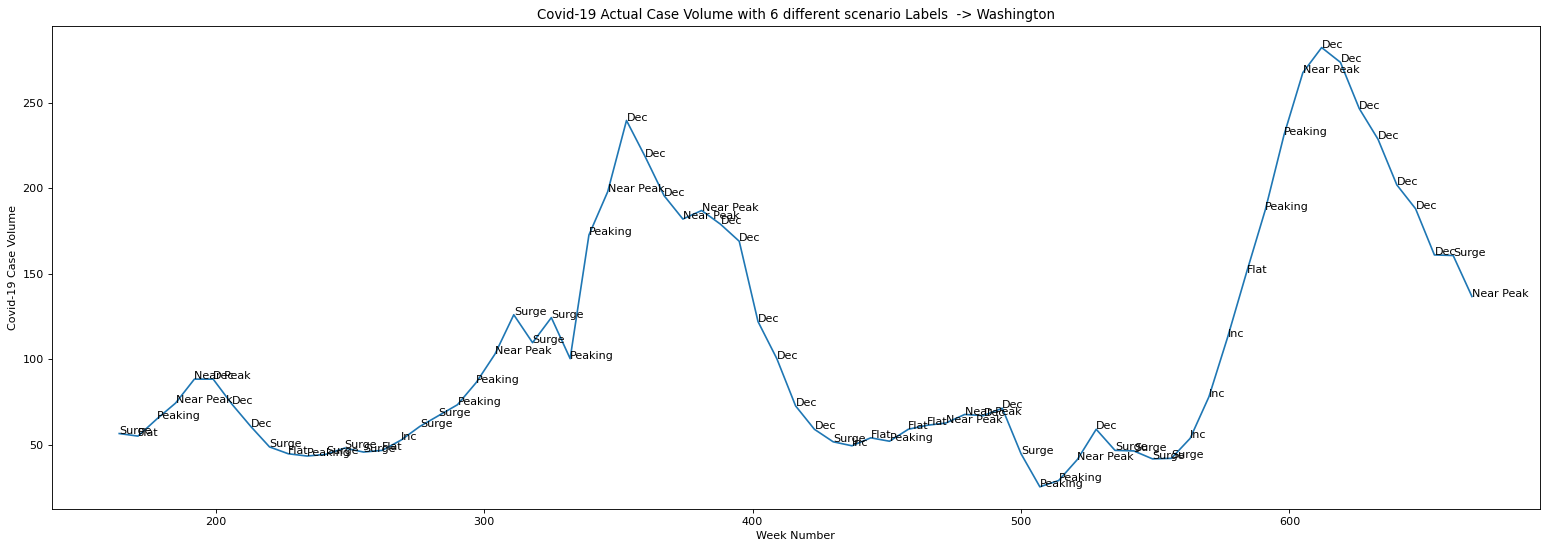

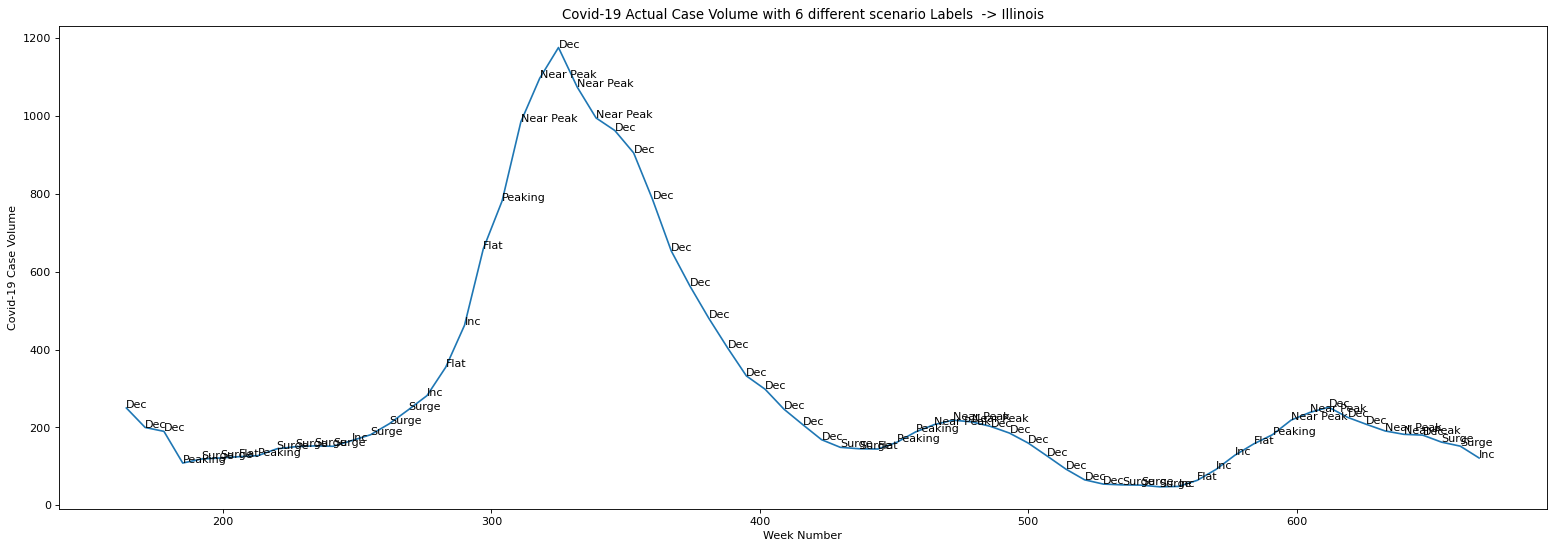

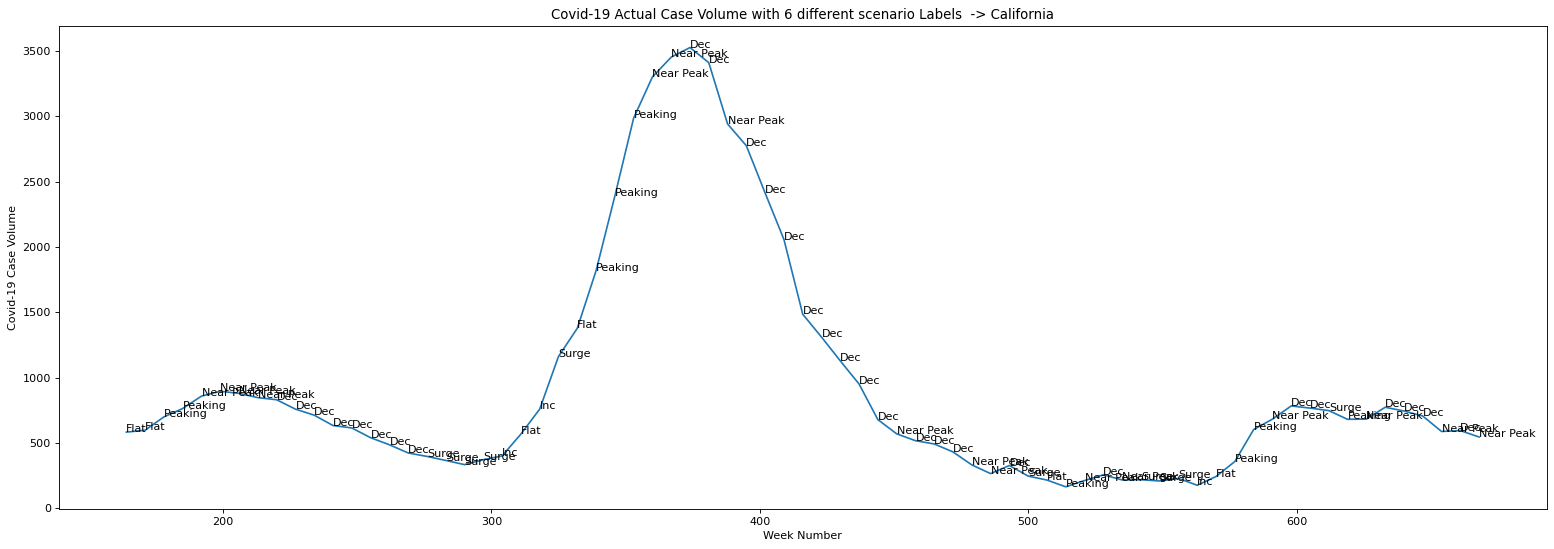

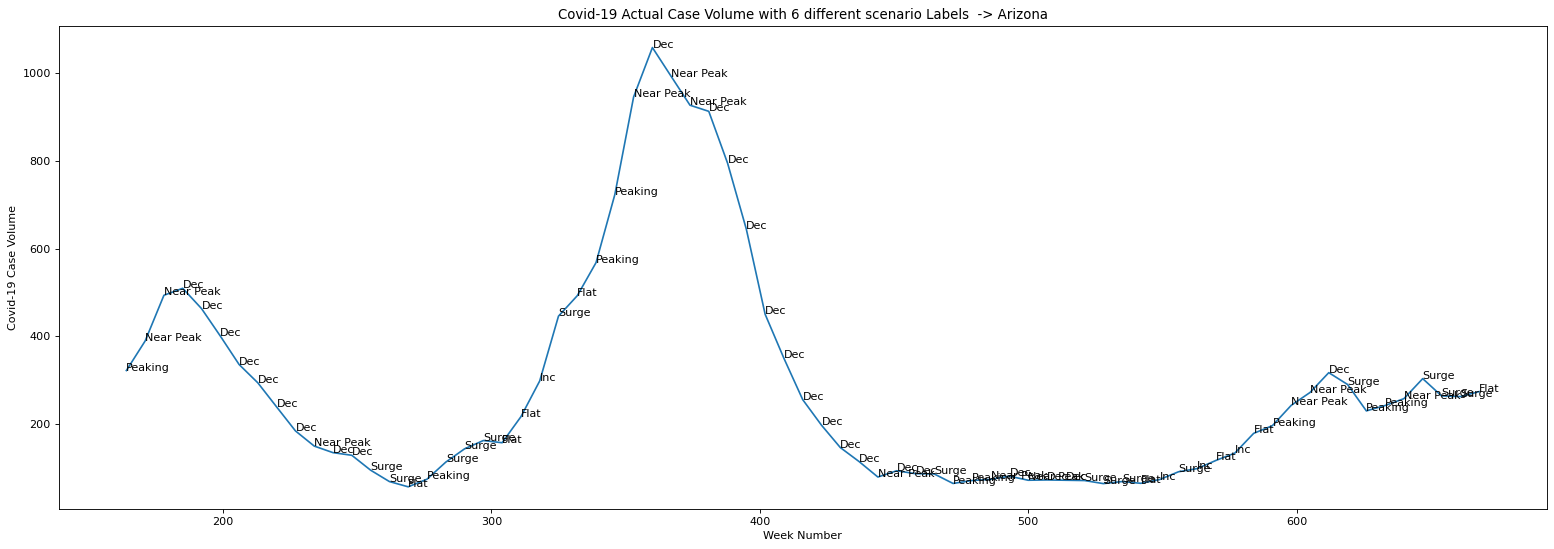

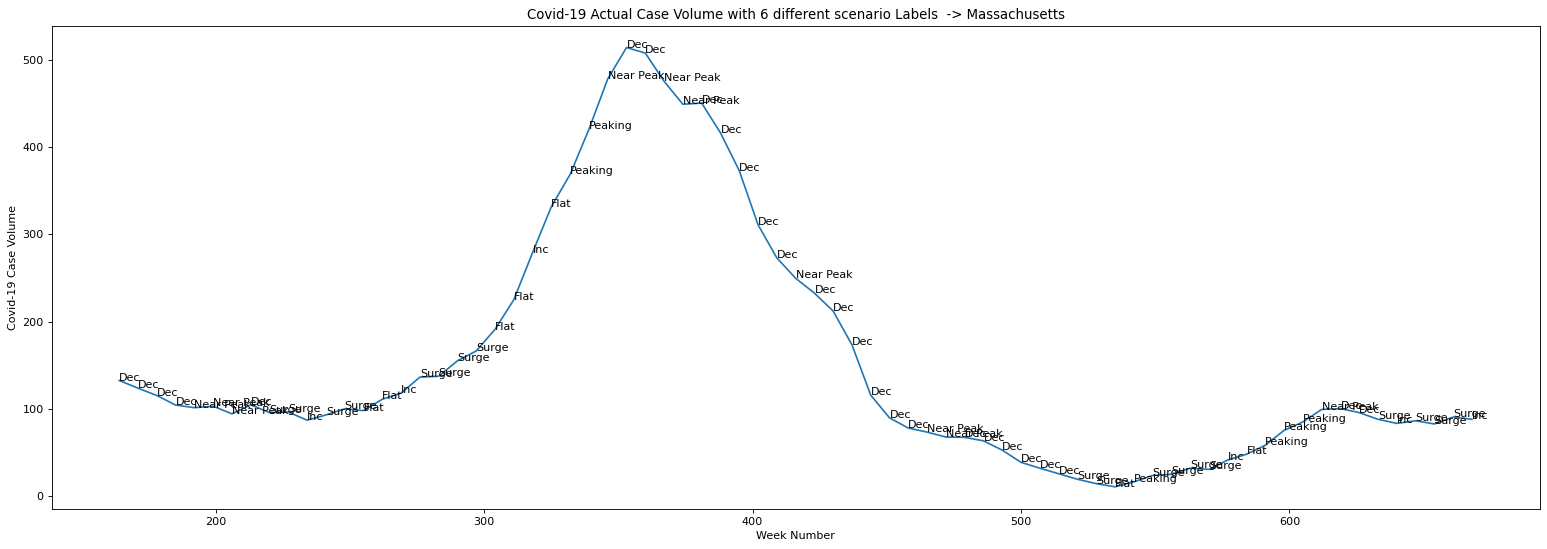

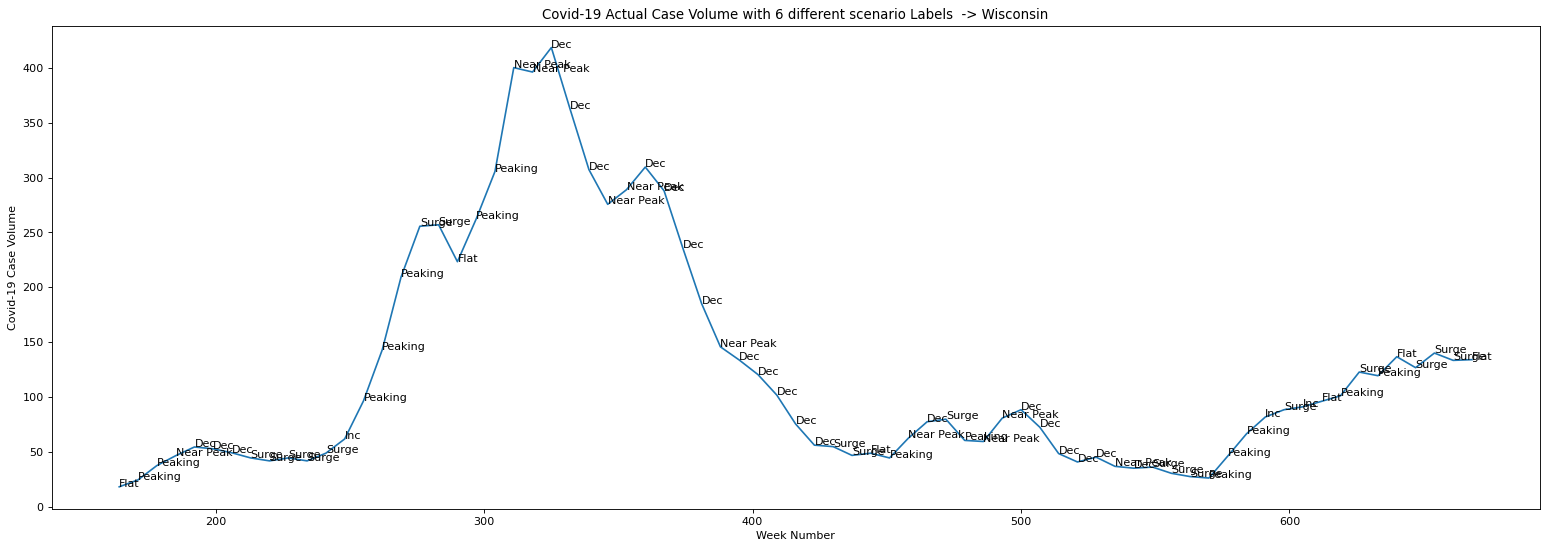

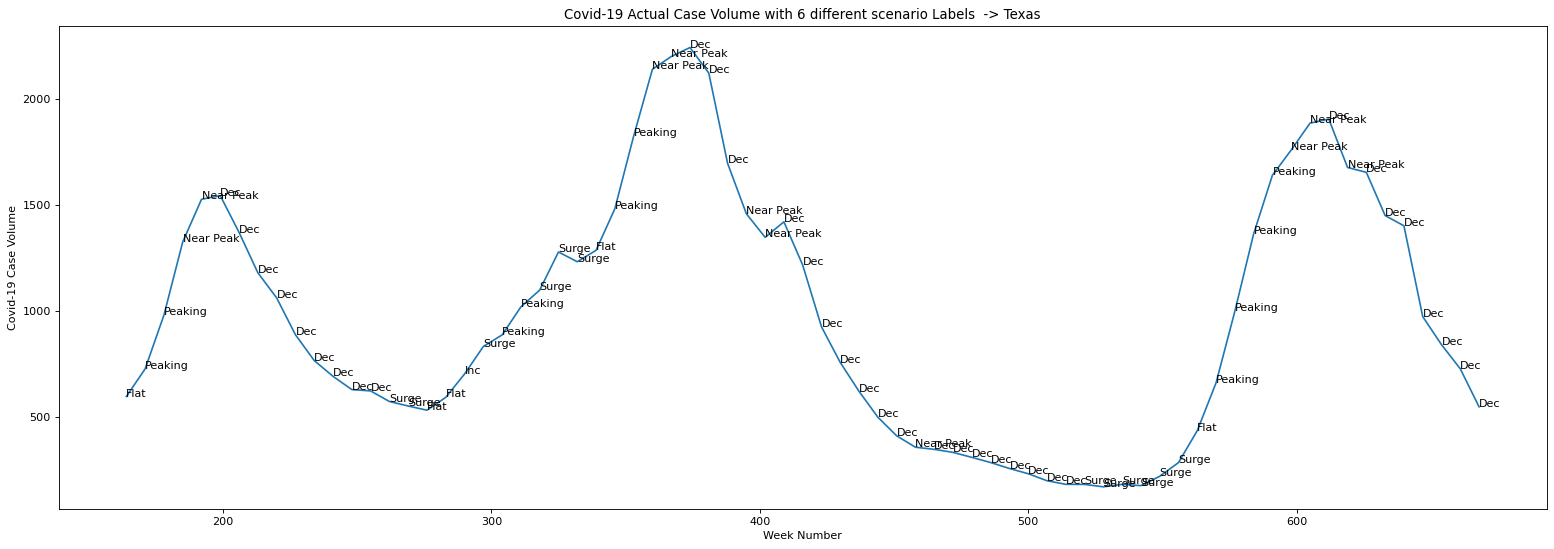

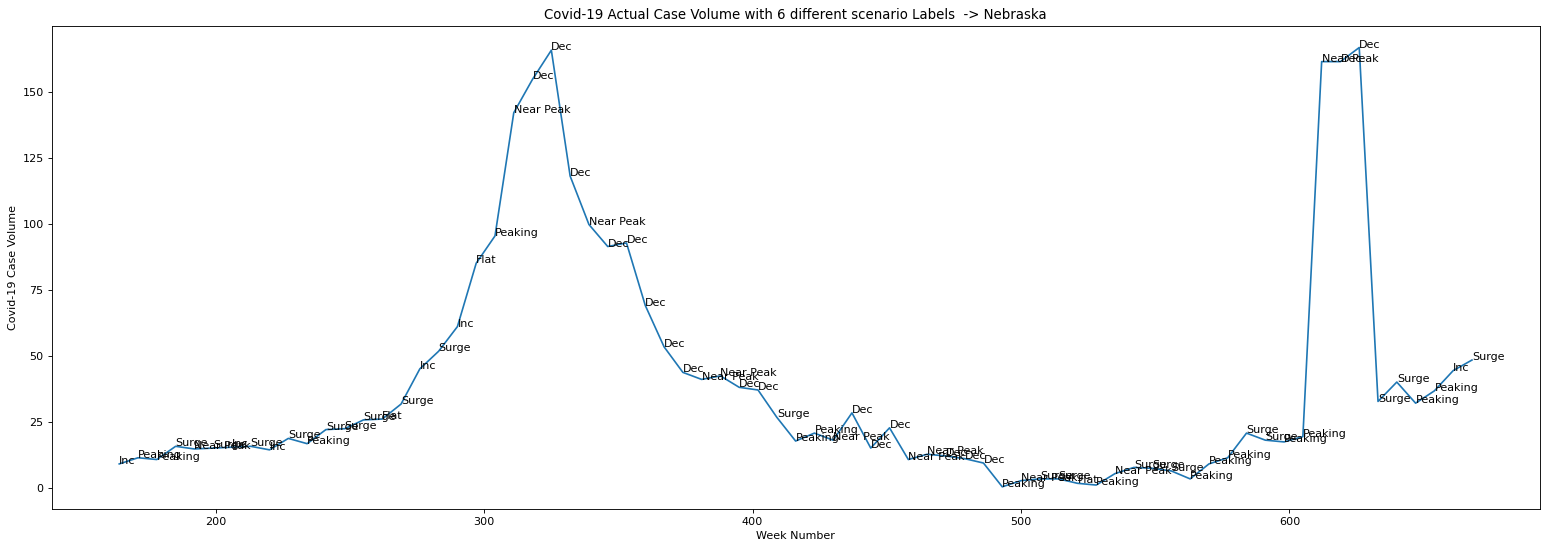

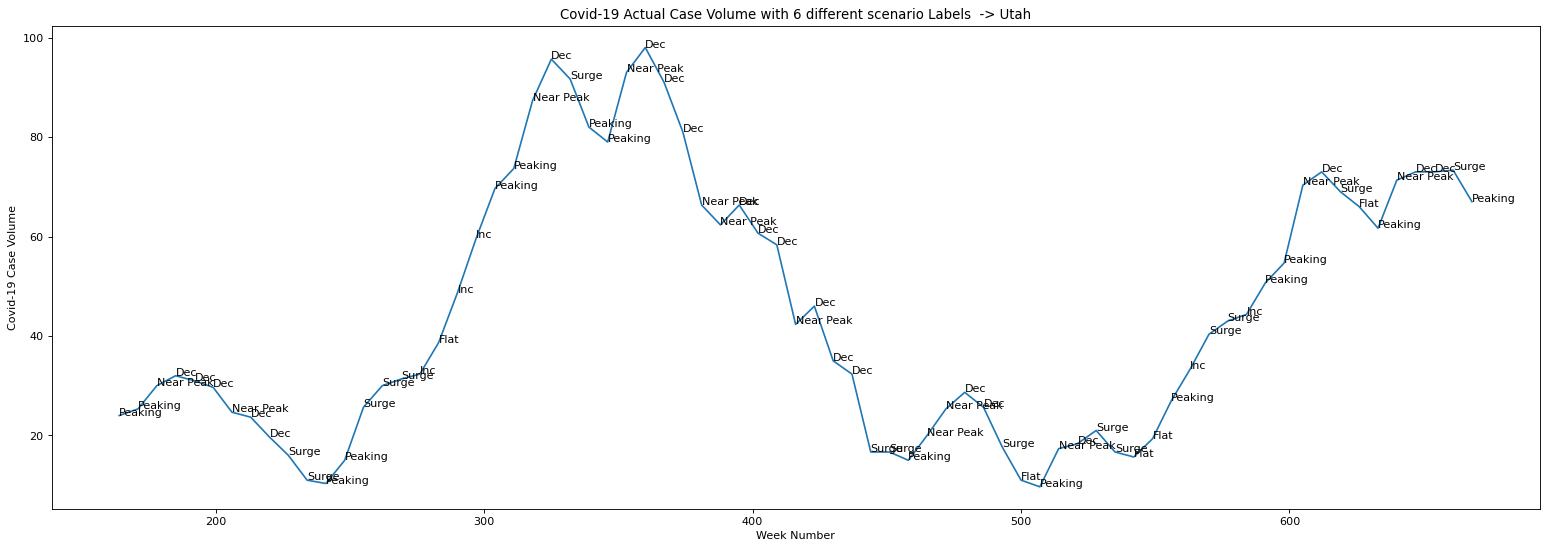

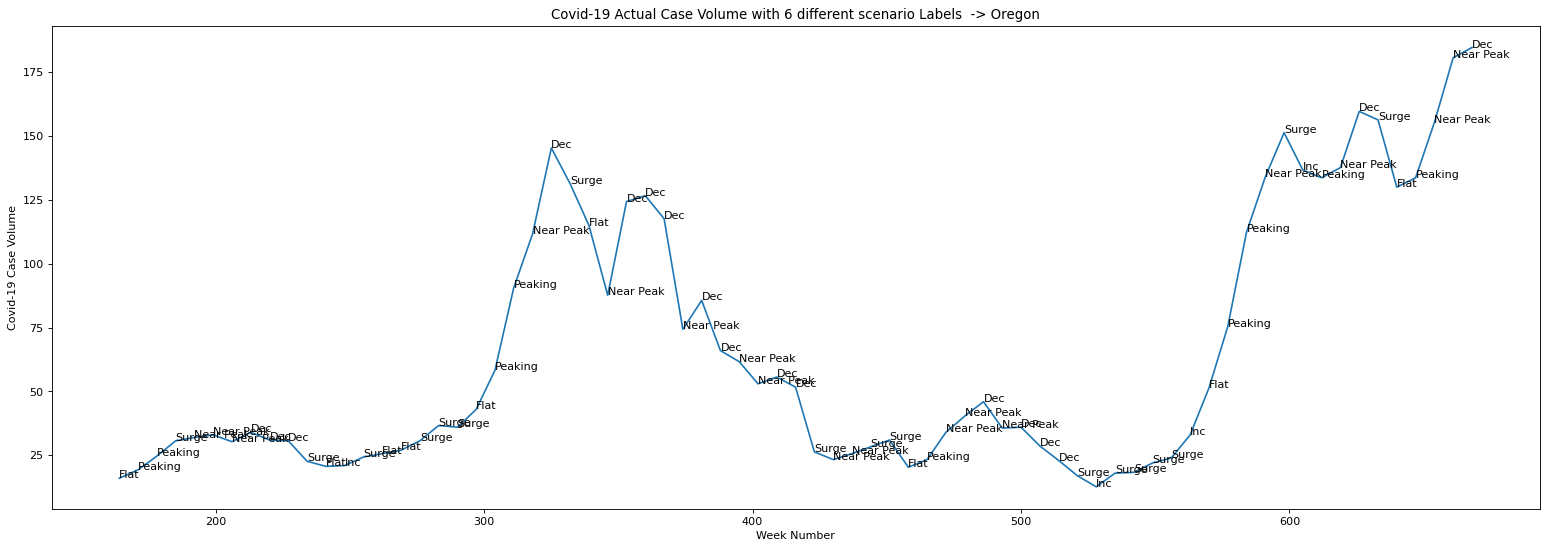

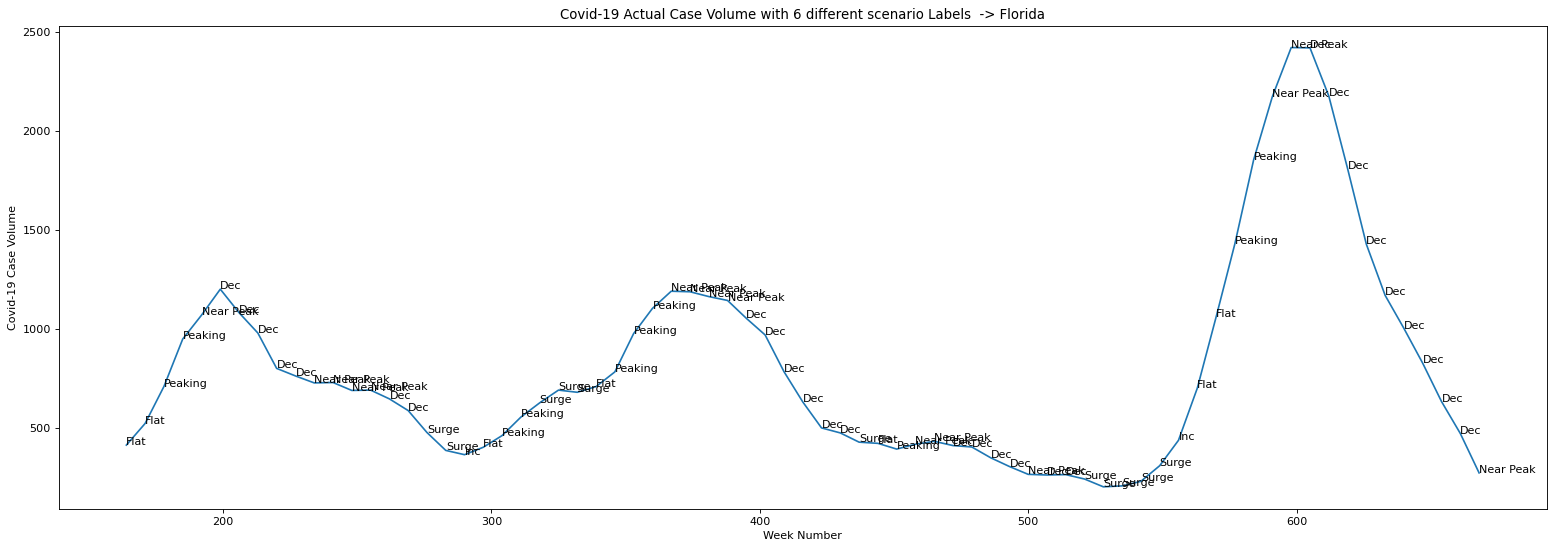

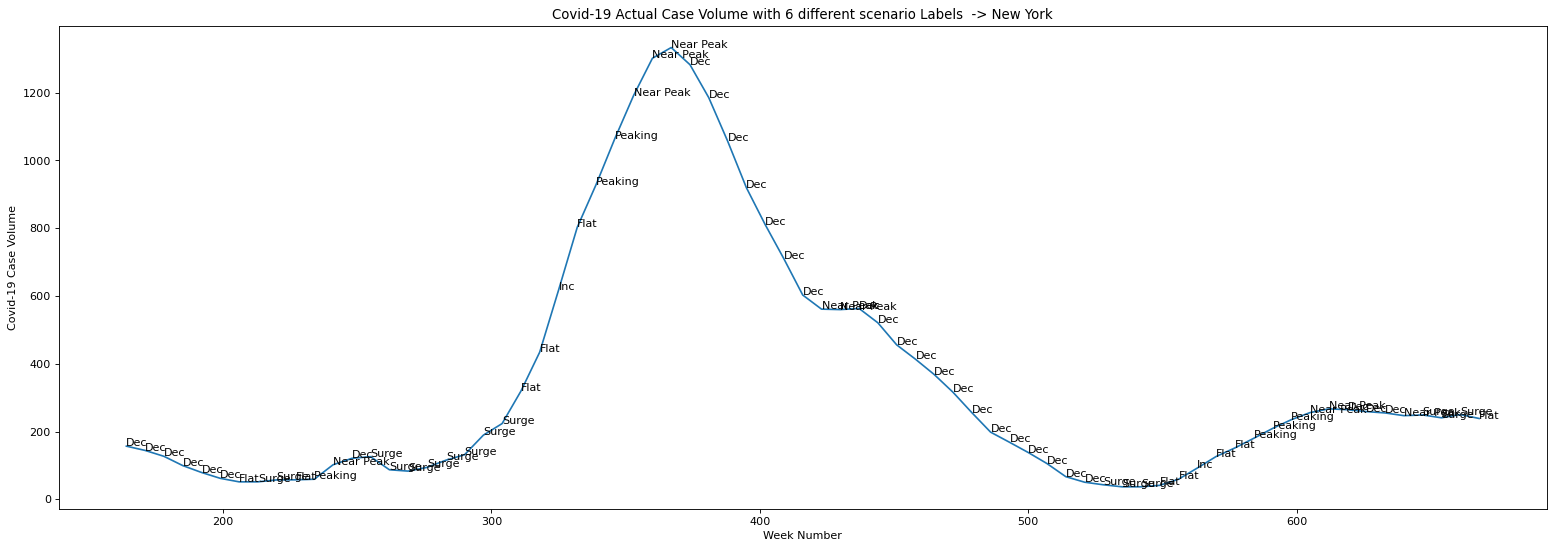

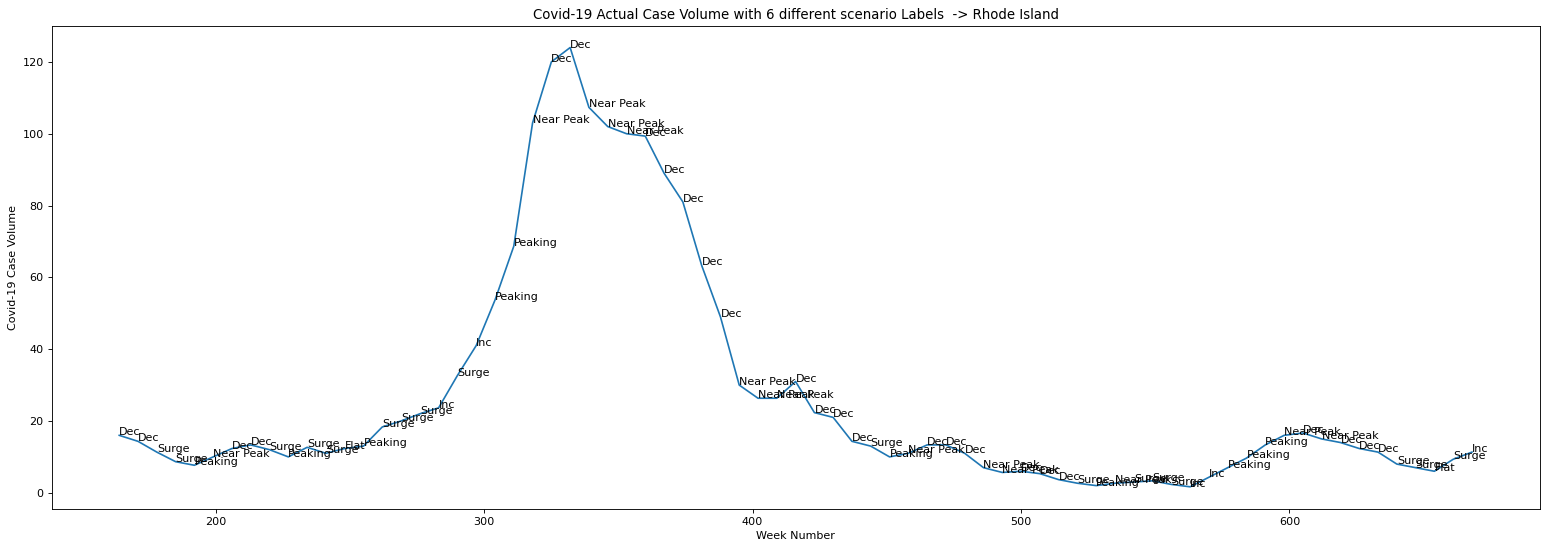

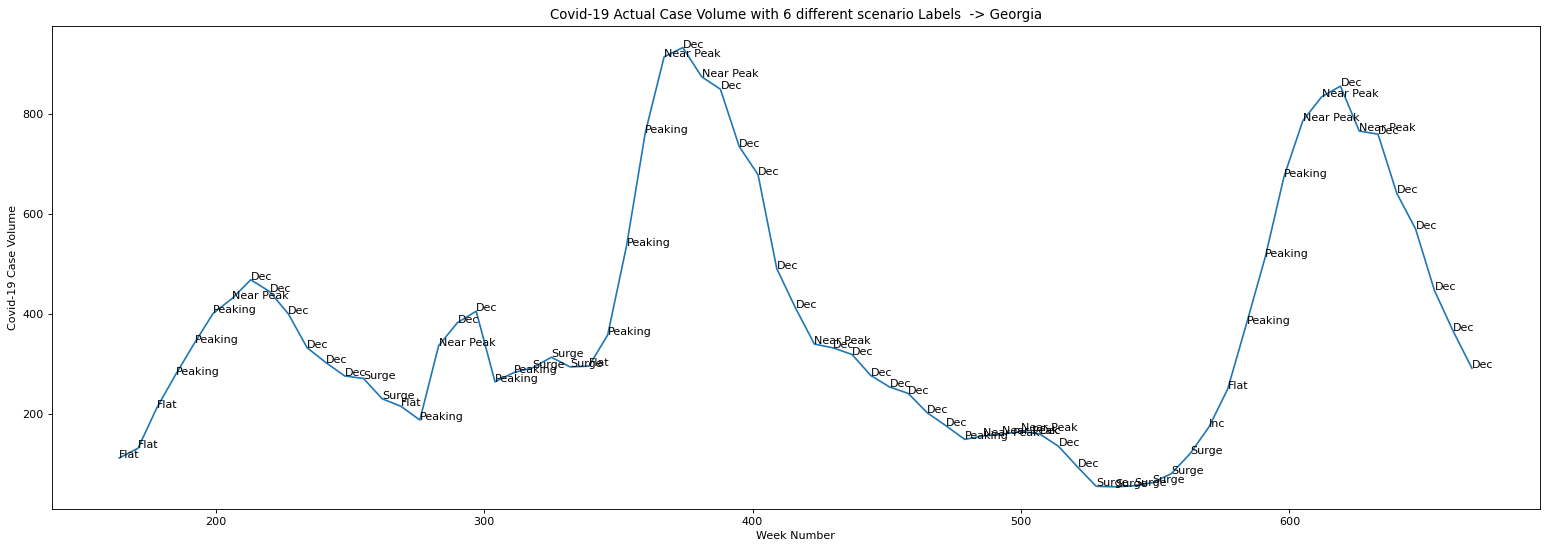

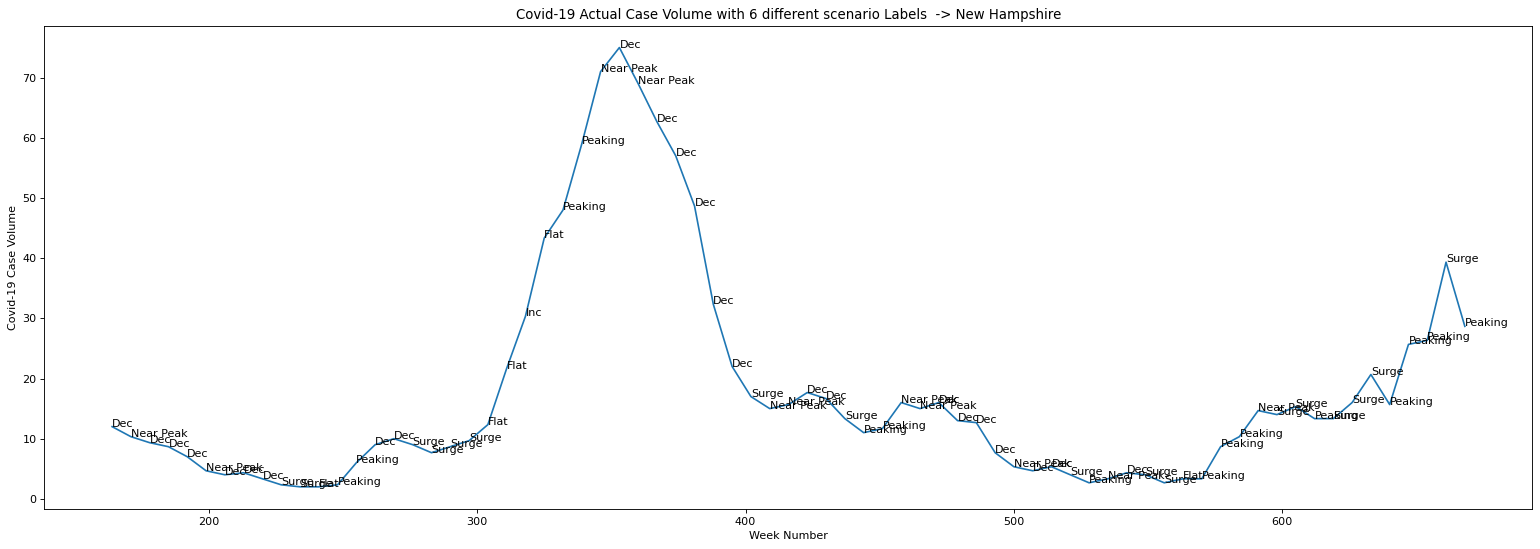

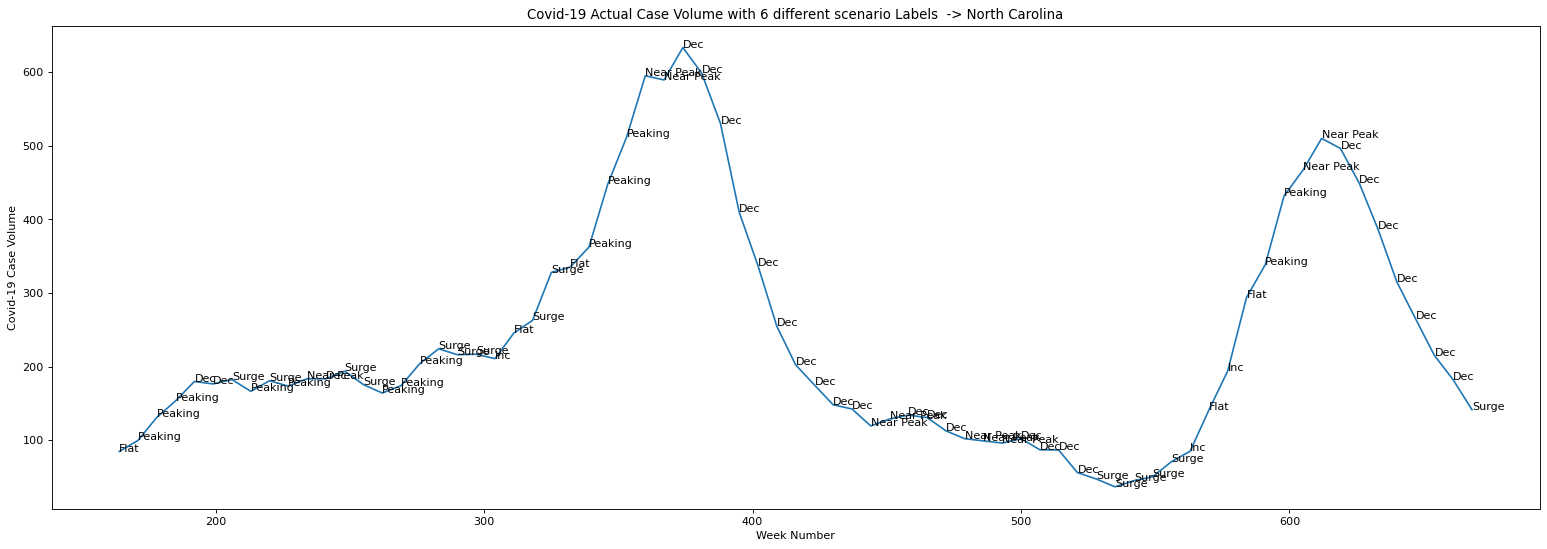

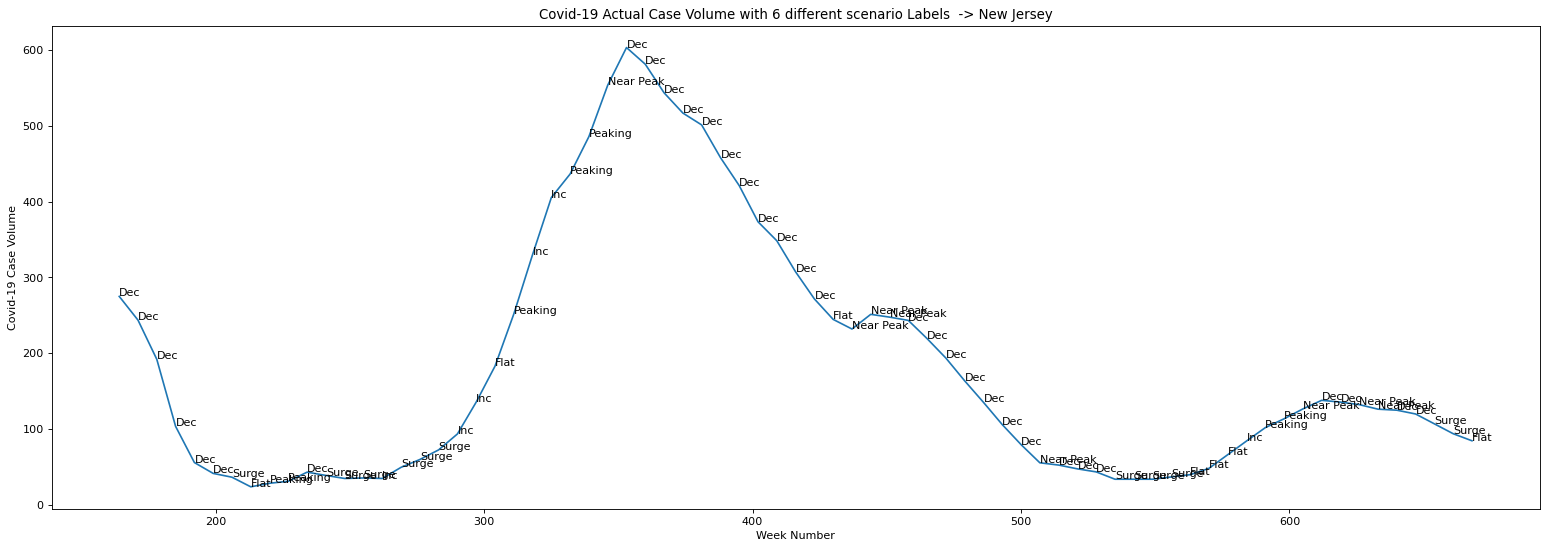

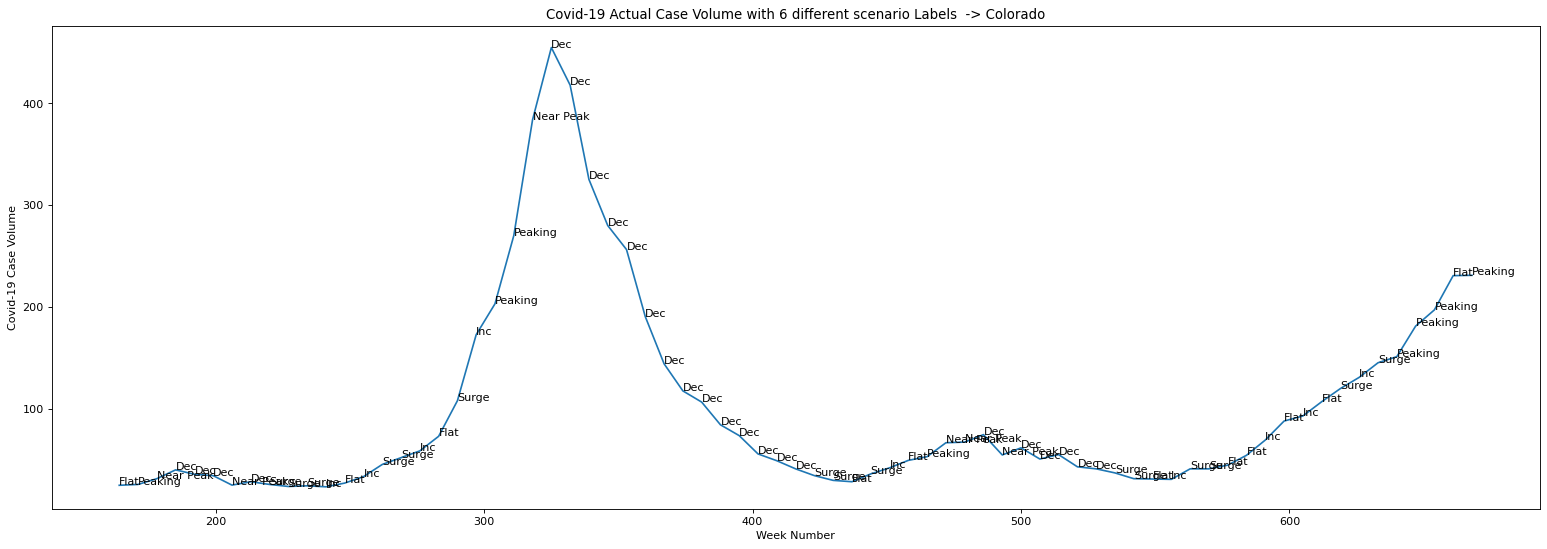

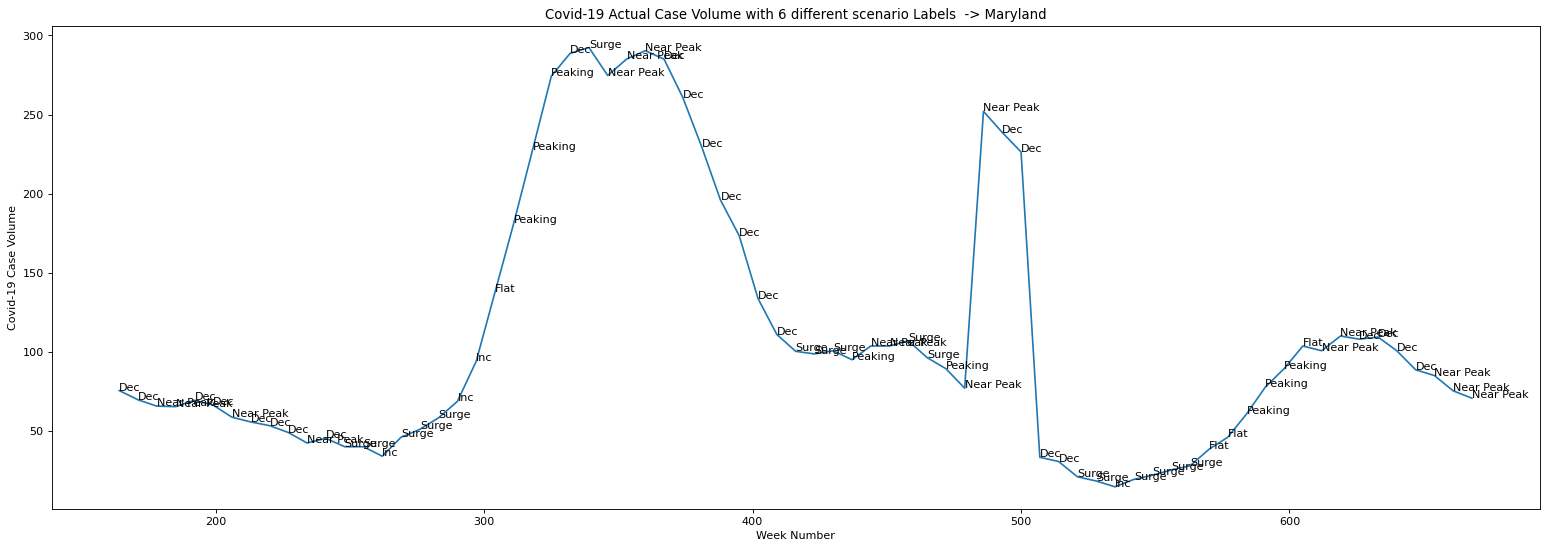

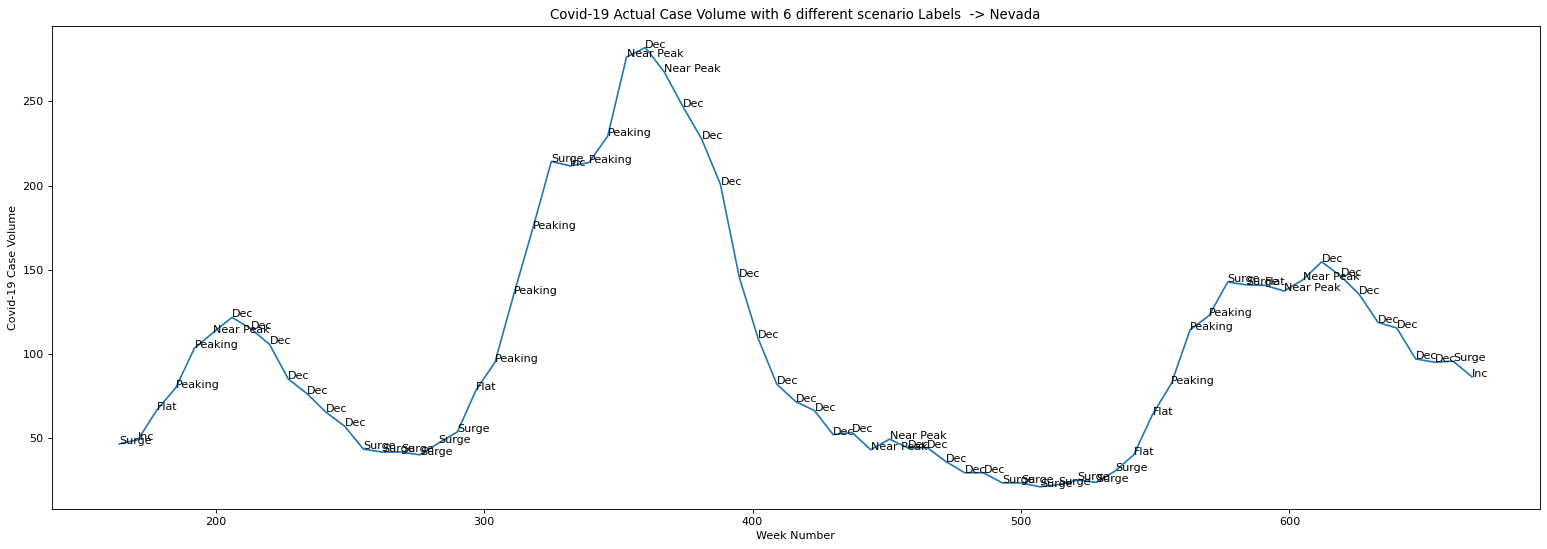

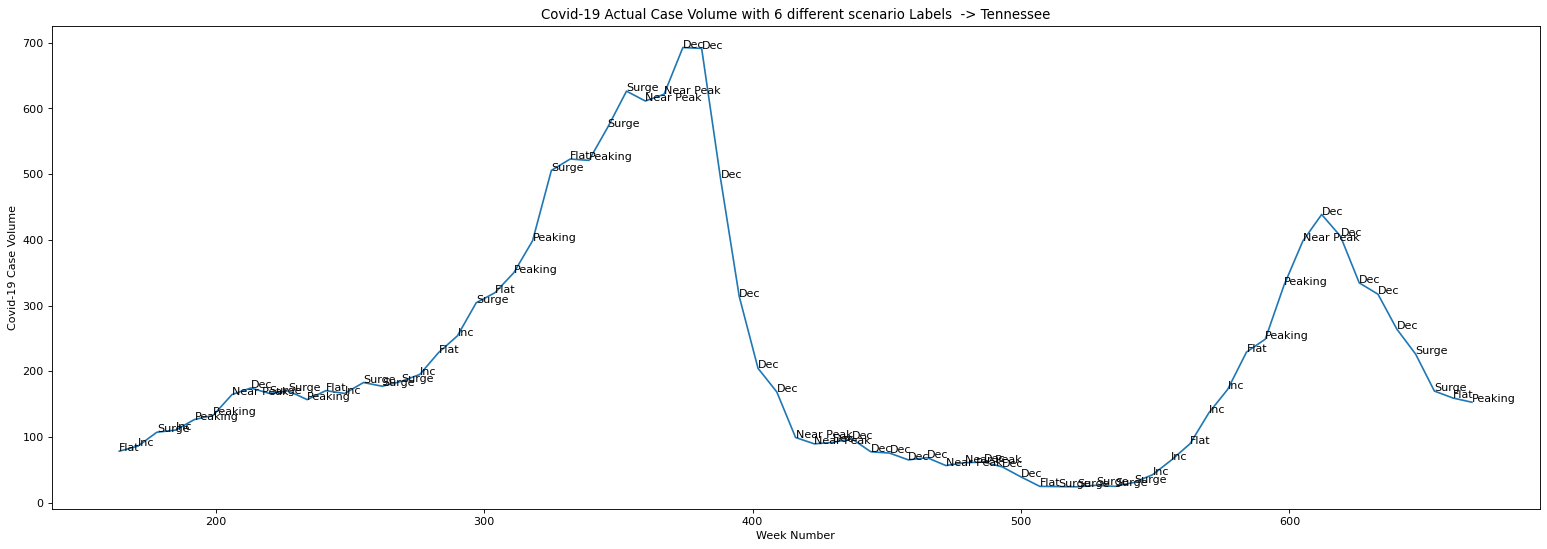

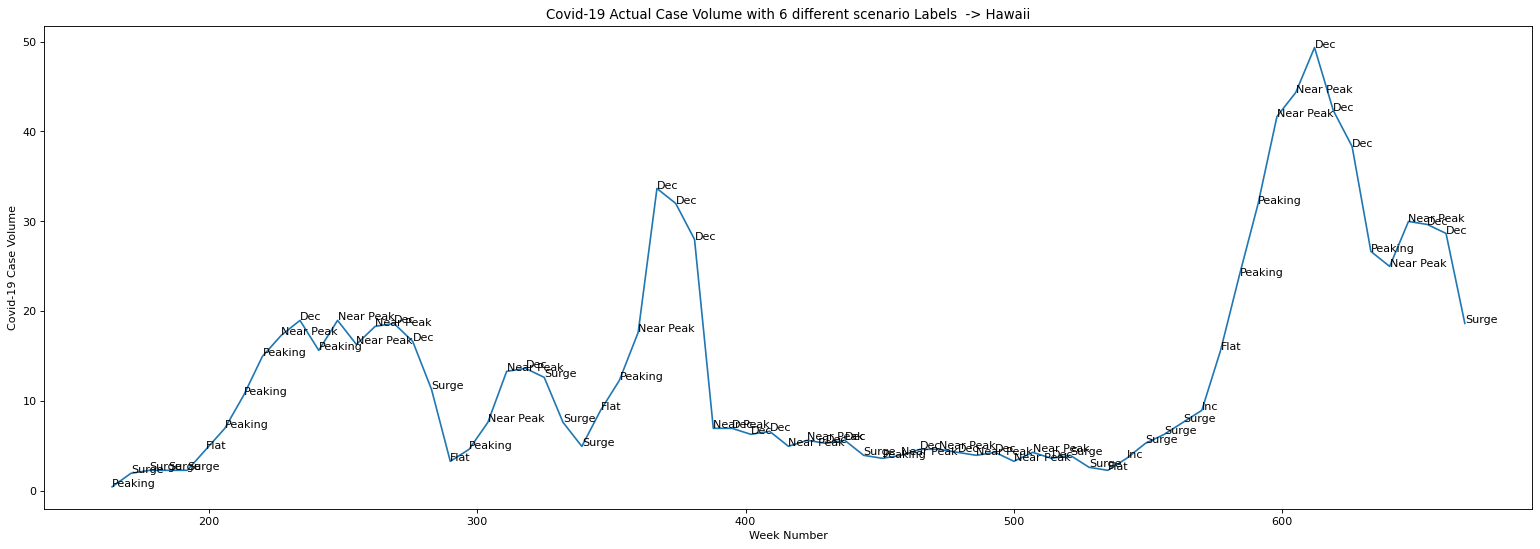

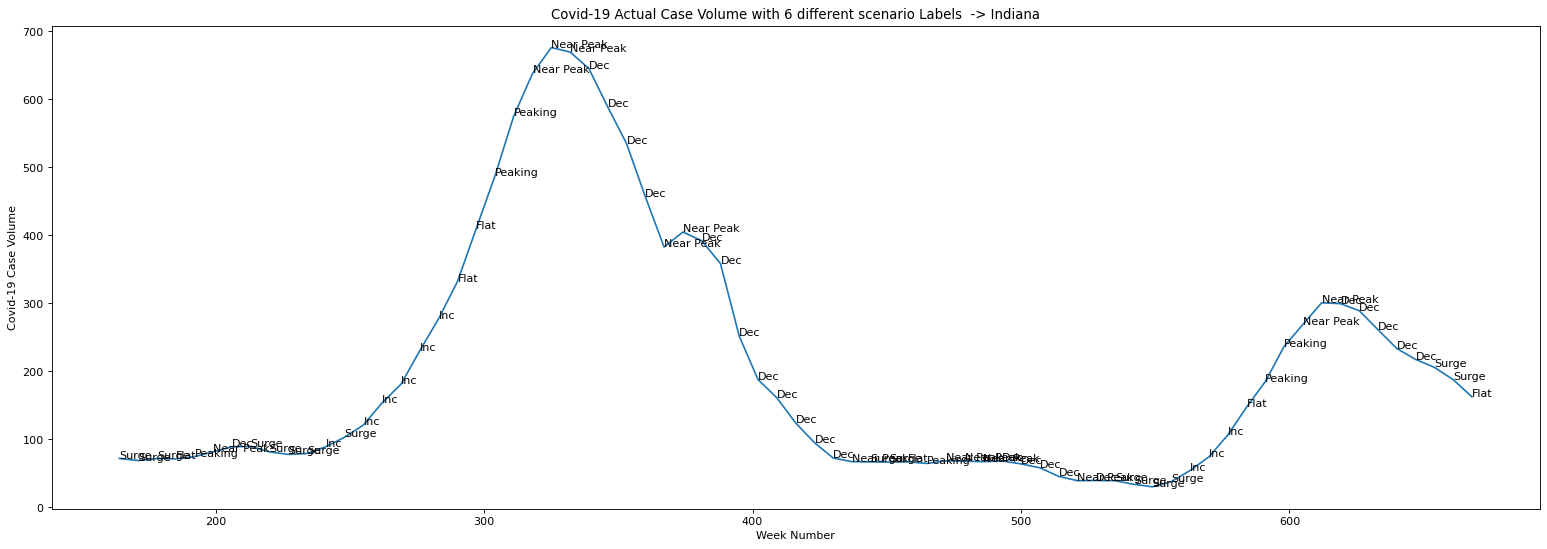

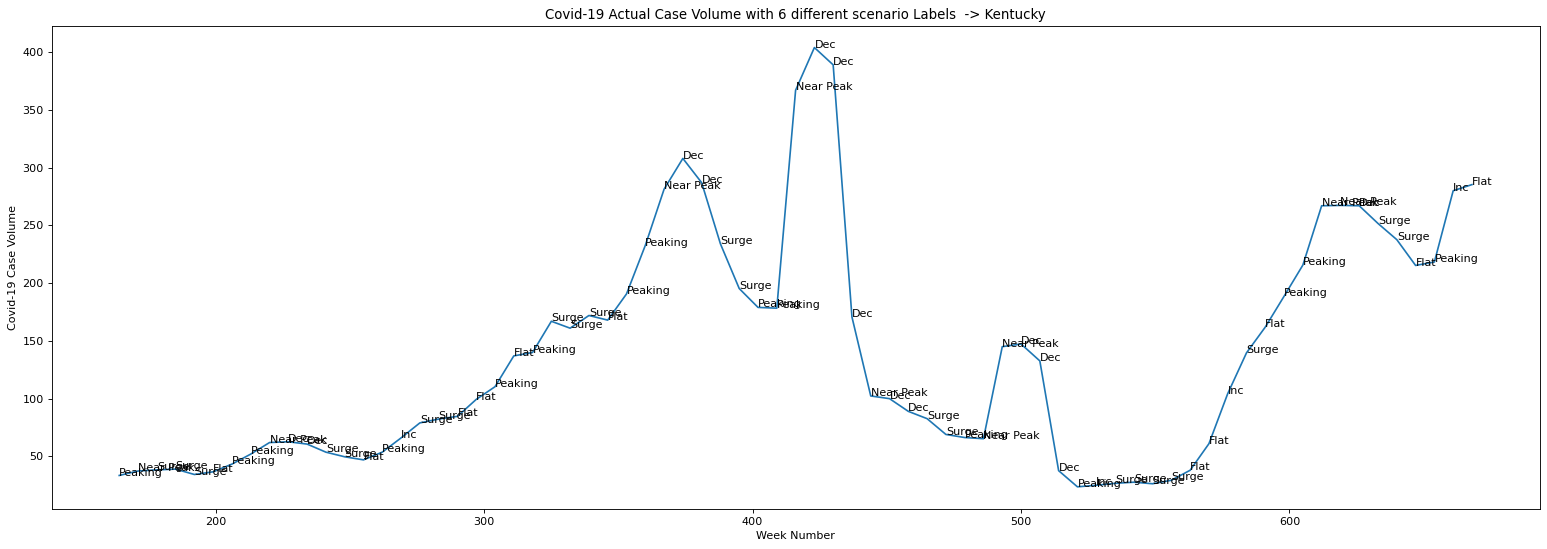

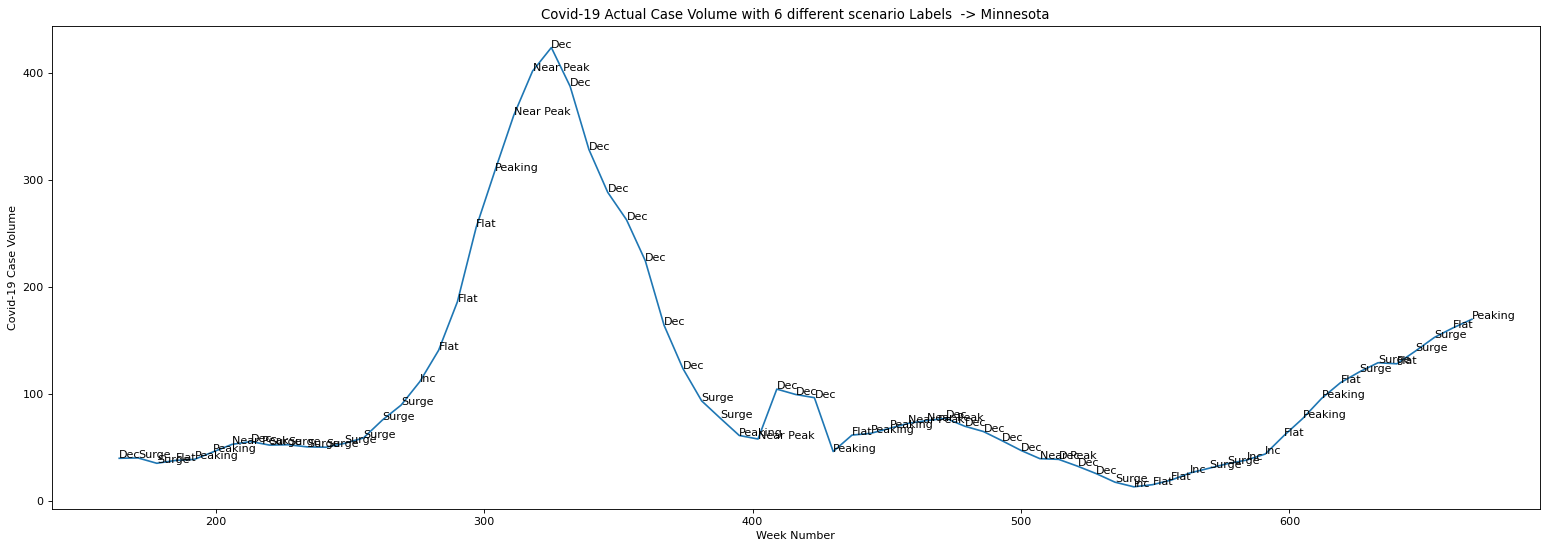

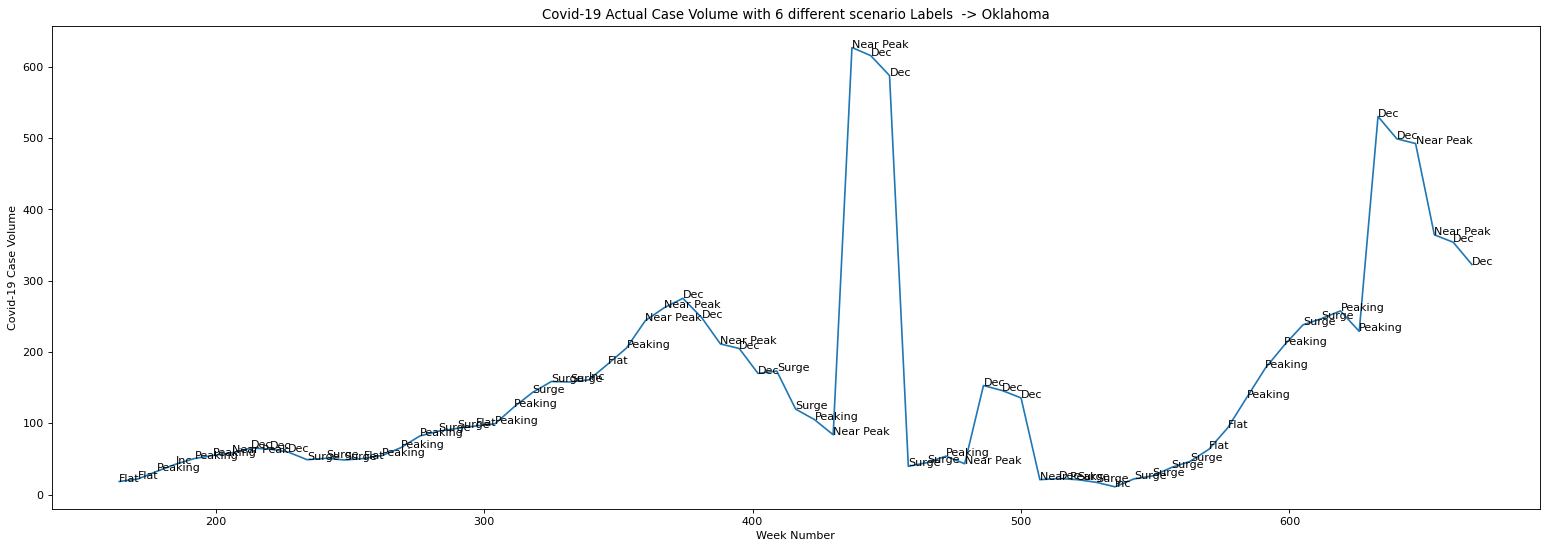

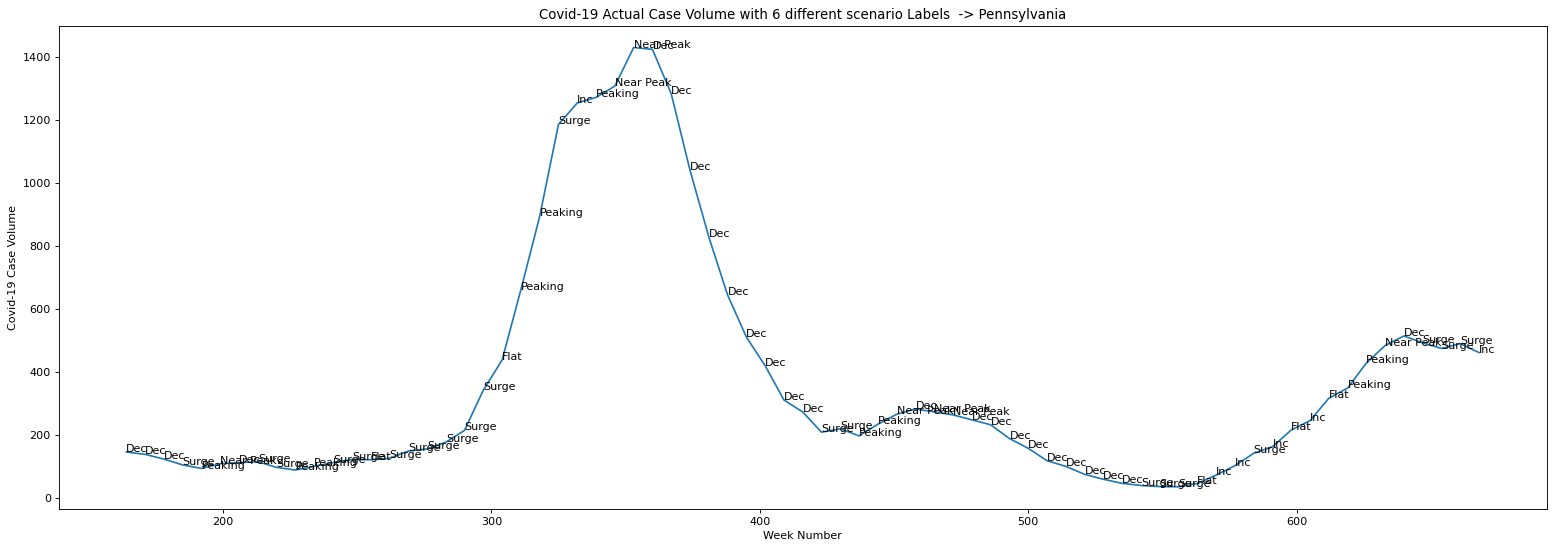

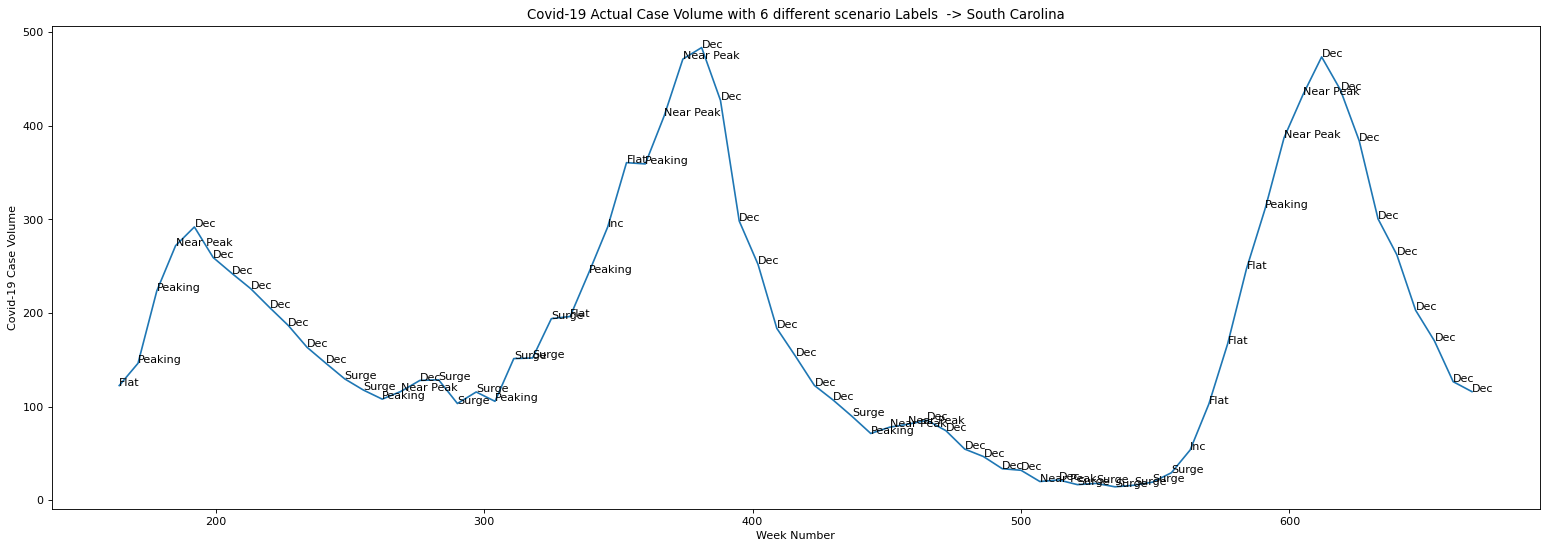

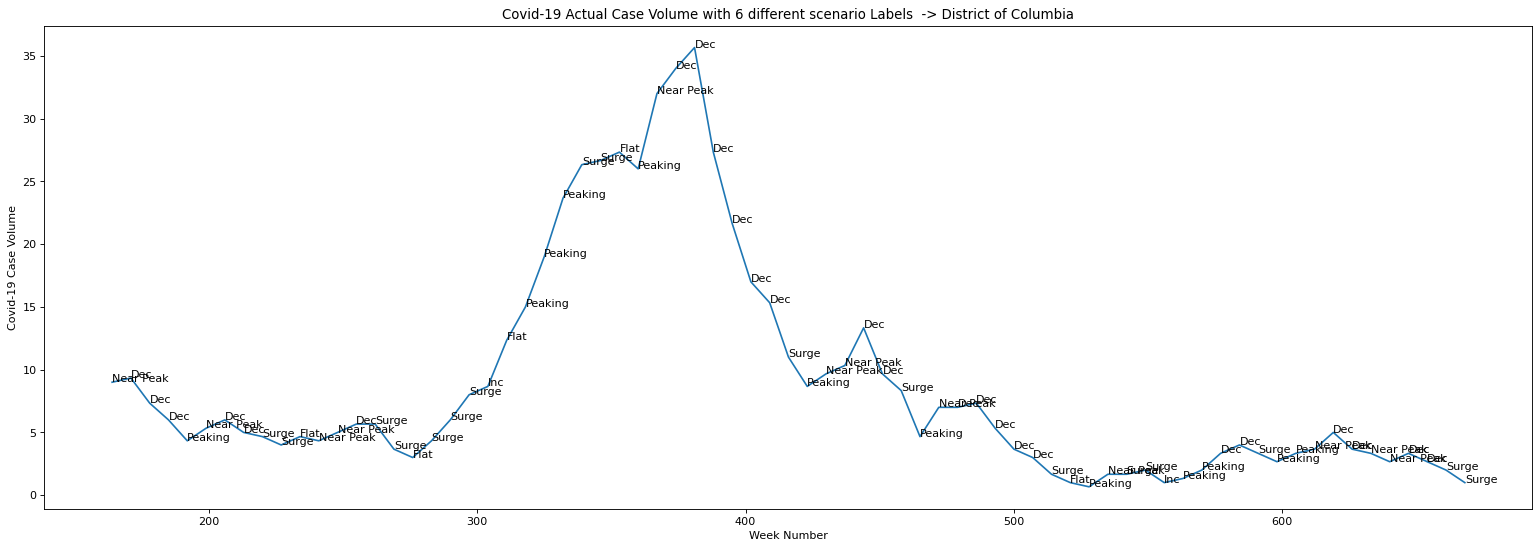

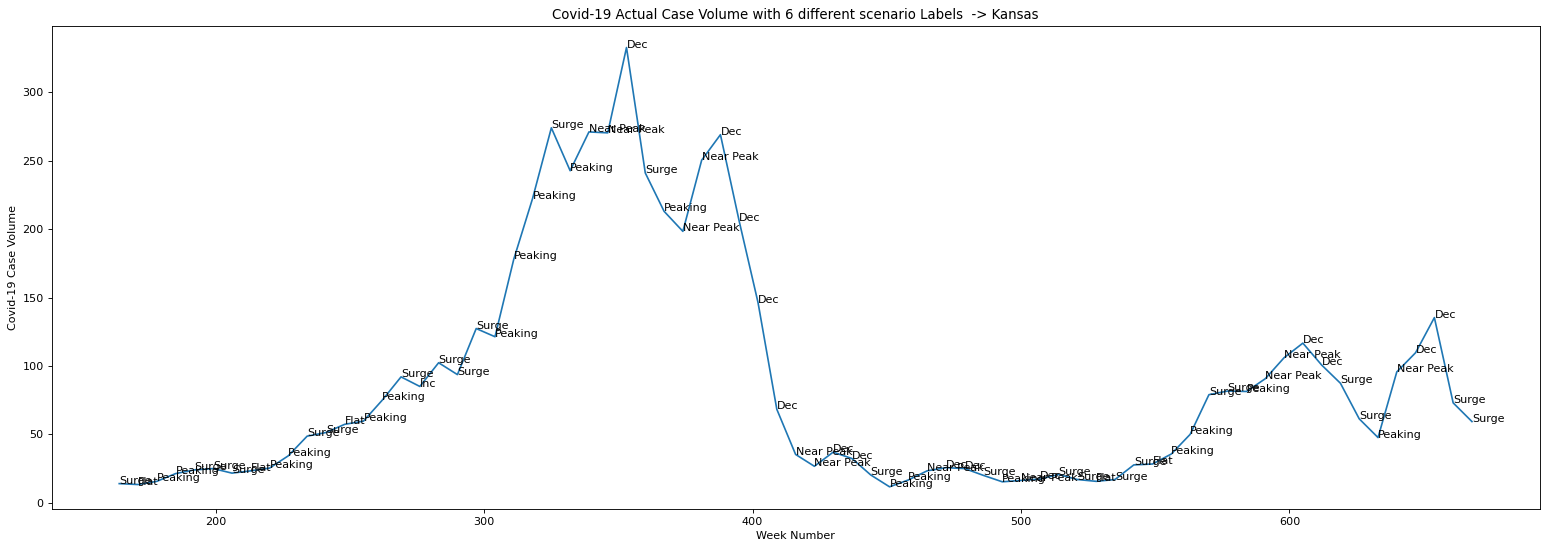

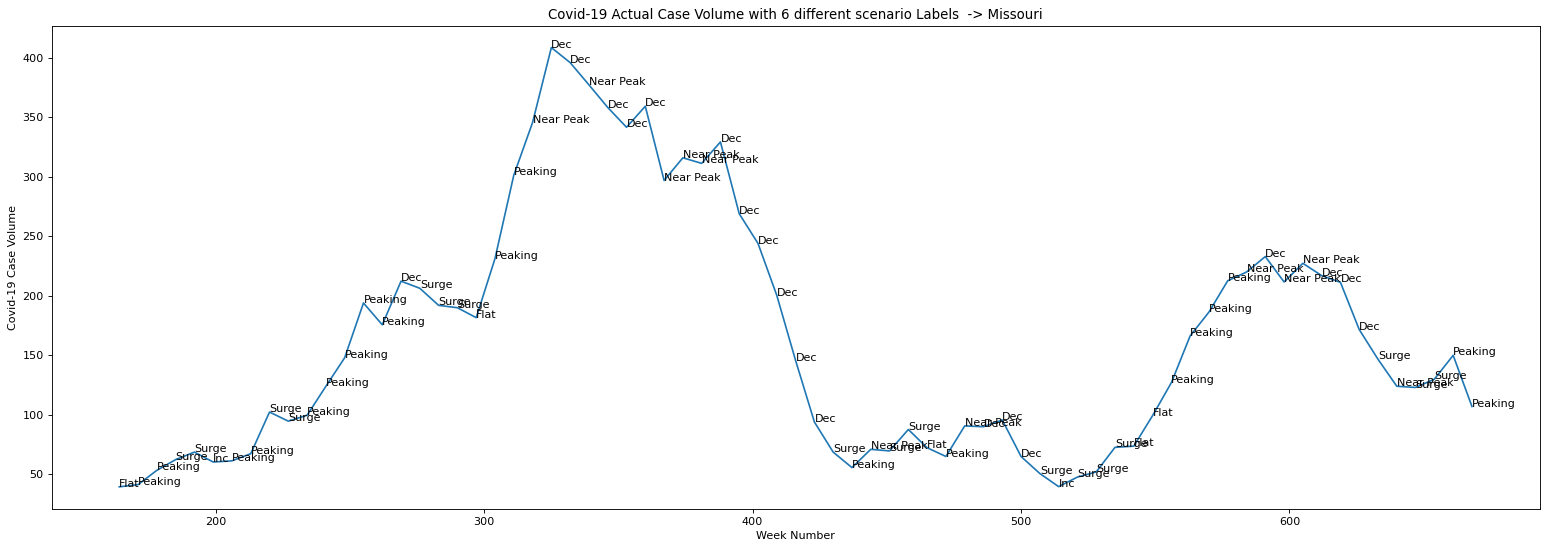

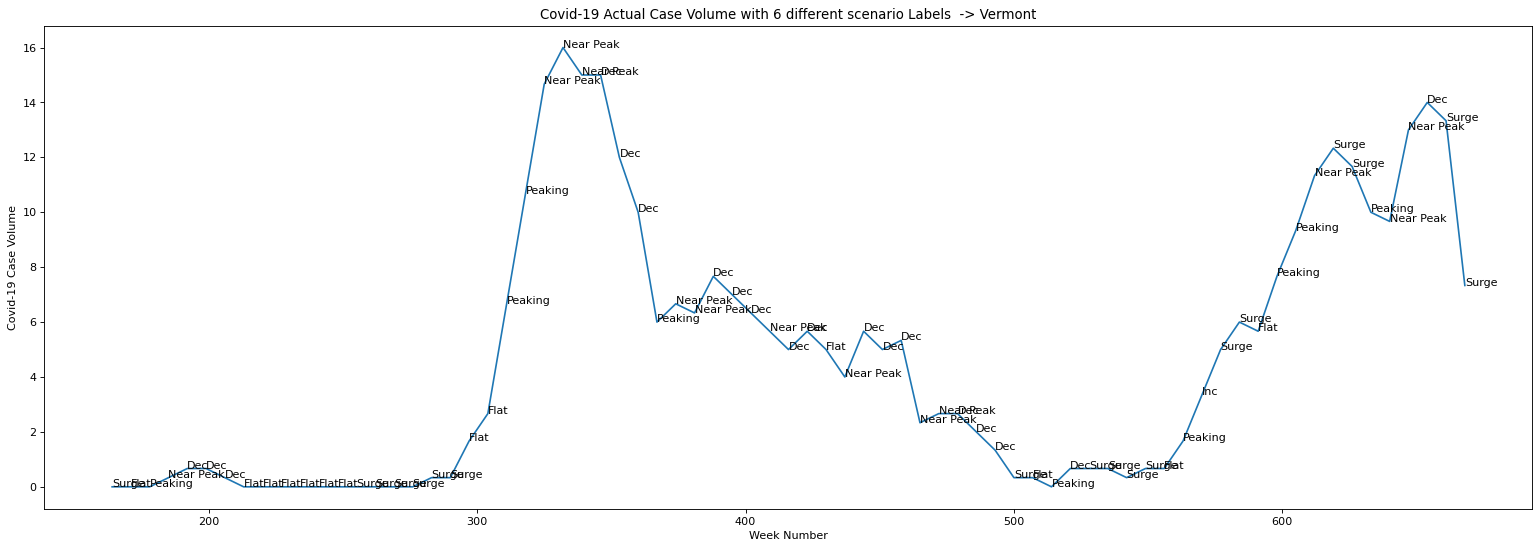

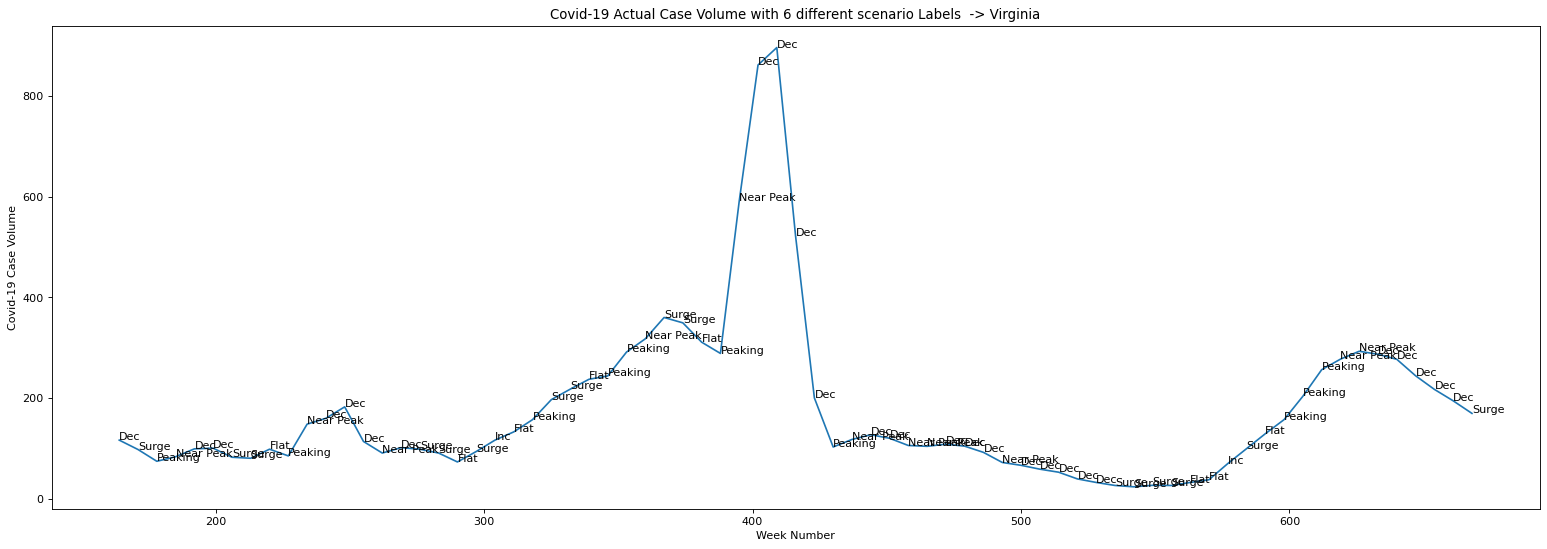

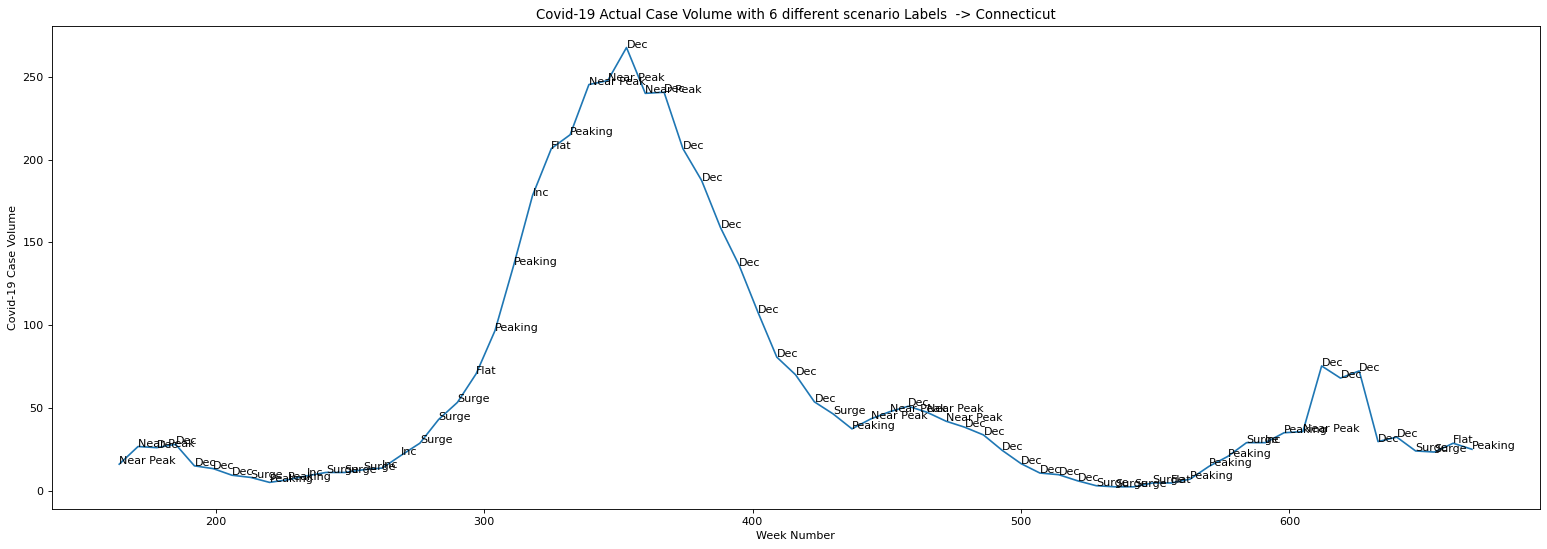

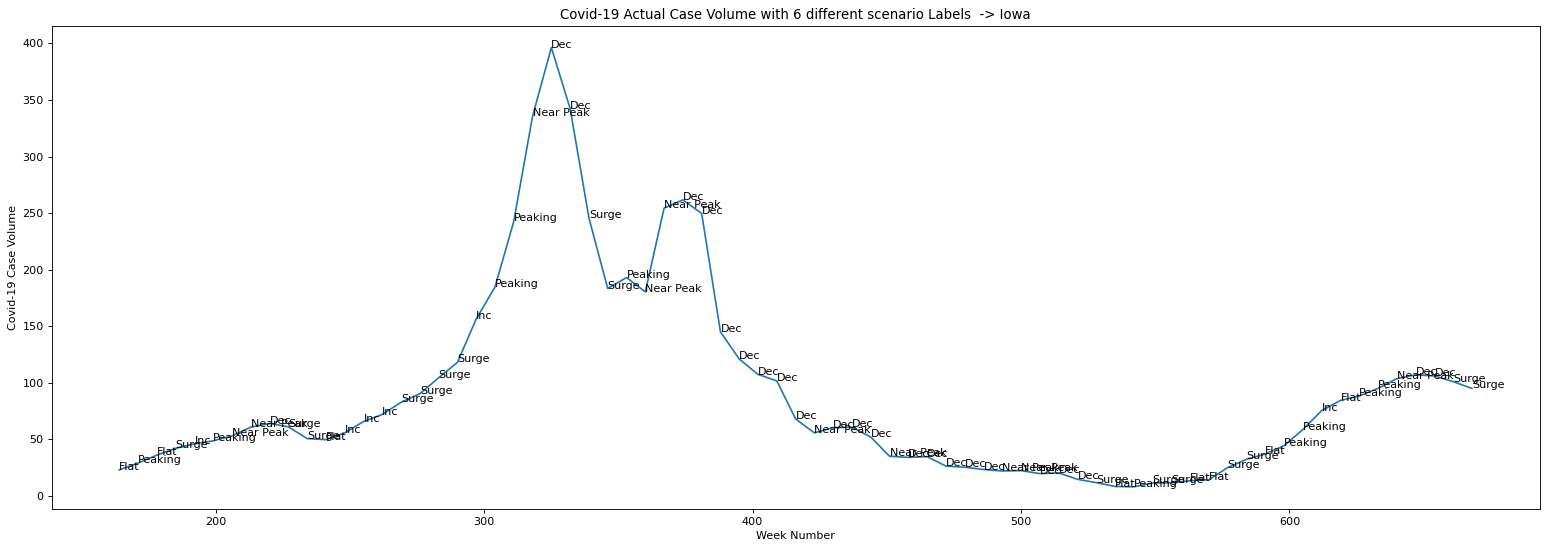

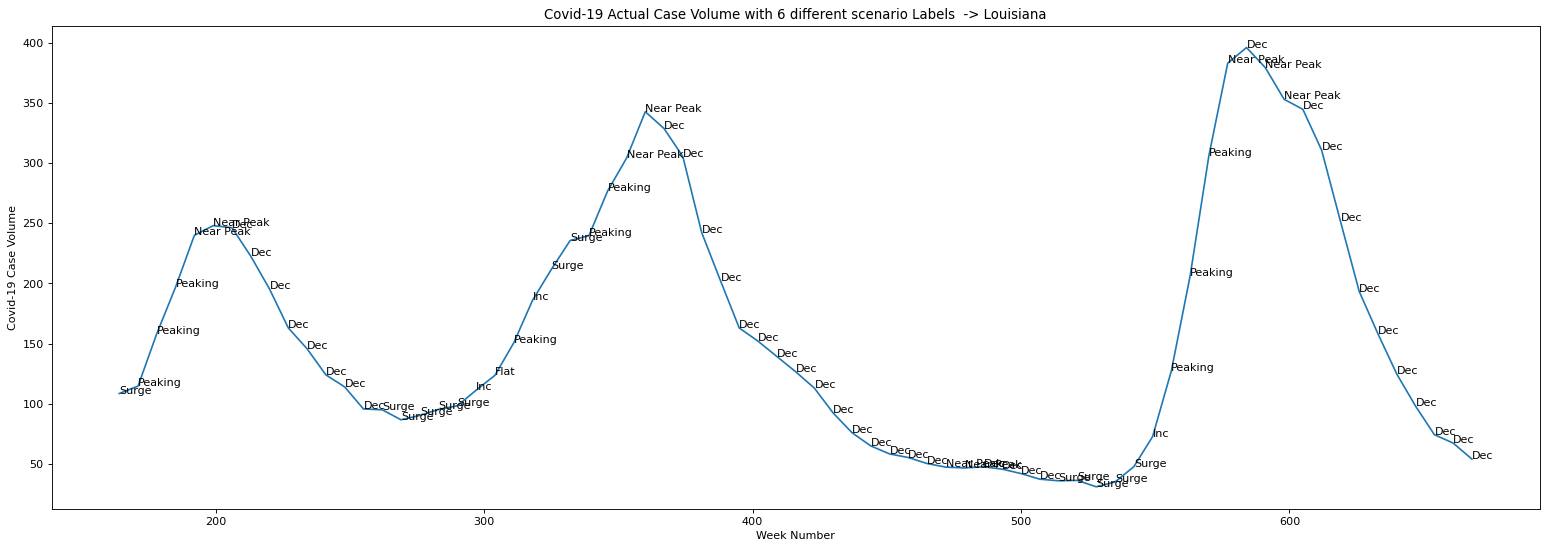

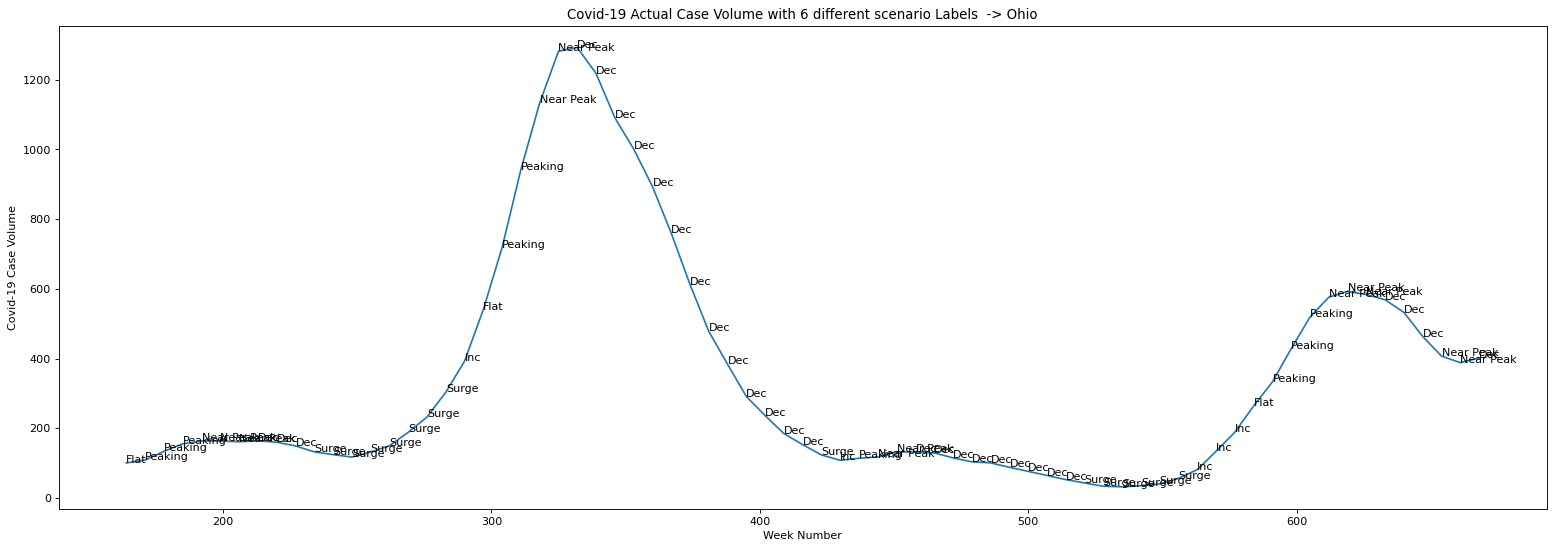

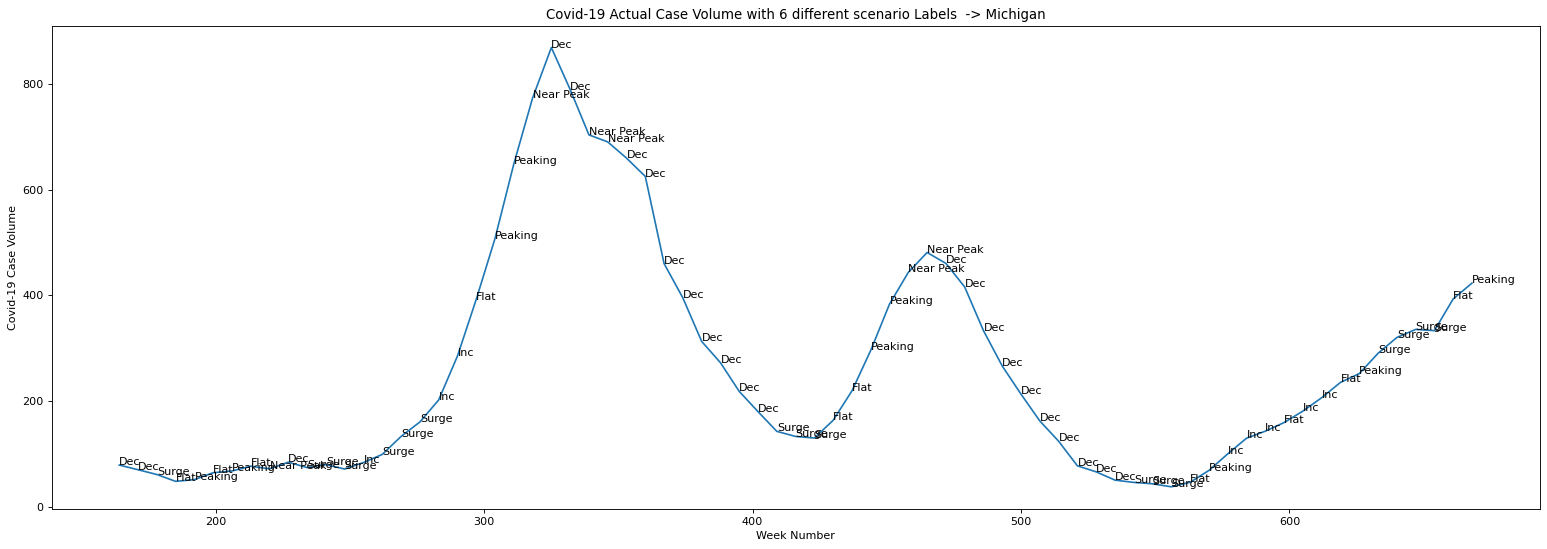

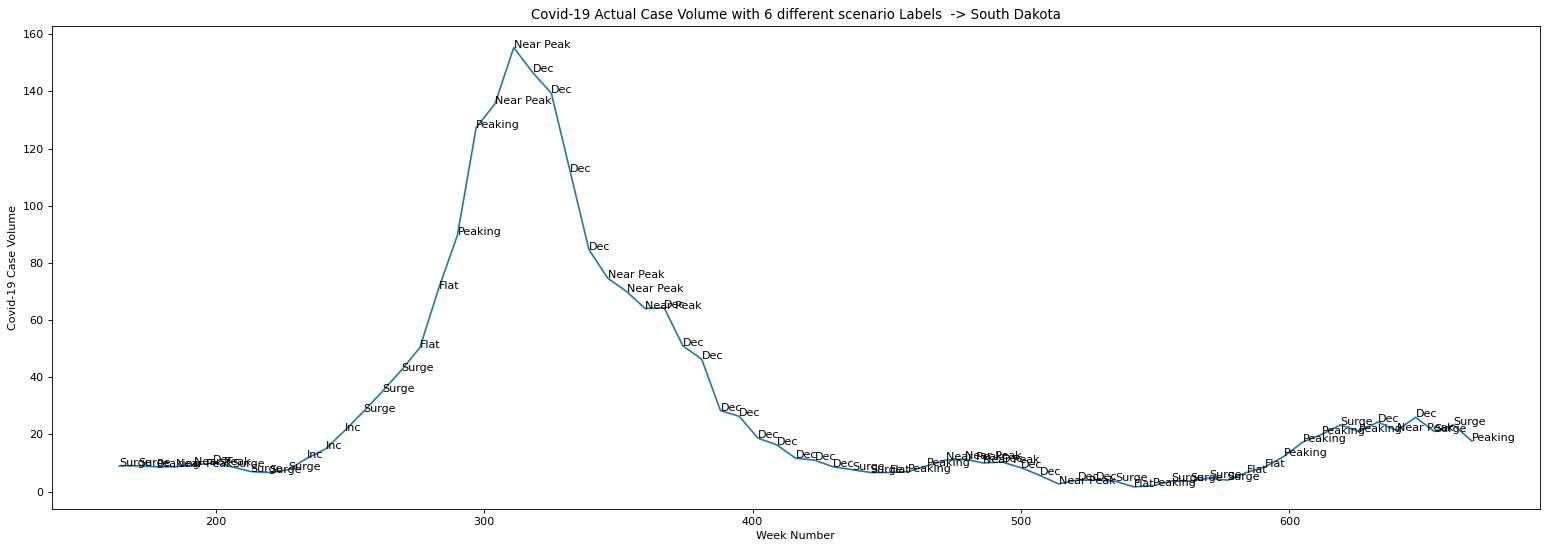

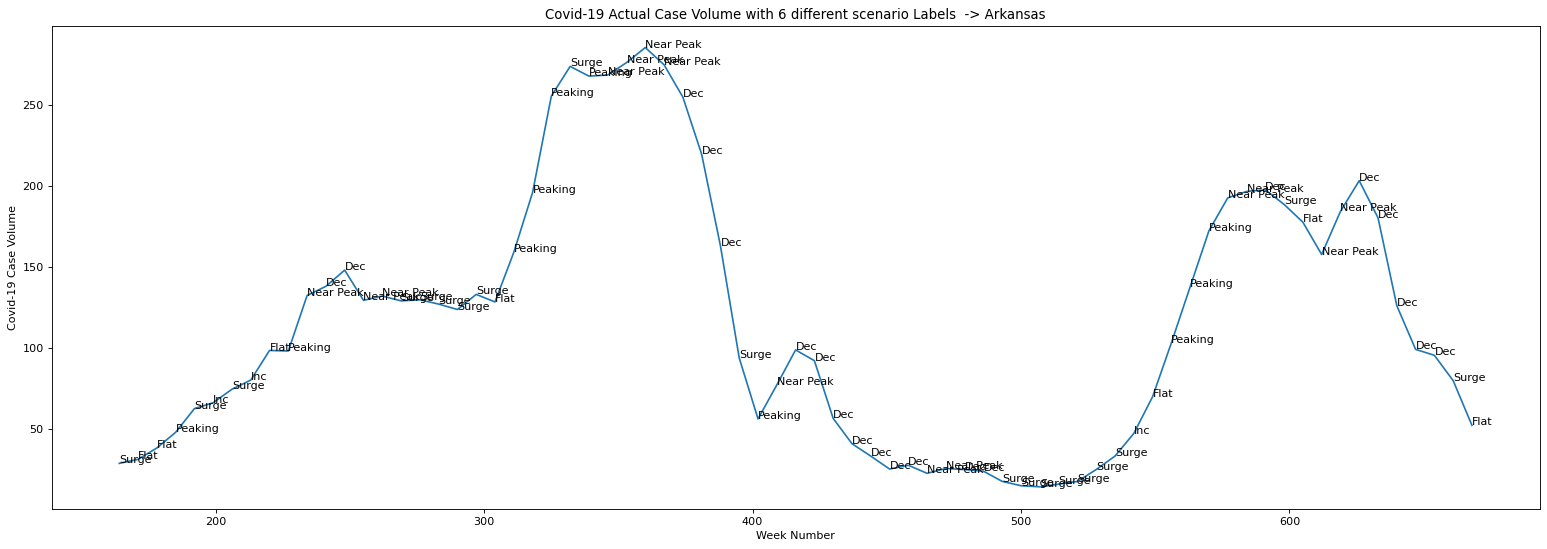

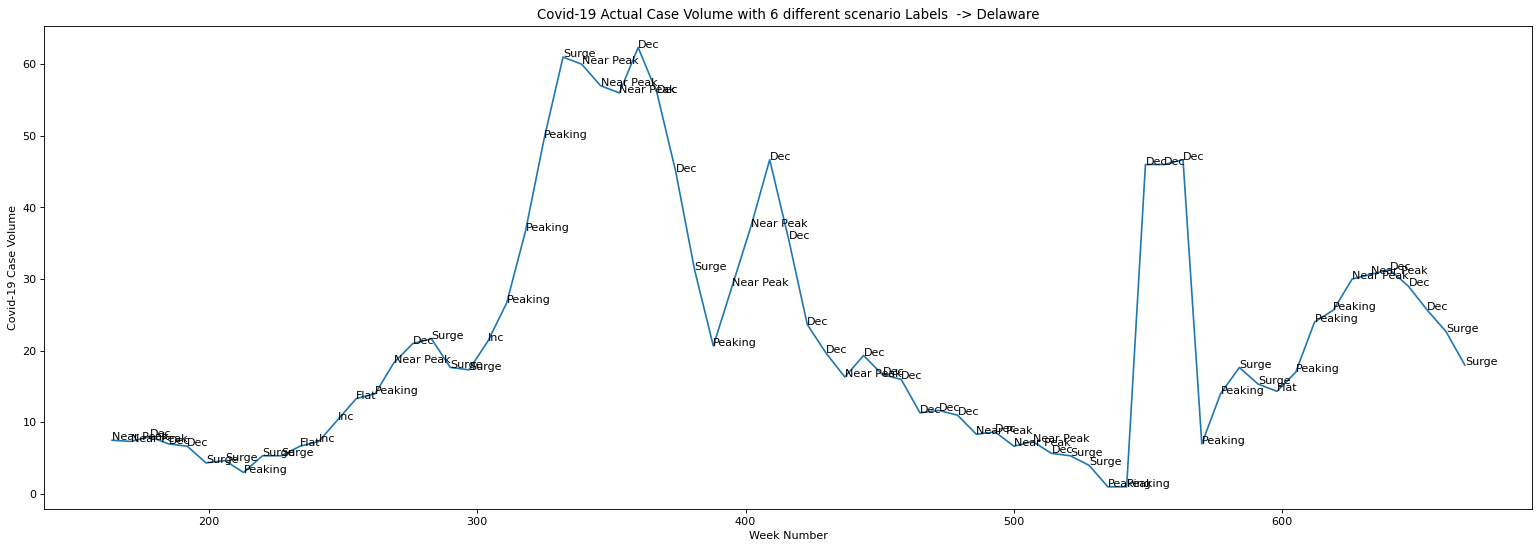

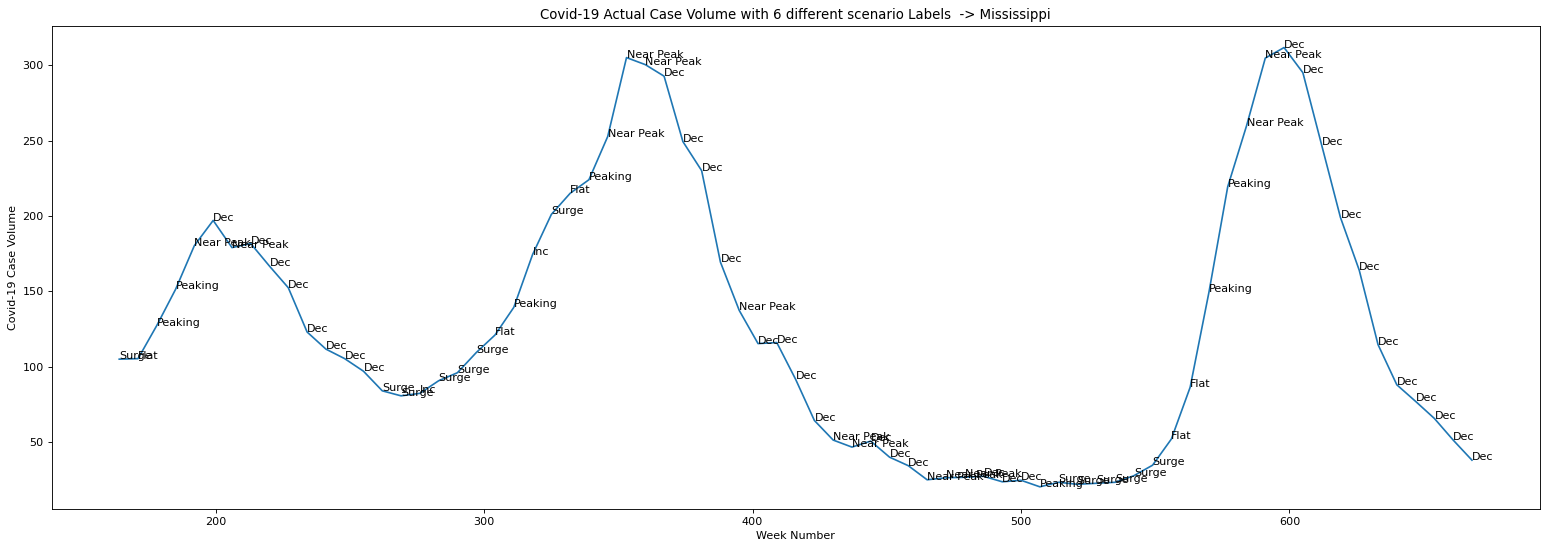

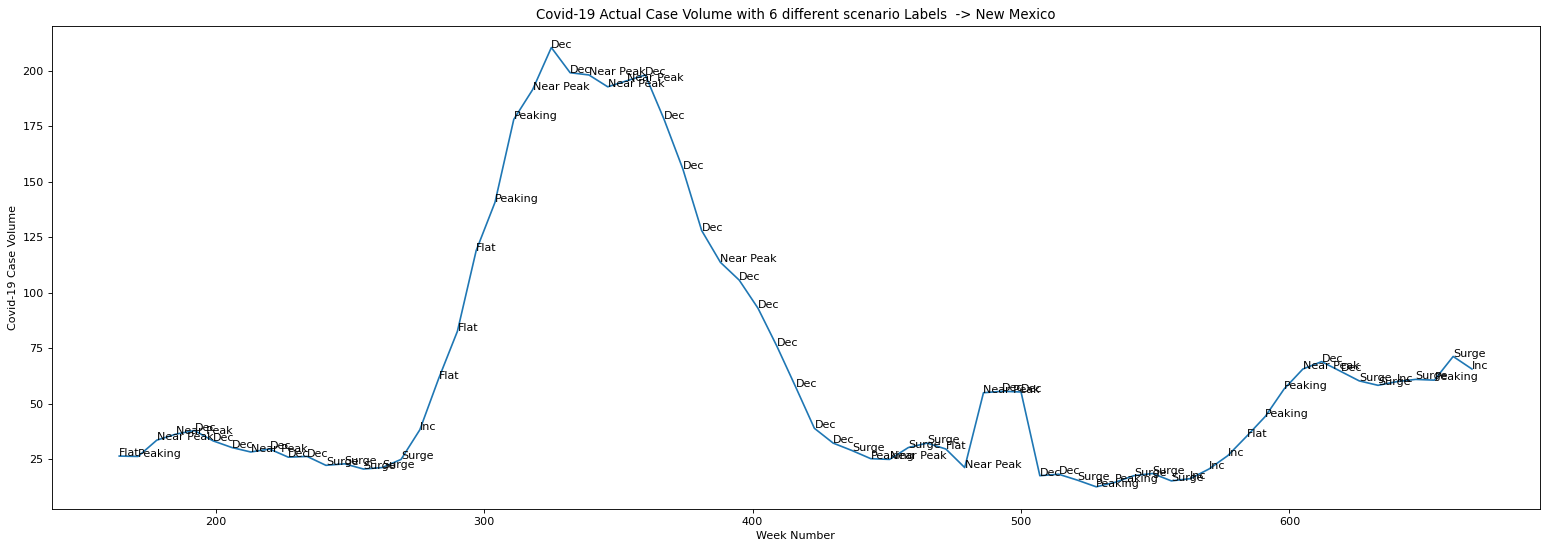

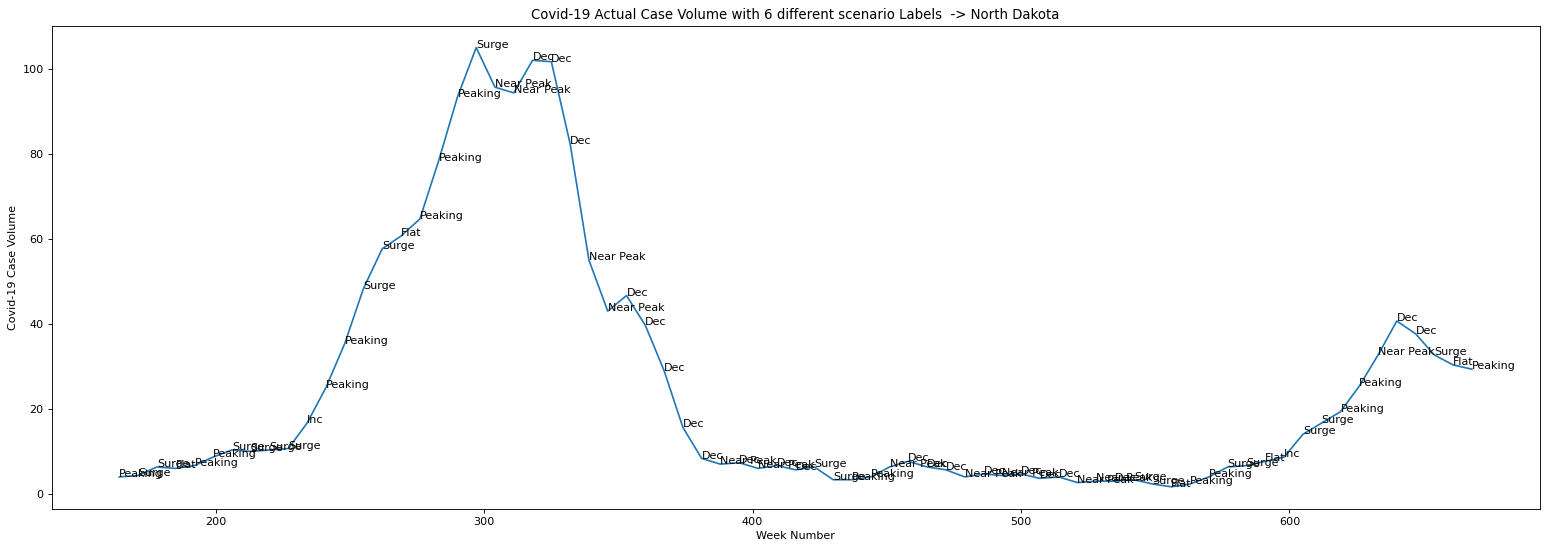

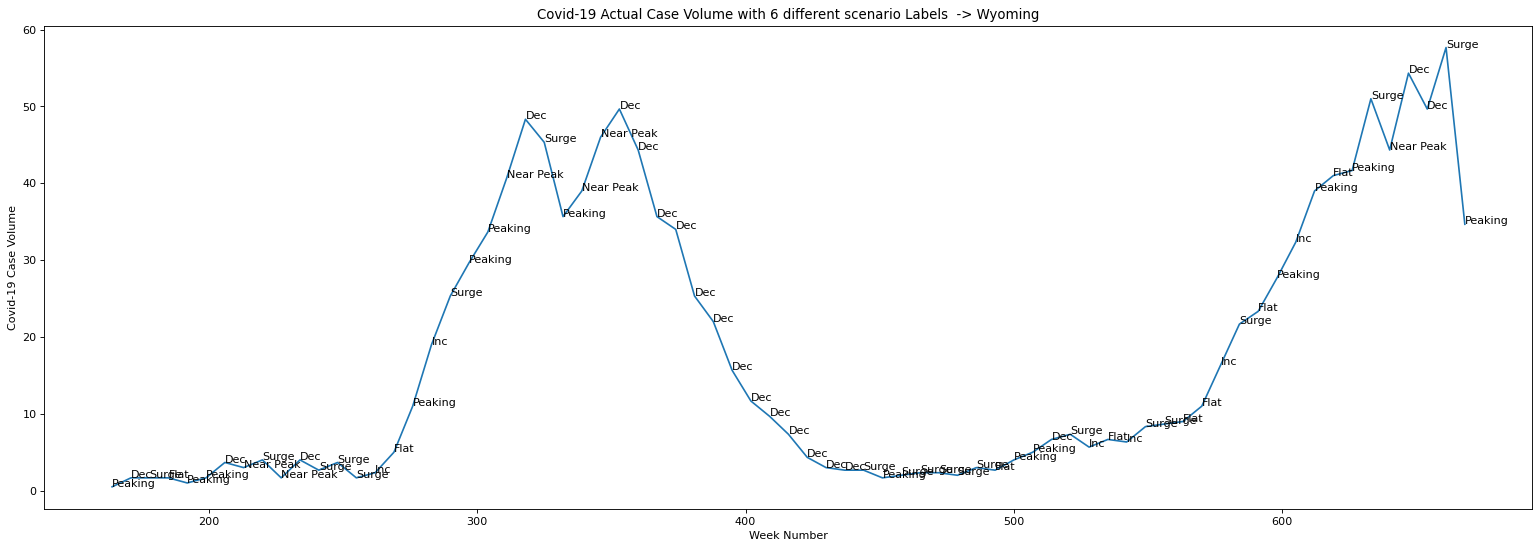

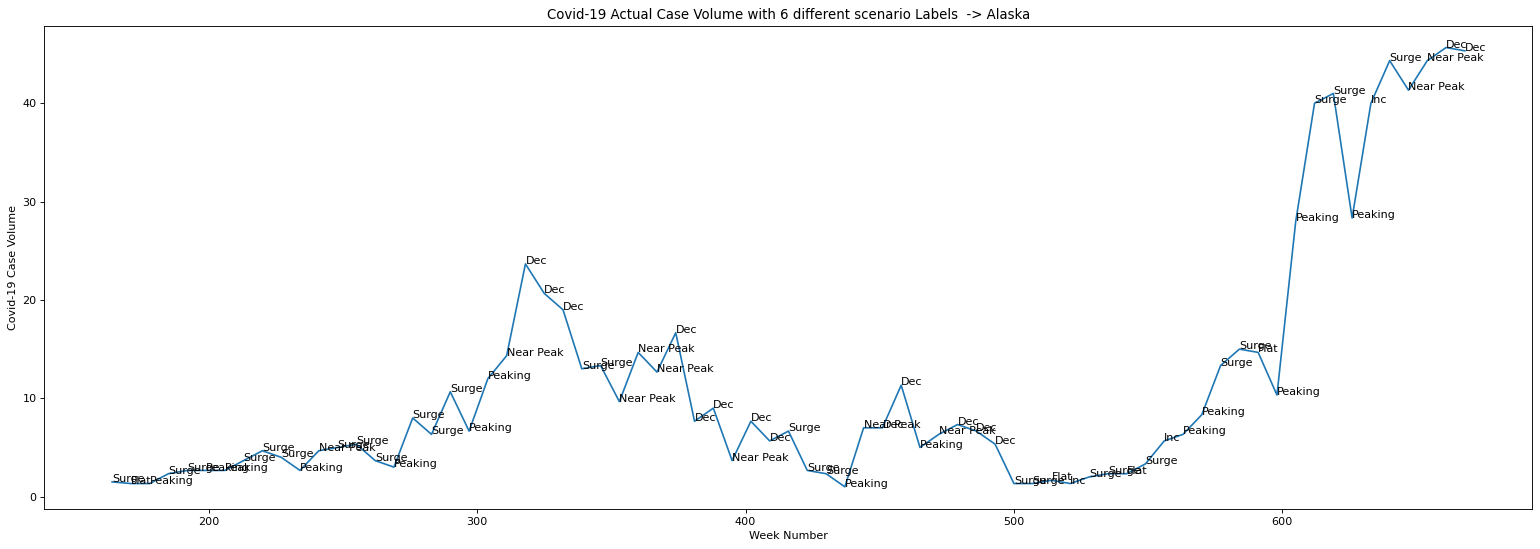

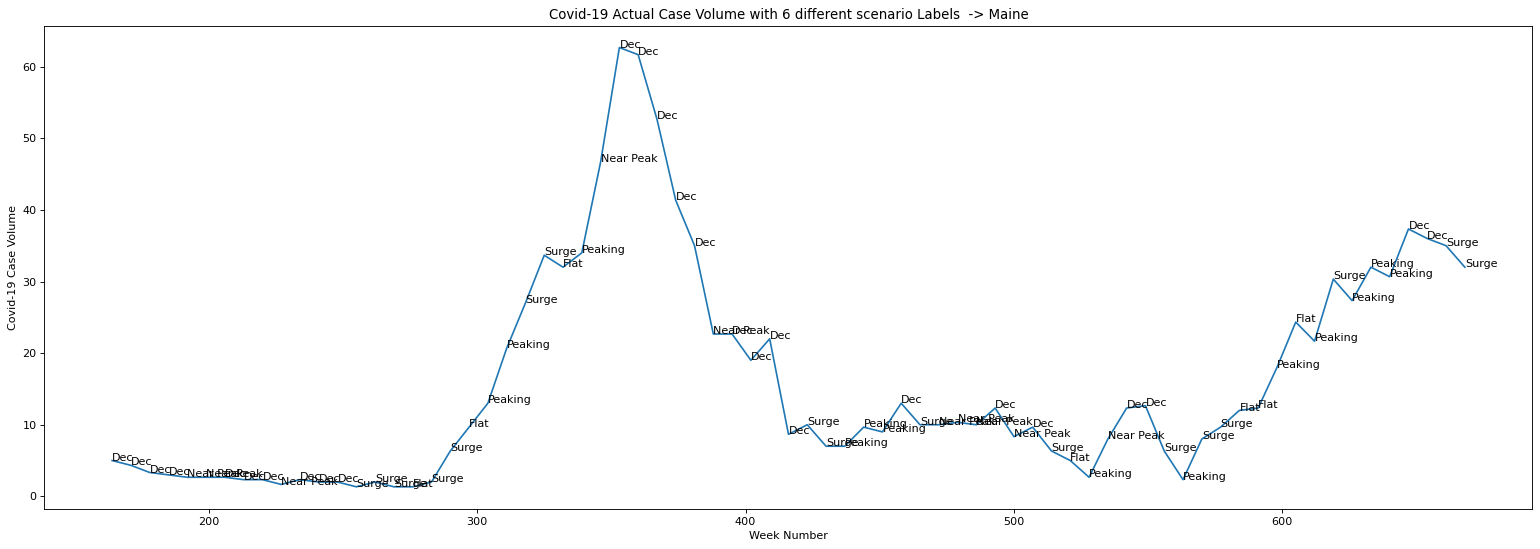

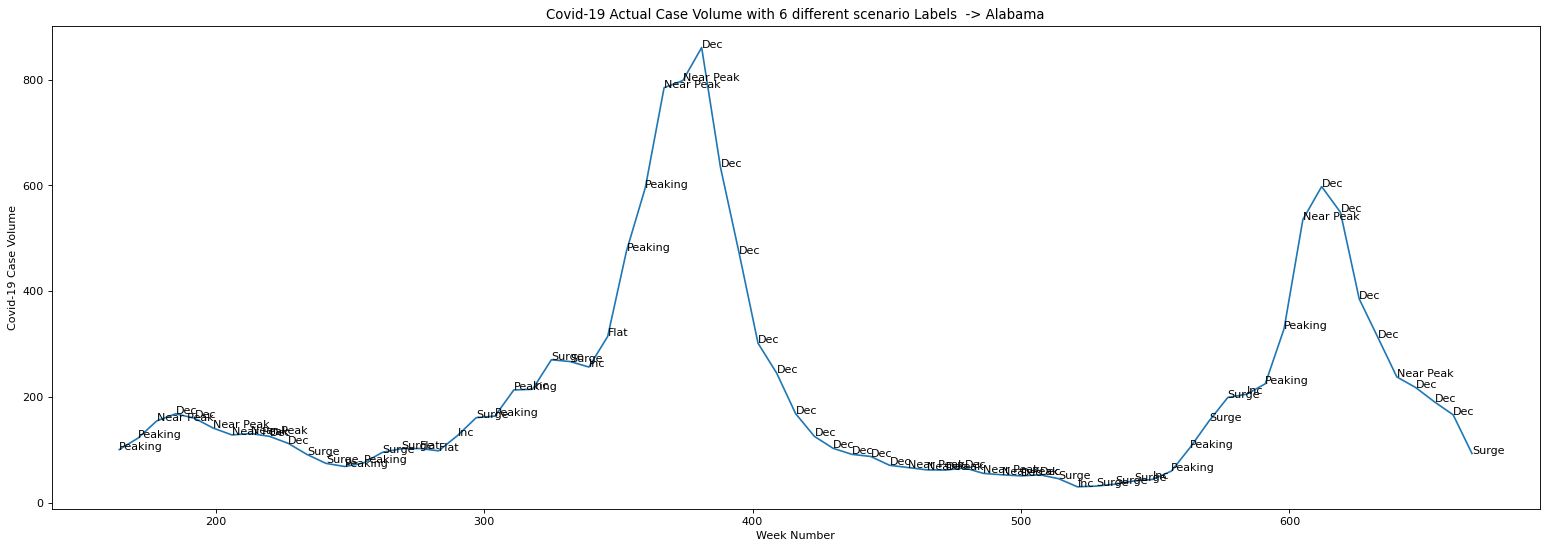

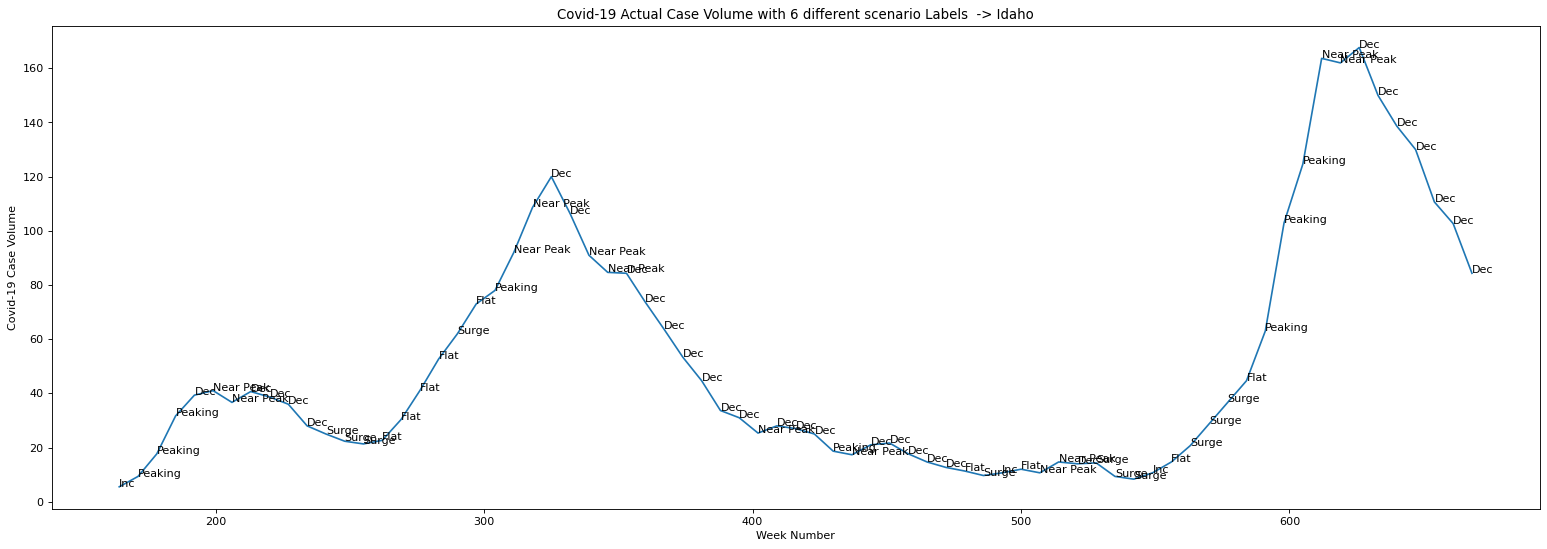

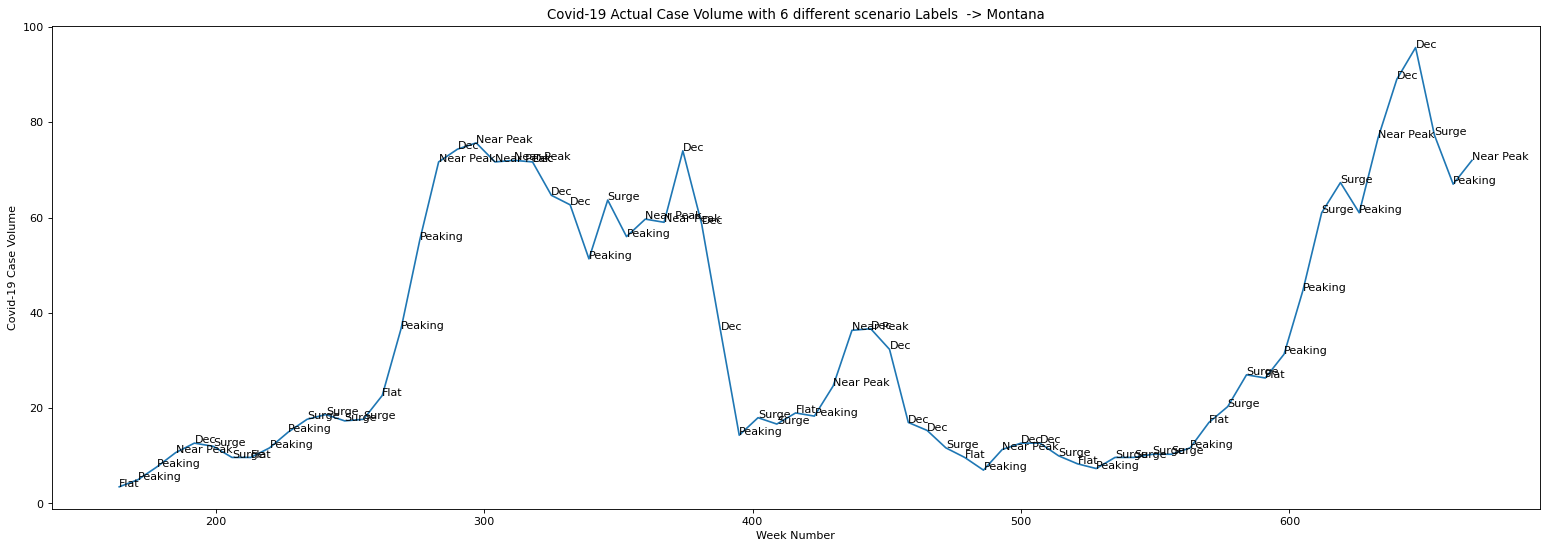

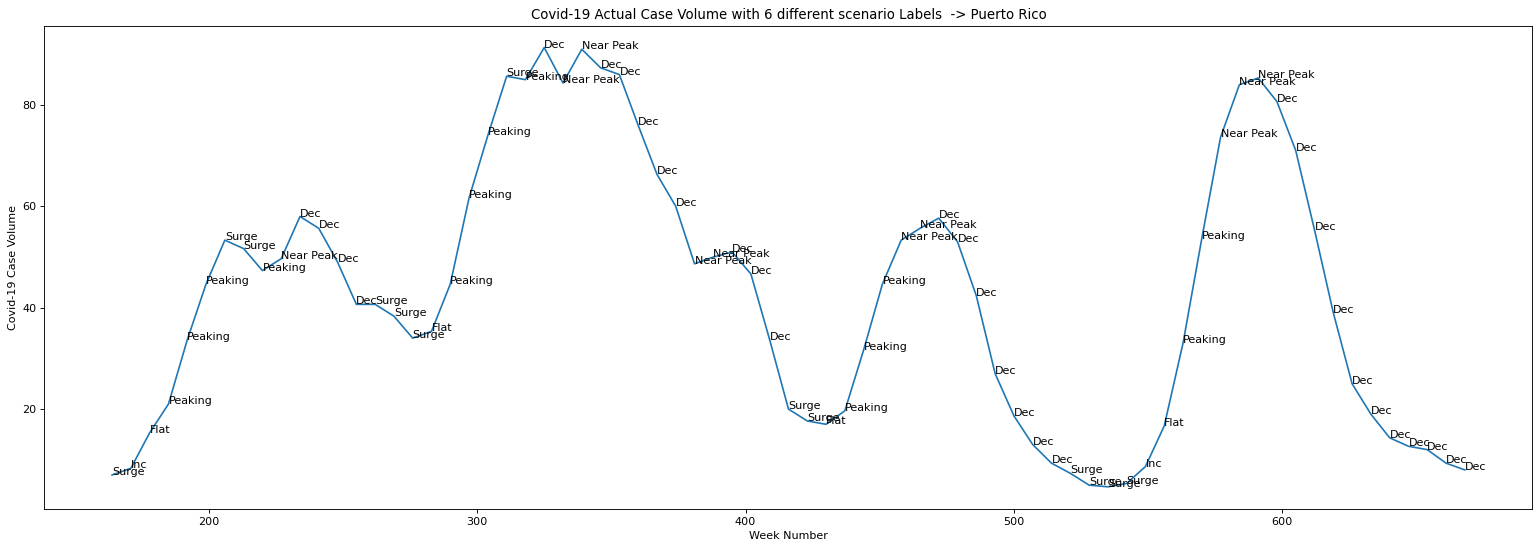

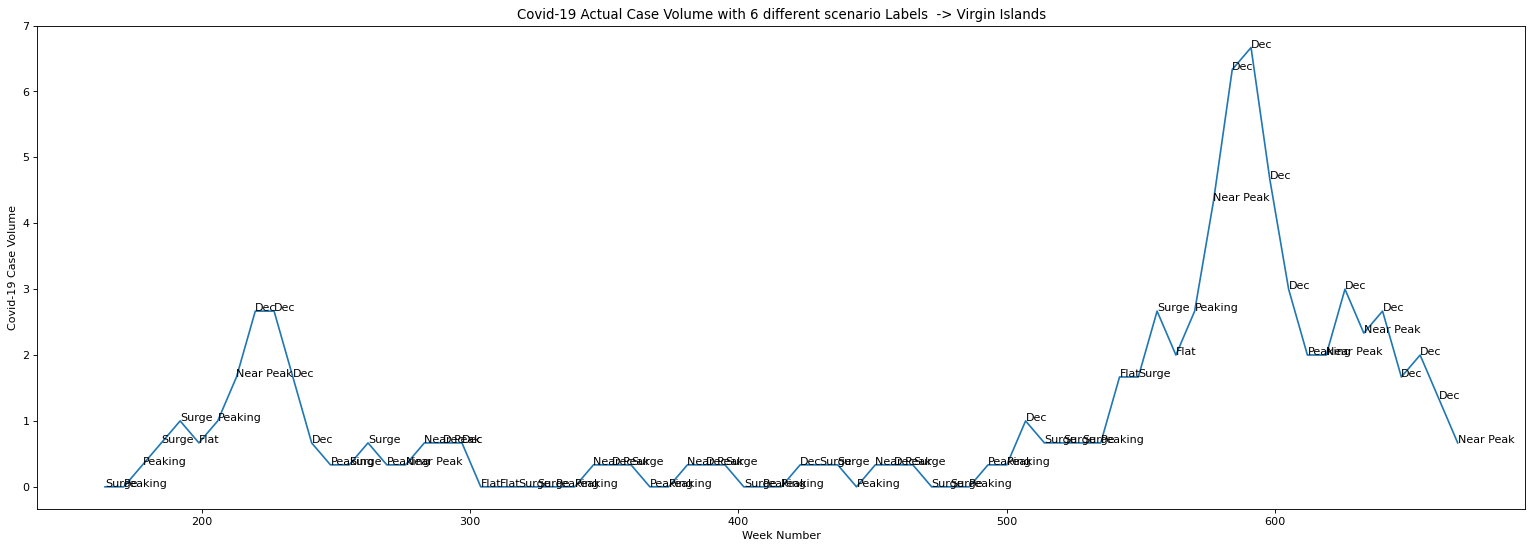

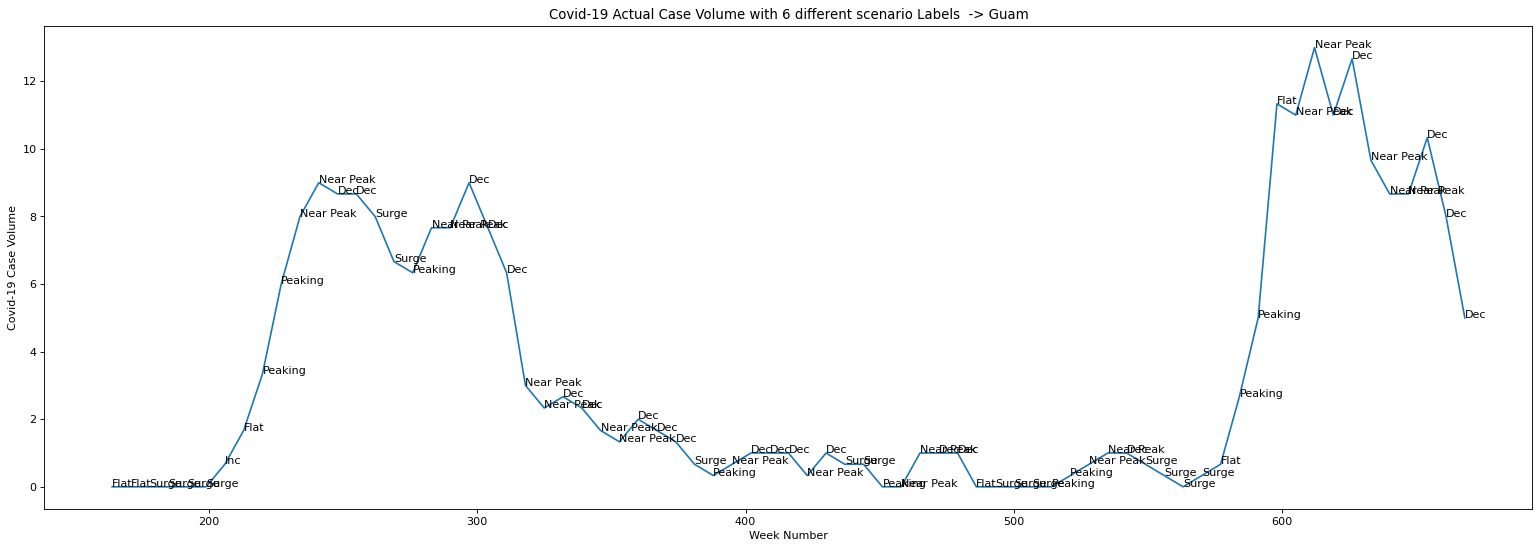

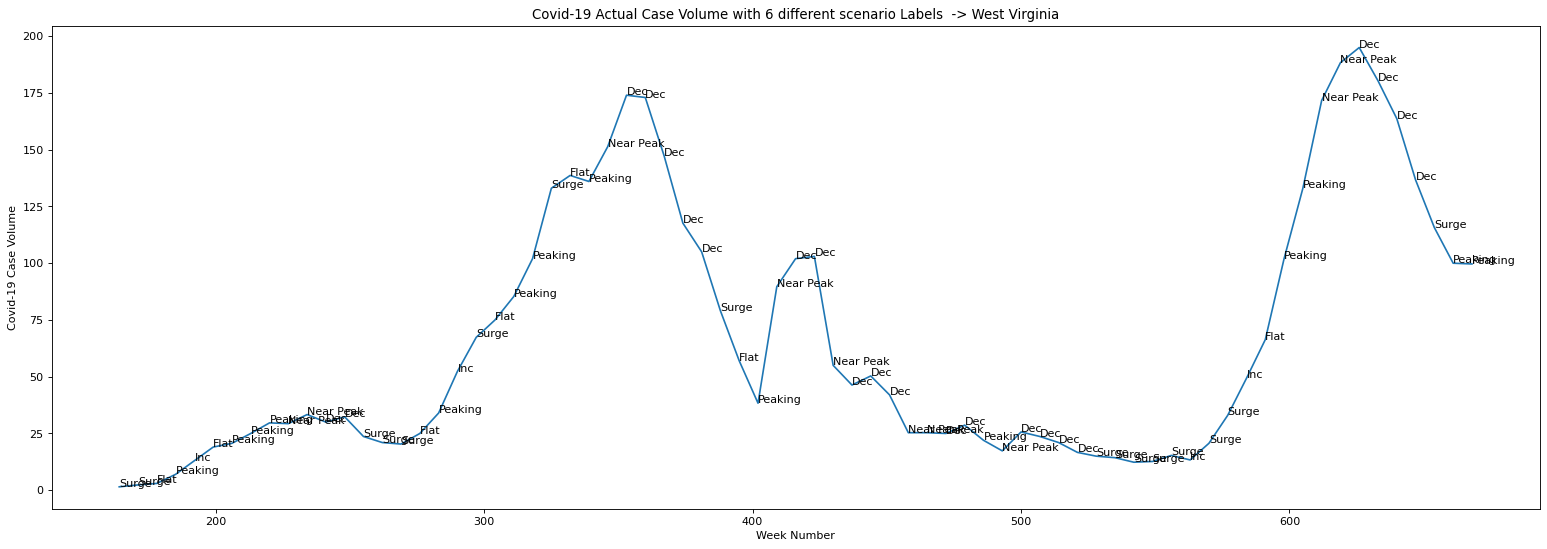

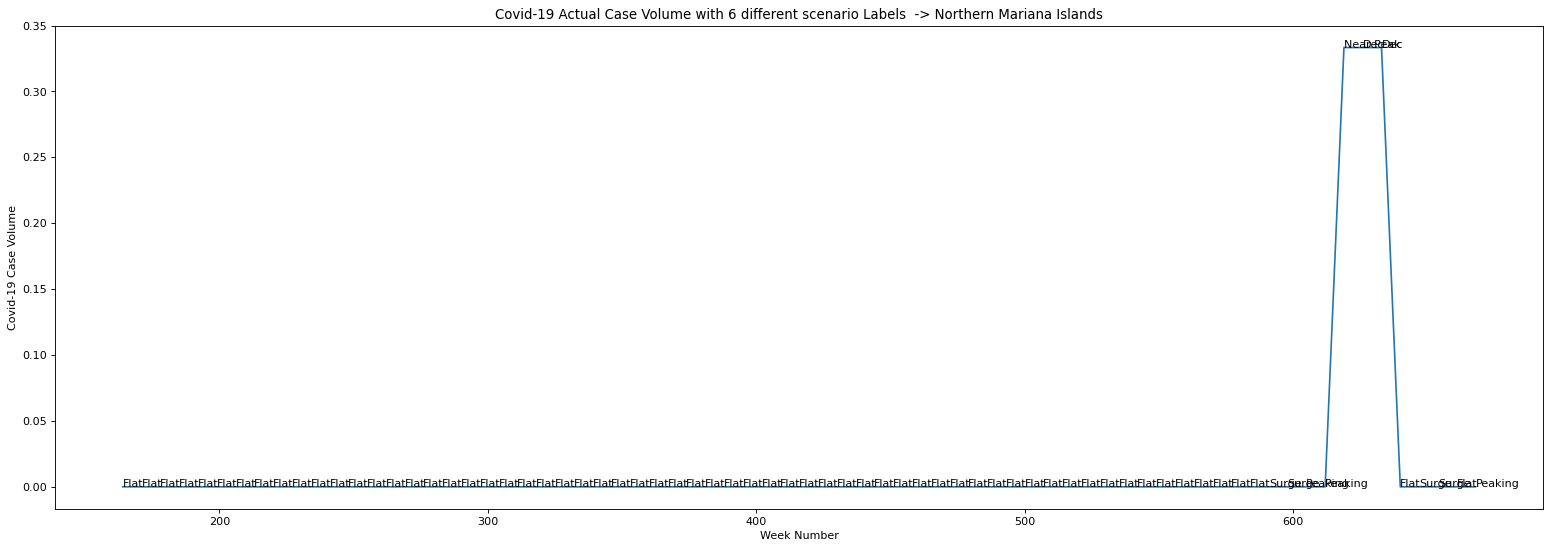

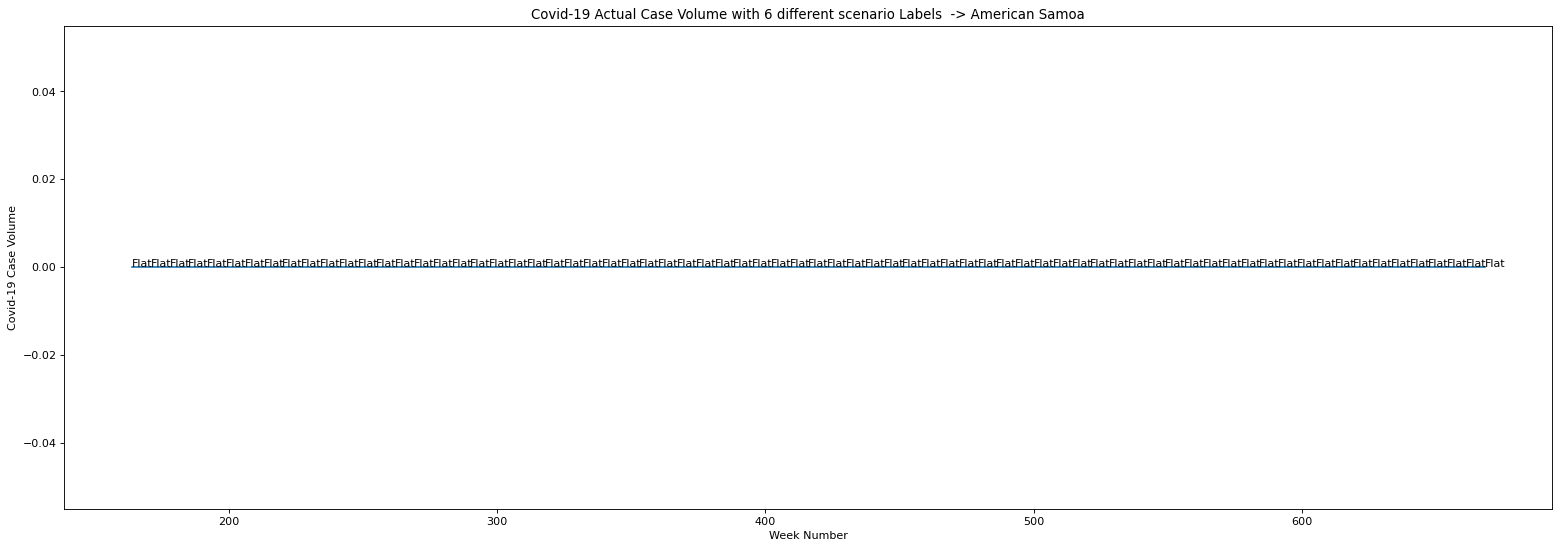

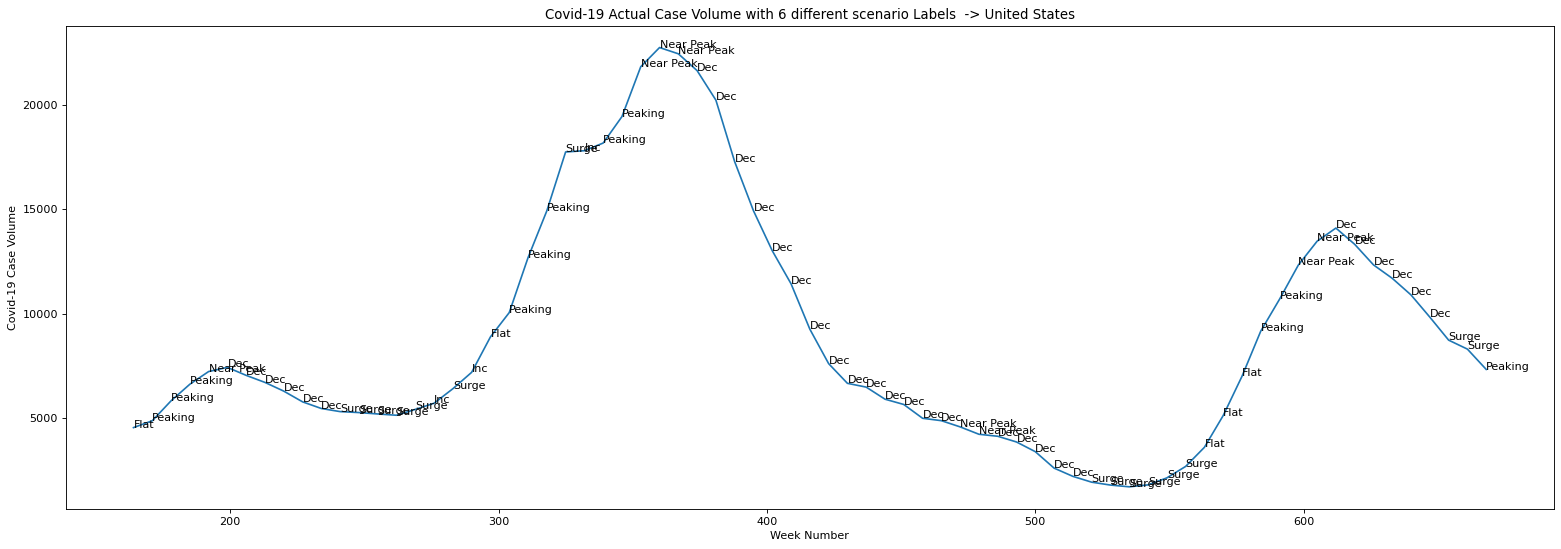

In [27]:
ShapeLet_Dictionary_State_level = {}

Shapelet_dict_actual_state_week_vector_label = {}

for keys in running_average.keys():
    print(keys)
    State_name = keys
    running_avg = running_average[State_name]



    running_avg_vectors = []
    for i in range(len(running_avg)):
        if i<len(running_avg)-4:
            vec = running_avg[i:i+5]
            vec1 = [w[1] for w in vec]

            week_nbr = vec[0][0]
            running_avg_vectors.append((week_nbr,vec1[0],vec1))

    dicy_state = Shapelet_dict_actual_state_week_vector_label.get(State_name,{})
#     print(dicy_state)
    
    scenarios_list_pearson_perason = [(vector[0],vector[1],return_best_shapelet_pearson(vector[2]),return_all_shapelet_pearson(vector[2])) for vector in running_avg_vectors]
    
    for vector in scenarios_list_pearson_perason:
        dicy_state[vector[0]] = [(vector[3],vector[2])]
    Shapelet_dict_actual_state_week_vector_label[State_name] = dicy_state
        

    ShapeLet_Dictionary_State_level[keys] = scenarios_list_pearson_perason

    ## Actual Covid tally plot validation 

    week_nbr_plt = [w[0] for w in scenarios_list_pearson_perason]
    actual_count_plt = [w[1] for w in scenarios_list_pearson_perason]
    labels_plt = [w[2] for w in scenarios_list_pearson_perason]


    from matplotlib.pyplot import figure
    import matplotlib.pyplot as plt
    import numpy as np


    figure(figsize=(24,8 ), dpi=80)
    plt.plot(week_nbr_plt,actual_count_plt)
    plt.xlabel("Week Number")
    plt.ylabel("Covid-19 Case Volume")
    plt.title("Covid-19 Actual Case Volume with 6 different scenario Labels  -> {}".format(State_name))
    for val in scenarios_list_pearson_perason:
        plt.text(val[0],val[1],val[2])

    #plt.savefig('Shapelet_results/Actual_Cases/Shapelets_actual_deaths_'+State_name+'.png')

In [28]:
import pickle

with open('Pickle_objects/ShapeLet_Dictionary_State_level_actual_deaths.pickle', 'wb') as handle:
    pickle.dump(ShapeLet_Dictionary_State_level, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
ShapeLet_Dictionary_State_level

{'Washington': [(164,
   56.5,
   'Surge',
   [0.9497868995728543,
    0.9497868997591873,
    -0.9497868997591873,
    0.989594876676507,
    0.8298213459200837,
    -0.989594876676507]),
  (171,
   55.0,
   'Flat',
   [0.9745831844410962,
    0.9745831841044724,
    -0.9745831841044724,
    0.8921317877993235,
    0.9690706835098661,
    -0.8921317877993235]),
  (178,
   65.0,
   'Peaking',
   [0.4865309752493834,
    0.4865309727899411,
    -0.4865309727899411,
    0.23415013227855047,
    0.6746792127582859,
    -0.23415013227855047]),
  (185,
   74.33333333333333,
   'Near Peak',
   [-0.5705622991250633,
    -0.5705623003517468,
    0.5705623003517468,
    -0.752588205517664,
    -0.32561052403060614,
    0.752588205517664]),
  (192,
   88.33333333333333,
   'Near Peak',
   [-0.9730489951439054,
    -0.9730489950025578,
    0.9730489950025578,
    -0.9760120113267041,
    -0.8824105576434563,
    0.9760120113267041]),
  (199,
   88.33333333333333,
   'Dec',
   [-0.9843371197295616

In [30]:
import pickle

with open('Pickle_objects/Shapelet_dict_actual_state_week_vector_label_deaths.pickle', 'wb') as handle:
    pickle.dump(Shapelet_dict_actual_state_week_vector_label, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Shapelet_dict_actual_state_week_vector_label['Washington']

## Load Models Data and apply Shapelets method on it

In [31]:
import glob,re

In [32]:
def sort_df_name(df_master1):
    df_master = df_master1.reset_index()
    week_names = [int(w) for w in list(df_master.columns[1:-1])]
    week_names.sort()
    cols= ['State']
    cols.extend(week_names)
    return df_master[cols]


In [33]:
root = glob.glob("/Users/satwant/Documents/GitHub/covid19-forecast-bench/formatted-forecasts/US-COVID/state-death/*")

In [34]:
model_lookup = {}


for l in root[:]:
    model_lookup1 = {}
#     try:
    df_master = pd.DataFrame()
#     print(l)
    
    subroot = glob.glob(l+"/*.csv")
    for k in subroot:
#         print(k)
#         print(k)
        df = pd.read_csv(k).fillna(0)
        
        US_total_1 = pd.DataFrame(df.sum(axis=0))

        df = pd.concat([df,US_total_1.T])
        df.loc[df["State"].str.len() > 100,"State"] = "United States"
#         print(df.tail())
#         impute = {}
#         impute['Country'] = {'WashingtonIllinoisCaliforniaArizonaMassachusettsWisconsinTexasNebraskaUtahOregonFloridaNew YorkRhode IslandGeorgiaNew HampshireNorth CarolinaNew JerseyColoradoMarylandNevadaTennesseeHawaiiIndianaKentuckyMinnesotaOklahomaPennsylvaniaSouth CarolinaDistrict of ColumbiaKansasMissouriVermontVirginiaConnecticutIowaLouisianaOhioMichiganSouth DakotaArkansasDelawareMississippiNew MexicoNorth DakotaWyomingAlaskaMaineAlabamaIdahoMontanaPuerto RicoVirgin IslandsGuamWest VirginiaNorthern Mariana IslandsAmerican Samoa':"United States"}

#         cases = cases.replace(impute)

#         break
#         print(k)
        
        temp = re.findall(r'\d+', k.split("/")[-1])[-1]
        
        res = temp
        model_lookup1[res] = df
    model_lookup[l.split("/")[-1]] = model_lookup1

In [35]:
print("Total Number of Models in Repository ---> {}".format(len(model_lookup.keys())))

Total Number of Models in Repository ---> 77


In [36]:
qualifying_threshold = 60

Eligible_Model_week_State_forecasts= {}

for key, val in model_lookup.items():
    if len(val)>qualifying_threshold:
        Eligible_Model_week_State_forecasts[key] = val

In [37]:
print("Total Number of Eligible Models in Repository ---> {}".format(len(Eligible_Model_week_State_forecasts.keys())))

Total Number of Eligible Models in Repository ---> 26


In [38]:
## Now I have data in hash table in format -- Model Name : { Week Number : next 4 weeks forecats for each state}

In [39]:
from scipy import spatial
def cosine_sim(dataSetI,dataSetII):
    
# dataSetI = [3, 45, 7, 2]
# dataSetII = [2, 54, 13, 15]
    return 1 - spatial.distance.cosine(dataSetI, dataSetII)

In [40]:
State_model_Week_vector_shapelet_Actual_dict = {}

model_wise_master_db =[]


model_cnt = 0


for key_outer,value_outer in Eligible_Model_week_State_forecasts.items():
#     if key_outer!='USC_SI_kJalpha':
#         continue
    model_lookup1 = value_outer
    iters = list(model_lookup1.keys())
    for key in iters:
#         if key!='327':
#             continue
        
        data = model_lookup1[key]
        cols = list(data.columns)
        
            
        start_index = cols.index("State")
        forecast_start = start_index+2
        forecast_end = forecast_start+4
        valid_columns = [cols[start_index]]+cols[forecast_start:forecast_end]
        if len(cols)<=6:
            valid_columns = [cols[start_index]]+cols[start_index+1:]
        forecast_input = data[valid_columns]
        state_iterations = list(forecast_input['State'].values)

        for state in state_iterations:
#             if state!='California':
#                 continue
            try:
                predictions_raw = forecast_input[forecast_input['State']==state][:].values[0][1:]
            except:
                print(key_outer,key,state)
                predictions_raw = forecast_input[forecast_input['State']=="Virgin Islands, U.S."][:].values[0][1:]
            week_num = int(key)
            mod = week_num%7
            target = 3
            add = target-mod
            lookup_key = add+week_num
            try:
                actual_covid_tally_records = Actual_covid_tally_dict[state]
            except:
                actual_covid_tally_records = Actual_covid_tally_dict["Virgin Islands"]
            week_num = int(key)
            mod = week_num%7
            target = 3
            add = target-mod

            lookup_key = add+week_num
            history1 = actual_covid_tally_records.get(lookup_key-7,None)
            predictions_vector_tmp = [history1]+list(predictions_raw) 
            predictions_vector_tmp_1 = predictions_vector_tmp[:-1]+[predictions_vector_tmp[-1]+0.00001]
            
#             try:
#             print(state,lookup_key,key_outer)
            if predictions_vector_tmp[0] is None:
                predictions_vector_tmp = [predictions_vector_tmp[1]]+predictions_vector_tmp[1:]
            
            if len(predictions_vector_tmp)<5:
                continue
#             print(lookup_key)
#             print(key)
#             print("Vector Used : ",predictions_vector_tmp)
            
            state_dict = State_model_Week_vector_shapelet_Actual_dict.get(state,{})
            
            state_dict_model_dict = state_dict.get(lookup_key,{})
            try:
                Actual_shapelte_5X1_vector = Shapelet_dict_actual_state_week_vector_label[state][lookup_key][0]
            except:
                Actual_shapelte_5X1_vector = [None,None,None,None,None,None]
            shape = return_best_shapelet_pearson(predictions_vector_tmp)
#             try:
            state_dict_model_dict[key_outer] = [((return_all_shapelet_pearson(predictions_vector_tmp),Actual_shapelte_5X1_vector,),shape)]
#             except:
                
            state_dict[lookup_key] = state_dict_model_dict
            
            State_model_Week_vector_shapelet_Actual_dict[state] = state_dict
#             print("Shape Predicted: ",shape)
            model_wise_master_db.append((state,lookup_key,key_outer,shape))
#             except:
#             print(state,lookup_key,key_outer,shape)


# 612 - USC - what



In [40]:
model_wise_master_db

[('Washington', 591, 'FH_RobertWalraven_ESG', 'Near Peak'),
 ('Illinois', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('California', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('Arizona', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('Massachusetts', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('Wisconsin', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('Texas', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('Nebraska', 591, 'FH_RobertWalraven_ESG', 'Surge'),
 ('Utah', 591, 'FH_RobertWalraven_ESG', 'Dec'),
 ('Oregon', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('Florida', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('New York', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('Rhode Island', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('Georgia', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('New Hampshire', 591, 'FH_RobertWalraven_ESG', 'Dec'),
 ('North Carolina', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('New Jersey', 591, 'FH_RobertWalraven_ESG', 'Peaking'),
 ('Colorado', 591, 'FH_RobertWalraven_ESG

In [ ]:
Shapelet_dict_actual_state_week_vector_label['California'][164][0]

In [ ]:
Shapelet_dict_actual_state_week_vector_label['California'].keys()

In [41]:
import pickle

with open('Pickle_objects/State_model_Week_vector_shapelet_Actual_dict_deaths.pickle', 'wb') as handle:
    pickle.dump(State_model_Week_vector_shapelet_Actual_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
Actual_covid_tuples = []

for key, val1 in ShapeLet_Dictionary_State_level.items():
    for val in val1:
        Actual_covid_tuples.append((key,val[0],val[1],val[2]))

In [43]:
Actual_covid_df = pd.DataFrame(Actual_covid_tuples)

In [44]:
Actual_covid_df.columns  = ['State','Week_number','Covid Count','Label_Actual']

In [45]:
Actual_covid_df['key'] = Actual_covid_df['State']+"_"+Actual_covid_df['Week_number'].astype("str")


In [46]:

model_wise_master_df = pd.DataFrame(model_wise_master_db)

model_wise_master_df.columns = ['State','Week Number','Model_Name','Predicted']

model_wise_master_df['key'] = model_wise_master_df['State']+"_"+model_wise_master_df['Week Number'].astype("str")


In [47]:

merged_df_models_actual = model_wise_master_df.merge(Actual_covid_df,how='inner',on='key')


In [48]:
pd.DataFrame([pairwise_dissimilairty]).T

0
(flat, stable_inc)          0.006007
(flat, stable_dec)          0.006007
(flat, surge)               0.010553
(flat, peaking)             0.115293
(flat, at_near_peak)        0.115293
(stable_inc, stable_dec)    0.022881
(stable_inc, surge)         0.001252
(stable_inc, peaking)       0.095993
(stable_inc, at_near_peak)  0.124593
(stable_dec, surge)         0.029852
(stable_dec, peaking)       0.124593
(stable_dec, at_near_peak)  0.095993
(surge, peaking)            0.090020
(surge, at_near_peak)       0.125845
(peaking, at_near_peak)     0.035825

In [49]:
print(Actual_covid_df['Label_Actual'].value_counts())

Dec          1340
Surge         912
Peaking       616
Near Peak     611
Flat          480
Inc           202
Name: Label_Actual, dtype: int64


In [50]:
print(model_wise_master_df['Predicted'].value_counts()/model_wise_master_df['Model_Name'].nunique())

Dec          1781.115385
Peaking       991.384615
Flat          396.000000
Near Peak     380.653846
Surge         378.384615
Inc           200.576923
Name: Predicted, dtype: float64


In [51]:
from sklearn.metrics import confusion_matrix
y_true = list(merged_df_models_actual['Label_Actual'].values)
y_pred = list(merged_df_models_actual['Predicted'].values)
confusion_matrix(y_true, y_pred)

array([[22224,   774,   396,  3069,  3872,  1726],
       [ 2150,  4484,   868,   597,  2746,  1227],
       [  866,   474,   714,   336,  2292,   631],
       [ 7093,   649,   336,  2164,  3413,   965],
       [ 3869,  1404,  1110,  1409,  6112,  1271],
       [ 8405,  2156,  1612,  1896,  6111,  3407]])

In [49]:
merged_df_models_actual.to_csv("../Data/Shapelet_model_evaluation_deaths.csv")

In [53]:
merged_df_models_actual

State_x  Week Number                 Model_Name  Predicted  \
0          Washington          591      FH_RobertWalraven_ESG  Near Peak   
1          Washington          591               FH_PSI_DRAFT        Inc   
2          Washington          591             FH_CU_nochange  Near Peak   
3          Washington          591  FH_epiforecasts_ensemble1    Peaking   
4          Washington          591         FH_CU_scenario_low  Near Peak   
...               ...          ...                        ...        ...   
102823  United States          626        FH_BPagano_RtDriven        Dec   
102824  United States          626       FH_COVIDhub_ensemble        Dec   
102825  United States          626       FH_MIT_CritData_GBCF        Dec   
102826  United States          626   FH_CovidAnalytics_DELPHI        Dec   
102827  United States          626      FH_UCSD_NEU_DeepGLEAM        Dec   

                      key        State_y  Week_number   Covid Count  \
0          Washington_591     Washington          591    187.333333   
1          Washington_591     Washington          591    187.333333   
2          Washington_591     Washington          591    187.333333   
3          Washington_591     Washington          591    187.333333   
4          Washington_591     Washington          591    187.333333   
...                   ...            ...          ...           ...   
102823  United States_626  United States          626  12339.000000   
102824  United States_626  United States          626  12339.000000   
102825  United States_626  United States          626  12339.000000   
102826  United States_626  United States          626  12339.000000   
102827  United States_626  United States          626  12339.000000   

       Label_Actual  
0           Peaking  
1           Peaking  
2           Peaking  
3           Peaking  
4           Peaking  
...             ...  
102823          Dec  
102824          Dec  
102825          Dec  
102826          Dec  
102827          Dec  

[102828 rows x 9 columns]

In [50]:


State_weel_ScenarioWise = merged_df_models_actual.groupby(['State_x',"Week Number","Predicted","Label_Actual"]).agg(Count = ("Week_number","count")).reset_index()




State_week_rolllup = merged_df_models_actual.groupby(['State_x',"Week Number","Label_Actual"]).agg(Count_overall = ("Week_number","count"),Covid_case_count= ("Covid Count","sum")).reset_index()


Summarized_Results = State_weel_ScenarioWise.merge(State_week_rolllup,on=['State_x','Week Number'],how="inner").drop(["Label_Actual_y"],axis=1)


Summarized_Results['Probability of Class'] = Summarized_Results['Count']/Summarized_Results['Count_overall']


In [51]:

Summarized_Results["rank"] = Summarized_Results.groupby(["State_x","Week Number"])["Probability of Class"].rank("dense", ascending=False)


In [52]:
plot_results_softmax = Summarized_Results[Summarized_Results['rank']==1]

In [53]:
State_Iteration = list(plot_results_softmax.State_x.unique())

In [ ]:
# for state in State_Iteration:

#     subset_data = plot_results_softmax[plot_results_softmax['State_x']==state]











#     subset_data
#     Actual_Case_cnt = (subset_data['Covid_case_count']/subset_data['Count_overall']).to_list()

#     Predicted_label = subset_data['Predicted'].to_list()

#     Actual_Label = subset_data['Label_Actual_x'].to_list()

#     Week_nbr = subset_data['Week Number'].to_list()

#     fig, axs = plt.subplots(2,figsize=(25,16 ), dpi=80)

#     #figure(figsize=(30,8 ), dpi=80)


#     axs[0].plot(Week_nbr,Actual_Case_cnt)

#     axs[0].set(xlabel="Week", ylabel="Covid Case Count")

#     axs[0].set_title("Actual Case Volume Plotted with Label --> "+state)

#     for val in list(zip(Week_nbr,Actual_Case_cnt,Actual_Label)):
#         axs[0].text(val[0],val[1],val[2])


#     axs[1].plot(Week_nbr,Actual_Case_cnt)

#     axs[1].set(xlabel="Week", ylabel="Covid Case Count")

#     axs[1].set_title("Actual Case Volume Plotted with SoftMax Predicted Label --> "+state)

#     for val in list(zip(Week_nbr,Actual_Case_cnt,Predicted_label)):
#         axs[1].text(val[0],val[1],val[2])


#     plt.savefig('Shapelet_results/ActualVsModels_Cases/Shapelets_actual_predicted_'+state+'.png')

#     # plt.show()

#     # plt.savefig('graphs/Shapelets_actual_covidtally_Pearson.png')

#     # plt.show()


In [58]:
import pandas as pd

In [61]:
# merged_df_models_actual = pd.read_csv("../Data/Shapelet_model_evaluation_death.csv")

Traditional multi-class evaluation without acknowledging the similarity between classes
Accuracy for each model's evaluation
Model disagreement using the entropy of distribution: Collect the fraction of models that predict each class (should sum to 1). Then calculate the entropy.
Remember to add majority vote model
Confusion matrices of majority vote model, covid hub ensembles (there are several variations)

## [Generalization of the above] Since our classes are related, we can do the following
Find the similarity of the ground truth with our shapelets. This will give us a vector
Find the similarity of the model forecasts with our shapelets. This will give us another vector
Take the cosine similarity between the two (negative inputs are okay!). The similarity between the classes will be inherently captured
Take the mean of pairwise cosine similarity between the models. This will give us the agreement between models
Add another "model" whose vector output is the mean of the model vectors. This is analogous to the majority classifier.
Do the above for cases and deaths
## Plots
agreement over time on California and US total
## [generalized version only]
evaluations over time for California and US total for selected models: At least have our "majority" classifier and covid-hub ensembles. 


In [54]:
Master_df_actual_VS_Model_Agrrement = pd.DataFrame()

a = set()
for State_name in State_model_Week_vector_shapelet_Actual_dict.keys():



    State_Week_Model_name_Cosine_match_cases = {}
    # State_name = 'California'



    # California_debug_actual = Shapelet_dict_actual_state_week_vector_label[State_name]

    California_debug_model =  State_model_Week_vector_shapelet_Actual_dict[State_name]


    generate_tuple = []

    state_dict = State_Week_Model_name_Cosine_match_cases.get(State_name,{})


    for weeks, model_level in California_debug_model.items():
#         if weeks>585:
#             continue
        week_dict = state_dict.get(weeks,{})
        
        

        for model,data_vector in model_level.items():
#             if model!='FH_COVIDhub_ensemble':
#                 pass
    #         print(data_vector)
            datset1 = data_vector[0][0][0]
            dataset2 = data_vector[0][0][1][0]
    #         print(data_vector[0][0][1][1])
    #         print(data_vector[0][1])
            model_val = week_dict.get(model,None)
            if model_val is None:
                try:
                    week_dict[model] =(data_vector[0][1],data_vector[0][0][1][1],round(cosine_sim(datset1,dataset2),4))

                    generate_tuple.append([weeks,model,data_vector[0][1],data_vector[0][0][1][1],round(cosine_sim(datset1,dataset2),4)])
        #             print()
        #             print(weeks,model,cosine_sim(datset1,dataset2))
                except:
                    print(weeks)
                    a.add(weeks)

                    pass
    #                 print(weeks,model,dataset2)
        state_dict[weeks] = week_dict

    State_Week_Model_name_Cosine_match_cases[State_name] = state_dict

    Model_actual_cosine_Agrremen_df = pd.DataFrame(generate_tuple)


    Model_actual_cosine_Agrremen_df.columns = ['Week Number',"Model Name","Predicted Label","True Label","Cosine Similarty"]
    
    Model_actual_cosine_Agrremen_df['State'] = State_name

    Master_df_actual_VS_Model_Agrrement = pd.concat([Master_df_actual_VS_Model_Agrrement,Model_actual_cosine_Agrremen_df],axis=0)
    

689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
689
689
689
689
689
689
689
689
689
689
689
689
689


696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
696
696
696
696
696
696
696
696
696
696
696
696
696


689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
689
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
682
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
696
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675
675


In [ ]:
[w for w in generate_tuple if w[1]=='FH_COVIDhub_ensemble']

In [55]:
Master_df_actual_VS_Model_Agrrement.to_csv("../Data/Shapelet_model_evaluation_cases_cosine_modelVS_Actual_deaths.csv")

In [56]:
Master_df_actual_VS_Model_Agrrement

Week Number                 Model Name Predicted Label True Label  \
0             591      FH_RobertWalraven_ESG       Near Peak    Peaking   
1             591               FH_PSI_DRAFT             Inc    Peaking   
2             591             FH_CU_nochange       Near Peak    Peaking   
3             591  FH_epiforecasts_ensemble1         Peaking    Peaking   
4             591         FH_CU_scenario_low       Near Peak    Peaking   
...           ...                        ...             ...        ...   
1620          626        FH_BPagano_RtDriven             Dec        Dec   
1621          626       FH_COVIDhub_ensemble             Dec        Dec   
1622          626       FH_MIT_CritData_GBCF             Dec        Dec   
1623          626   FH_CovidAnalytics_DELPHI             Dec        Dec   
1624          626      FH_UCSD_NEU_DeepGLEAM             Dec        Dec   

      Cosine Similarty          State  
0              -0.7425     Washington  
1               0.9932     Washington  
2              -0.9291     Washington  
3               0.9982     Washington  
4              -0.9291     Washington  
...                ...            ...  
1620            0.9951  United States  
1621            0.9971  United States  
1622            0.9457  United States  
1623            0.9992  United States  
1624            0.9983  United States  

[92625 rows x 6 columns]

In [57]:
Master_df_actual_VS_Model_Agrrement


MeanSimilarityModels_Actual = Master_df_actual_VS_Model_Agrrement.groupby(['State','Week Number']).agg(Mean_Similarity=("Cosine Similarty","mean")).reset_index()


In [58]:

best_model_label_df = Master_df_actual_VS_Model_Agrrement.groupby(['True Label','Model Name']).agg(Mean_Score=("Cosine Similarty","mean")).reset_index()


In [59]:
best_model_label_df

True Label                 Model Name  Mean_Score
0          Dec        FH_BPagano_RtDriven    0.639743
1          Dec               FH_CEID_Walk    0.362674
2          Dec       FH_COVIDhub_baseline    0.319496
3          Dec       FH_COVIDhub_ensemble    0.735389
4          Dec             FH_CU_nochange    0.761300
..         ...                        ...         ...
151      Surge      FH_UCSD_NEU_DeepGLEAM    0.145577
152      Surge         FH_UMass_MechBayes    0.302606
153      Surge  FH_epiforecasts_ensemble1    0.208933
154      Surge             USC_SI_kJalpha    0.385666
155      Surge            YYG_ParamSearch    0.108172

[156 rows x 3 columns]

In [60]:
MeanSimilarityModels_Actual

State  Week Number  Mean_Similarity
0     Alabama          164         0.270745
1     Alabama          171         0.513633
2     Alabama          178        -0.372000
3     Alabama          185        -0.461293
4     Alabama          192         0.418271
...       ...          ...              ...
4156  Wyoming          640         0.300805
4157  Wyoming          647         0.887033
4158  Wyoming          654        -0.508555
4159  Wyoming          661         0.399414
4160  Wyoming          668        -0.830543

[4161 rows x 3 columns]

## NC2 conbinations for checking agreement between models

In [61]:
Master_df_Model_VS_Model_Agrrement = pd.DataFrame()

for State_name in State_model_Week_vector_shapelet_Actual_dict.keys():



    State_Week_Model_name_Cosine_match_cases = {}
    # State_name = 'California'



    # California_debug_actual = Shapelet_dict_actual_state_week_vector_label[State_name]

    California_debug_model =  State_model_Week_vector_shapelet_Actual_dict[State_name]


    generate_tuple = []

    state_dict = State_Week_Model_name_Cosine_match_cases.get(State_name,{})


    for weeks, model_level in California_debug_model.items():
#         if weeks>585:
#             continue
        week_dict = state_dict.get(weeks,{})
        
        

        for model1,data_vector1 in model_level.items():
            for model2,data_vector2 in model_level.items():
                
            
    #         print(data_vector)
                datset1 = data_vector1[0][0][0]
                dataset2 = data_vector2[0][0][1][0]
    #             model_val = week_dict.get(model,None)
    #             if model_val is None:
        #             try:
    #             week_dict[model] =(data_vector[0][1],data_vector[0][0][1][1],round(cosine_sim(datset1,dataset2),4))
                try:
                    if dataset2 is not None:
                        if datset1 is not None:
                            if model1!=model2:

                                if model1>model2:
                                    generate_tuple.append([weeks,model1,model2,round(cosine_sim(datset1,dataset2),4)])
                                else:
                                    generate_tuple.append([weeks,model2,model1,round(cosine_sim(datset1,dataset2),4)])
                except:
                    print([weeks,model2,model1,datset1,dataset2])
        #             print()
        #             print(weeks,model,cosine_sim(datset1,dataset2))
    #             except:

    #                 pass
    #                 print(weeks,model,dataset2)
#         state_dict[weeks] = week_dict

#     State_Week_Model_name_Cosine_match_cases[State_name] = state_dict

    Model_actual_cosine_Agrremen_df = pd.DataFrame(generate_tuple)


    Model_actual_cosine_Agrremen_df.columns = ['Week Number',"Model Name1","Model Name2","Cosine Similarty"]
    
    Model_actual_cosine_Agrremen_df['State'] = State_name

    Master_df_Model_VS_Model_Agrrement = pd.concat([Master_df_Model_VS_Model_Agrrement,Model_actual_cosine_Agrremen_df],axis=0)
    

In [62]:
Master_df_Model_VS_Model_Agrrement = Master_df_Model_VS_Model_Agrrement.drop_duplicates()

In [63]:

MeanSimilarityModels = Master_df_Model_VS_Model_Agrrement.groupby(['State','Week Number']).agg(Mean_Similarity=("Cosine Similarty","mean")).reset_index()


In [64]:
MeanSimilarityModels.to_csv("../Data/MeanSimilarity_within_models_deaths.csv")

In [65]:
MeanSimilarityModels_Actual

State  Week Number  Mean_Similarity
0     Alabama          164         0.270745
1     Alabama          171         0.513633
2     Alabama          178        -0.372000
3     Alabama          185        -0.461293
4     Alabama          192         0.418271
...       ...          ...              ...
4156  Wyoming          640         0.300805
4157  Wyoming          647         0.887033
4158  Wyoming          654        -0.508555
4159  Wyoming          661         0.399414
4160  Wyoming          668        -0.830543

[4161 rows x 3 columns]

In [ ]:
for state in State_Iteration:

    subset_data = plot_results_softmax[plot_results_softmax['State_x']==state]
    Actual_Case_cnt = (subset_data['Covid_case_count']/subset_data['Count_overall']).to_list()

    Predicted_label = subset_data['Predicted'].to_list()

    Actual_Label = subset_data['Label_Actual_x'].to_list()

    Week_nbr = subset_data['Week Number'].to_list()

    fig, axs = plt.subplots(4,figsize=(25,32 ), dpi=80)

    #figure(figsize=(30,8 ), dpi=80)


    axs[0].plot(Week_nbr,Actual_Case_cnt)

    axs[0].set(xlabel="Week", ylabel="Covid Case Count")

    axs[0].set_title("Actual Case Volume Plotted with Label --> "+state)

    for val in list(zip(Week_nbr,Actual_Case_cnt,Actual_Label)):
        axs[0].text(val[0],val[1],val[2])


    axs[1].plot(Week_nbr,Actual_Case_cnt)

    axs[1].set(xlabel="Week", ylabel="Covid Case Count")

    axs[1].set_title("Actual Case Volume Plotted with SoftMax Predicted Label --> "+state)

    for val in list(zip(Week_nbr,Actual_Case_cnt,Predicted_label)):
        axs[1].text(val[0],val[1],val[2])

        
    subset = MeanSimilarityModels[MeanSimilarityModels['State']==state]

    week_nbrs = subset['Week Number'].values

    meanS_miliary = subset['Mean_Similarity'].values
    
    axs[2].plot(week_nbrs,meanS_miliary)
    axs[2].set(xlabel="Week", ylabel="Mean Similarity between Models")

    axs[2].set_title("Mean Similarity Value for Models --> "+state)
    
    subset = MeanSimilarityModels_Actual[MeanSimilarityModels_Actual['State']==state]

    week_nbrs = subset['Week Number'].values

    meanS_miliary = subset['Mean_Similarity'].values
    
    axs[3].plot(week_nbrs,meanS_miliary)
    axs[3].set(xlabel="Week", ylabel="Mean Similarity of Models with Actual Week vector")

    axs[3].set_title("Mean Similarity Value for Models with Actual --> "+state)


    plt.savefig('Shapelet_results/meanSimilarity_model_Actual/Shapelets_actual_predicted_mean_model_Actual_Deaths'+state+'.png')



In [ ]:

MeanSimilarityModels_Actual

In [ ]:
state_lst = ['California','United States']

for state in state_lst:
    if state not in ['California','United States']:
        continue
    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    for model in list(subset['Model Name'].values):
        fig, axs = plt.subplots(2,figsize=(25,16 ), dpi=80)
    
    
    
        subset_data = plot_results_softmax[plot_results_softmax['State_x']==state]
        Actual_Case_cnt = (subset_data['Covid_case_count']/subset_data['Count_overall']).to_list()

        Predicted_label = subset_data['Predicted'].to_list()

        Actual_Label = subset_data['Label_Actual_x'].to_list()

        Week_nbr = subset_data['Week Number'].to_list()
        
#         print(len(Week_nbr))

        axs[0].plot(Week_nbr,Actual_Case_cnt)

        axs[0].set(xlabel="Week", ylabel="Covid Case Count")

        axs[0].set_title("Actual Case Volume Plotted with Label --> "+state)

        for val in list(zip(Week_nbr,Actual_Case_cnt,Actual_Label)):
            axs[0].text(val[0],val[1],val[2])

        

        subset1 = subset[subset['Model Name']==model]
        week_nbrs = subset1['Week Number'].values

        meanS_miliary = subset1['Cosine Similarty'].values
        vectors = list(zip(week_nbrs,meanS_miliary))

        vector_sorted = sorted(vectors,key = lambda x : x[0]) 

        x = [w[0] for w in vector_sorted if w[0] in Week_nbr]
        y = [w[1] for w in vector_sorted if w[0] in Week_nbr]

#         print(len(Week_nbr))
#         week_nbrs = list(qa1['Week Number'].values)

#         meanS_miliary = list(qa1['Cosine Similarty'].values)
#         figure(figsize=(30,8 ), dpi=80)

#         plt.plot(x,y)

# plt.xticks()


        axs[1].plot(x,y)

        axs[1].set(xlabel="Week", ylabel="Cosine Similarity")

        axs[1].set_title("Cosine Similarity Between Model {} and Actual Data for State {}".format(model,state))
#         plt.show()

        plt.savefig('Shapelet_results/Cali_US_model_wise_cases/Shapelets_actual_predicted_modelwise_Actual_Model_'+model+'_'+state+'.png')


## Ensemble Model Generation using mean pearson Vector



In [80]:
State_model_Week_vector_shapelet_Actual_dict['California']

{591: {'FH_RobertWalraven_ESG': [(([-0.9274999777106016,
      -0.9274999776956827,
      0.9274999776956827,
      -0.8132193297257309,
      -0.9865751008777872,
      0.8132193297257309],
     ([-0.9921899718272235,
       -0.9921899714303971,
       0.9921899714303971,
       -0.9315219734639468,
       -0.9761169944550541,
       0.9315219734639468],
      'Dec')),
    'Dec')],
  'FH_CU_nochange': [(([-0.8911324390326025,
      -0.891132438922905,
      0.891132438922905,
      -0.762137042658803,
      -0.972303609181304,
      0.762137042658803],
     ([-0.9921899718272235,
       -0.9921899714303971,
       0.9921899714303971,
       -0.9315219734639468,
       -0.9761169944550541,
       0.9315219734639468],
      'Dec')),
    'Dec')],
  'FH_CU_scenario_low': [(([-0.8581868998622849,
      -0.8581868995602386,
      0.8581868995602386,
      -0.7088692032440151,
      -0.9607406784792986,
      0.7088692032440151],
     ([-0.9921899718272235,
       -0.9921899714303971,
      

In [66]:
State_week_avg_ensemble = {}
for state in ['California','United States']:
    Week_averge_cosine = {}

    for key, vale in State_model_Week_vector_shapelet_Actual_dict[state].items():
        vec1 = []
    #     actual_vec = []

        for k1,v1 in vale.items():
    #         print(v1)
    #         print(v1[0][0][0])
            vec1.append(v1[0][0][0])
            actual_vec = v1[0][0][1][0]
        denom = len(vec1)

        a = (sum([w[0] for w in vec1]))/denom
        b = (sum([w[1] for w in vec1]))/denom
        c=(sum([w[2] for w in vec1]))/denom
        d=(sum([w[3] for w in vec1]))/denom
        e=(sum([w[4] for w in vec1]))/denom
        f=(sum([w[5] for w in vec1]))/denom
        try:
            Week_averge_cosine[key] = cosine_sim(actual_vec,[a,b,c,d,e,f])
        except:
            print(key)
    State_week_avg_ensemble[state] =Week_averge_cosine 



689
682
696
675
689
682
696
675


In [67]:
def date_formatting(week_nbr):
# week_nbr = 164
    t = 'Jan 22 2020'
    format = '%b %d %Y'
    now = datetime.strptime(t,format)
    after = now + timedelta(days = int(week_nbr))
    return after.date().strftime("%m/%d/%Y")

In [76]:
Master_df_actual_VS_Model_Agrrement['Model Name'].unique()

array(['FH_RobertWalraven_ESG', 'FH_PSI_DRAFT', 'FH_CU_nochange',
       'FH_epiforecasts_ensemble1', 'FH_CU_scenario_low',
       'FH_JHUAPL_Bucky', 'FH_SteveMcConnell_CovidComplete',
       'FH_GT_DeepCOVID', 'FH_JHU_IDD_CovidSP', 'FH_CU_scenario_mid',
       'FH_UMass_MechBayes', 'FH_COVIDhub_baseline', 'FH_TTU_squider',
       'FH_Karlen_pypm', 'FH_MOBS_GLEAM_COVID', 'FH_CEID_Walk',
       'FH_DDS_NBDS', 'USC_SI_kJalpha', 'FH_BPagano_RtDriven',
       'FH_COVIDhub_ensemble', 'FH_CU_select', 'FH_MIT_CritData_GBCF',
       'FH_LANL_GrowthRate', 'FH_CovidAnalytics_DELPHI',
       'FH_UCSD_NEU_DeepGLEAM', 'YYG_ParamSearch'], dtype=object)

In [77]:
state = "California"
subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
subset_1 = subset[subset['Model Name']=='FH_COVIDhub_ensemble']


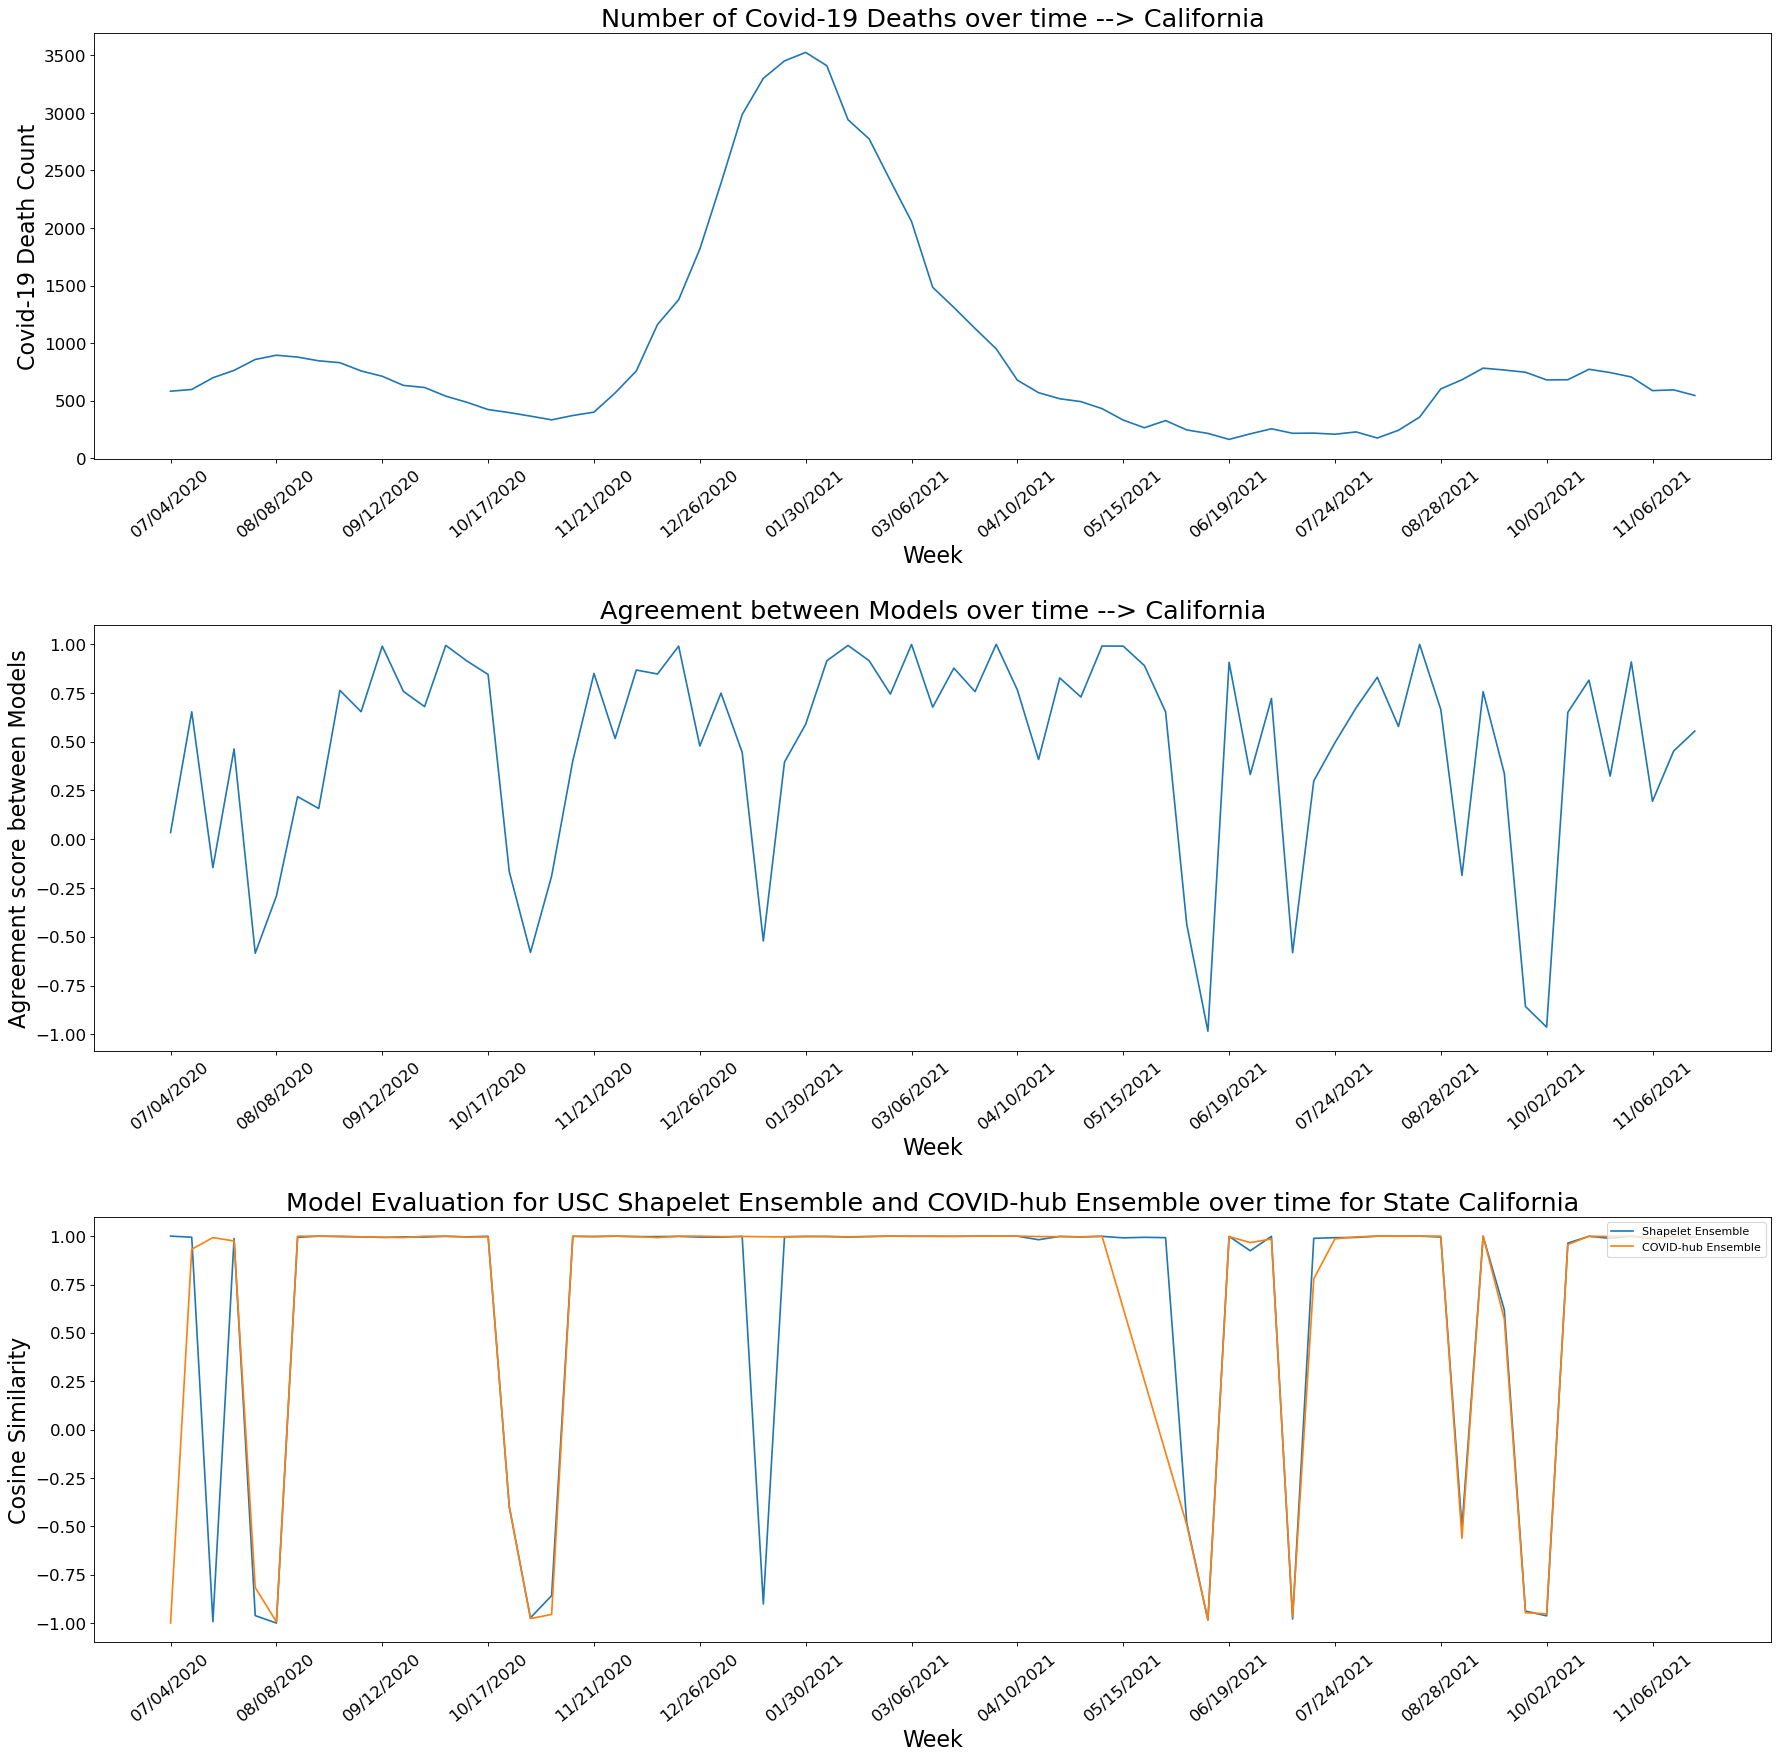

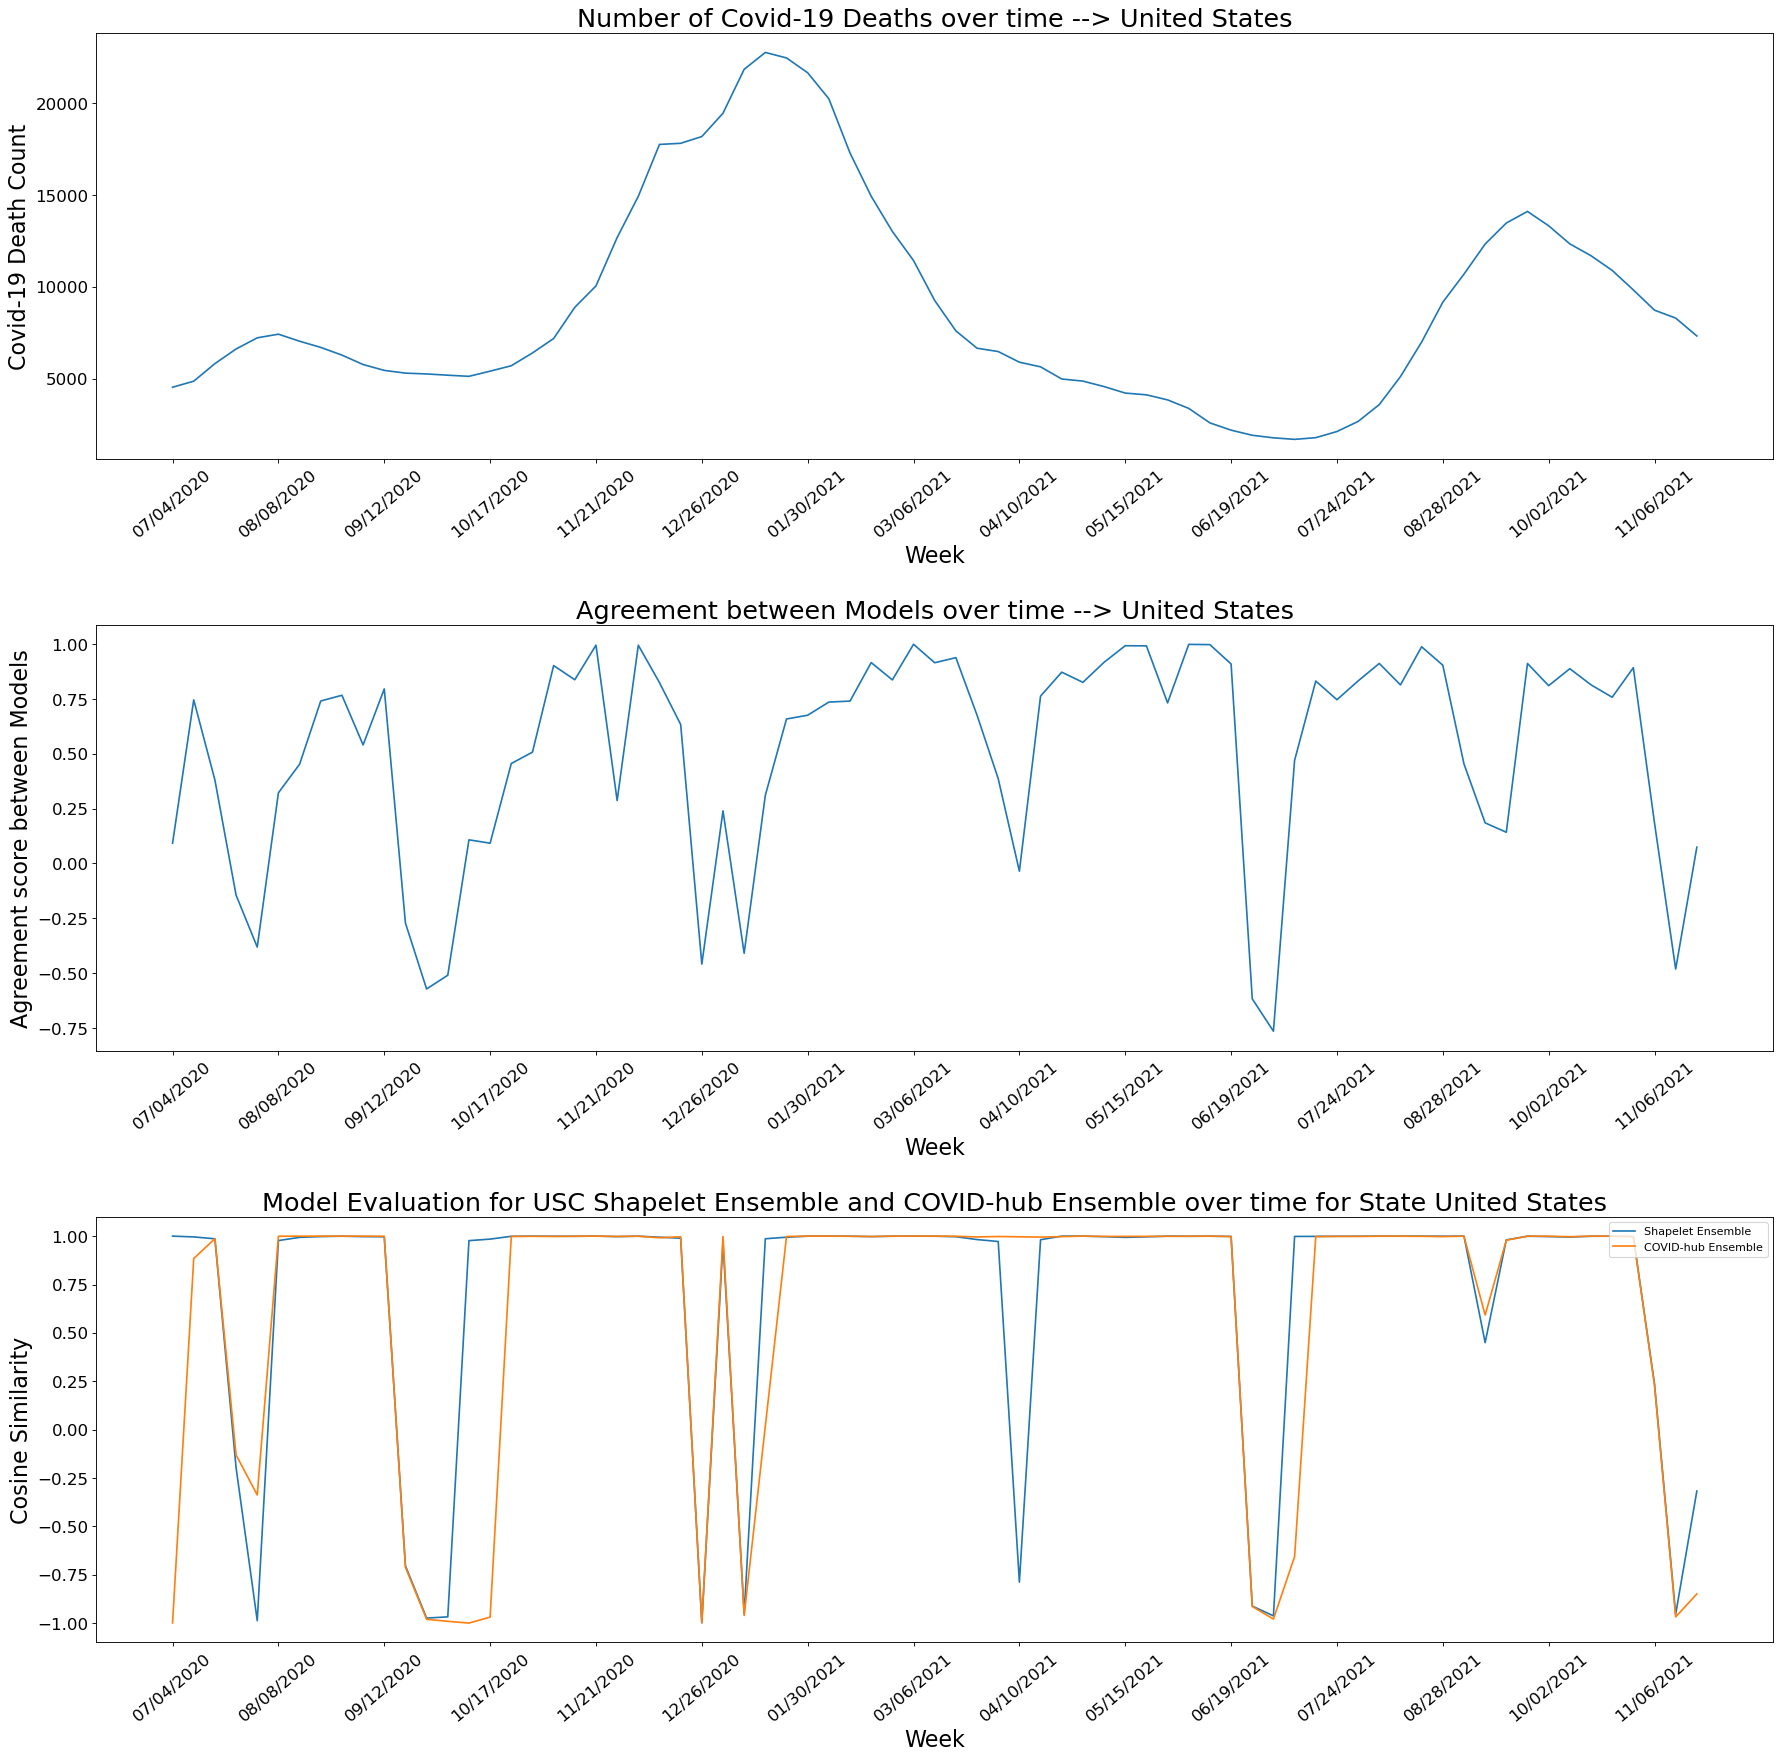

In [68]:
state_lst = ['California','United States']

for state in state_lst:
    model = "USC shapelet-ensemble"
#     if state not in ['California','United States']:
#         continue
    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    fig, axs = plt.subplots(3,figsize=(25,24 ), dpi=80)

    fig.tight_layout(pad=13.0)

    subset_data = plot_results_softmax[plot_results_softmax['State_x']==state].drop_duplicates(['Week Number','Label_Actual_x'])
    Actual_Case_cnt = (subset_data['Covid_case_count']/subset_data['Count_overall']).to_list()

    Predicted_label = subset_data['Predicted'].to_list()

    Actual_Label = subset_data['Label_Actual_x'].to_list()

    Week_nbr = subset_data['Week Number'].to_list()
    str_week_int = []
    str_week = []
    for i in range(0,len(Week_nbr),5):
        str_week_int.append(Week_nbr[i])
        str_week.append(date_formatting(Week_nbr[i]))

#         print(len(Week_nbr))

    axs[0].plot(Week_nbr,Actual_Case_cnt)
    axs[0].set_xlabel('Week', fontsize = 20)
    axs[0].set_ylabel('Covid-19 Death Count', fontsize = 20)
    
#     axs[0].set(xlabel="Week", ylabel="Covid Case Count")

    axs[0].set_title("Number of Covid-19 Deaths over time --> "+state,fontsize=23)
    axs[0].set_xticks(str_week_int)
    axs[0].set_xticklabels(str_week,rotation=40,fontsize=15)
    axs[0].yaxis.set_tick_params(labelsize=15)
#     axs[0].set_yticklabels(fontsize=13)
#     axs[0].set_yticks(Actual_Case_cnt)
#     axs[0].set_yticklabels(Actual_Case_cnt,fontsize=13)
    
    
    subset = MeanSimilarityModels[MeanSimilarityModels['State']==state]

    week_nbrs = list(subset['Week Number'].values)

    meanS_miliary = subset['Mean_Similarity'].values
    
    axs[1].plot(week_nbrs,meanS_miliary)
    axs[1].set_xlabel('Week', fontsize = 20)
    axs[1].set_ylabel('Agreement score between Models', fontsize = 20)

#     axs[1].set(xlabel="Week Number", ylabel="Agreement score between Models")

    axs[1].set_title("Agreement between Models over time --> "+state,fontsize=23)
    
    str_week_int = []
    str_week = []
    for i in range(0,len(week_nbrs),5):
        str_week_int.append(week_nbrs[i])
        str_week.append(date_formatting(week_nbrs[i]))
    axs[1].set_xticks(str_week_int)
    axs[1].set_xticklabels(str_week,rotation=40,fontsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)
    
    

#     for val in list(zip(Week_nbr,Actual_Case_cnt,Actual_Label)):
#         axs[0].text(val[0],val[1],val[2])
#     fig.tight_layout(pad=10.0)

#     axs[0].set_xticks(str_week_int)
#     axs[0].set_xticklabels(str_week,rotation=40)

    data = State_week_avg_ensemble.get(state)
    
    x1 = []
    y1 = []
    for k,v in data.items():
        x1.append(k)
        y1.append(v)

    vectors = list(zip(x1,y1))

    vector_sorted = sorted(vectors,key = lambda x : x[0]) 

    x1 = [w[0] for w in vector_sorted ]
    y = [w[1] for w in vector_sorted ]
    Week_nbr = x1

    usc = axs[2].plot(x1,y,label='Shapelet Ensemble')

    str_week_int = []
    str_week = []
    for i in range(0,len(Week_nbr),5):
        str_week_int.append(Week_nbr[i])
        str_week.append(date_formatting(Week_nbr[i]))
    axs[2].set_xticks(str_week_int)
    axs[2].set_xticklabels(str_week,rotation=40,fontsize=15)
    axs[2].yaxis.set_tick_params(labelsize=15)

    axs[2].set_xlabel('Week', fontsize = 20)
    axs[2].set_ylabel('Cosine Similarity', fontsize = 20)
    
    
#     usc = axs[2].set(xlabel="Week", ylabel="Cosine Similarity",label = "USC Shapelet Ensemble")

    axs[2].set_title("Model Evaluation for USC Shapelet Ensemble and COVID-hub Ensemble over time for State {}".format(state),fontsize=23)
#         plt.show()

    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    subset_1 = subset[subset['Model Name']=='FH_COVIDhub_ensemble']
    
    x1 = subset_1['Week Number'].values
    
    y1 = subset_1['Cosine Similarty'].values
    
    
    vectors = list(zip(x1,y1))

    vector_sorted = sorted(vectors,key = lambda x : x[0]) 

    x = [w[0] for w in vector_sorted ]
    y = [w[1] for w in vector_sorted ]
    Week_nbr = x

    ensemble  = axs[2].plot(x,y,label="COVID-hub Ensemble")
#     axs[2].legend((usc,ensemble),('Perfis COPEX','Media'), loc = 'best')
    leg1 = axs[2].legend(loc='upper right')

#     str_week_int = []
#     str_week = []
#     for i in range(0,len(Week_nbr),5):
#         str_week_int.append(Week_nbr[i])
#         str_week.append(date_formatting(Week_nbr[i]))
#     axs[3].set_xticks(str_week_int)
#     axs[3].set_xticklabels(str_week,rotation=40)

    
#     axs[2].set(xlabel="Week", ylabel="Cosine Similarity")

#     axs[2].set_title("Agreement between Model : FH_COVIDhub_ensemble and Incident Data for State {}".format(state))
    
    

#     subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
#     subset_1 = subset[subset['Model Name']=='USC_SI_kJalpha']
    
#     x1 = subset_1['Week Number'].values
    
#     y1 = subset_1['Cosine Similarty'].values
    
    
#     vectors = list(zip(x1,y1))

#     vector_sorted = sorted(vectors,key = lambda x : x[0]) 

#     x = [w[0] for w in vector_sorted ]
#     y = [w[1] for w in vector_sorted ]
#     Week_nbr = x

#     axs[3].plot(x,y)

#     str_week_int = []
#     str_week = []
#     for i in range(0,len(Week_nbr),5):
#         str_week_int.append(Week_nbr[i])
#         str_week.append(date_formatting(Week_nbr[i]))
#     axs[3].set_xticks(str_week_int)
#     axs[3].set_xticklabels(str_week,rotation=40)

    
    
#     axs[3].set(xlabel="Week", ylabel="Cosine Similarity")

#     axs[3].set_title("Agreement between Model : USC_SI_kJalpha and Incident Data for State {}".format(state))

    




    plt.savefig('Shapelet_results/Data_toshare/Model_Evaluation Plot for Limited Models Deaths '+state+'.png')


73
73
73
73


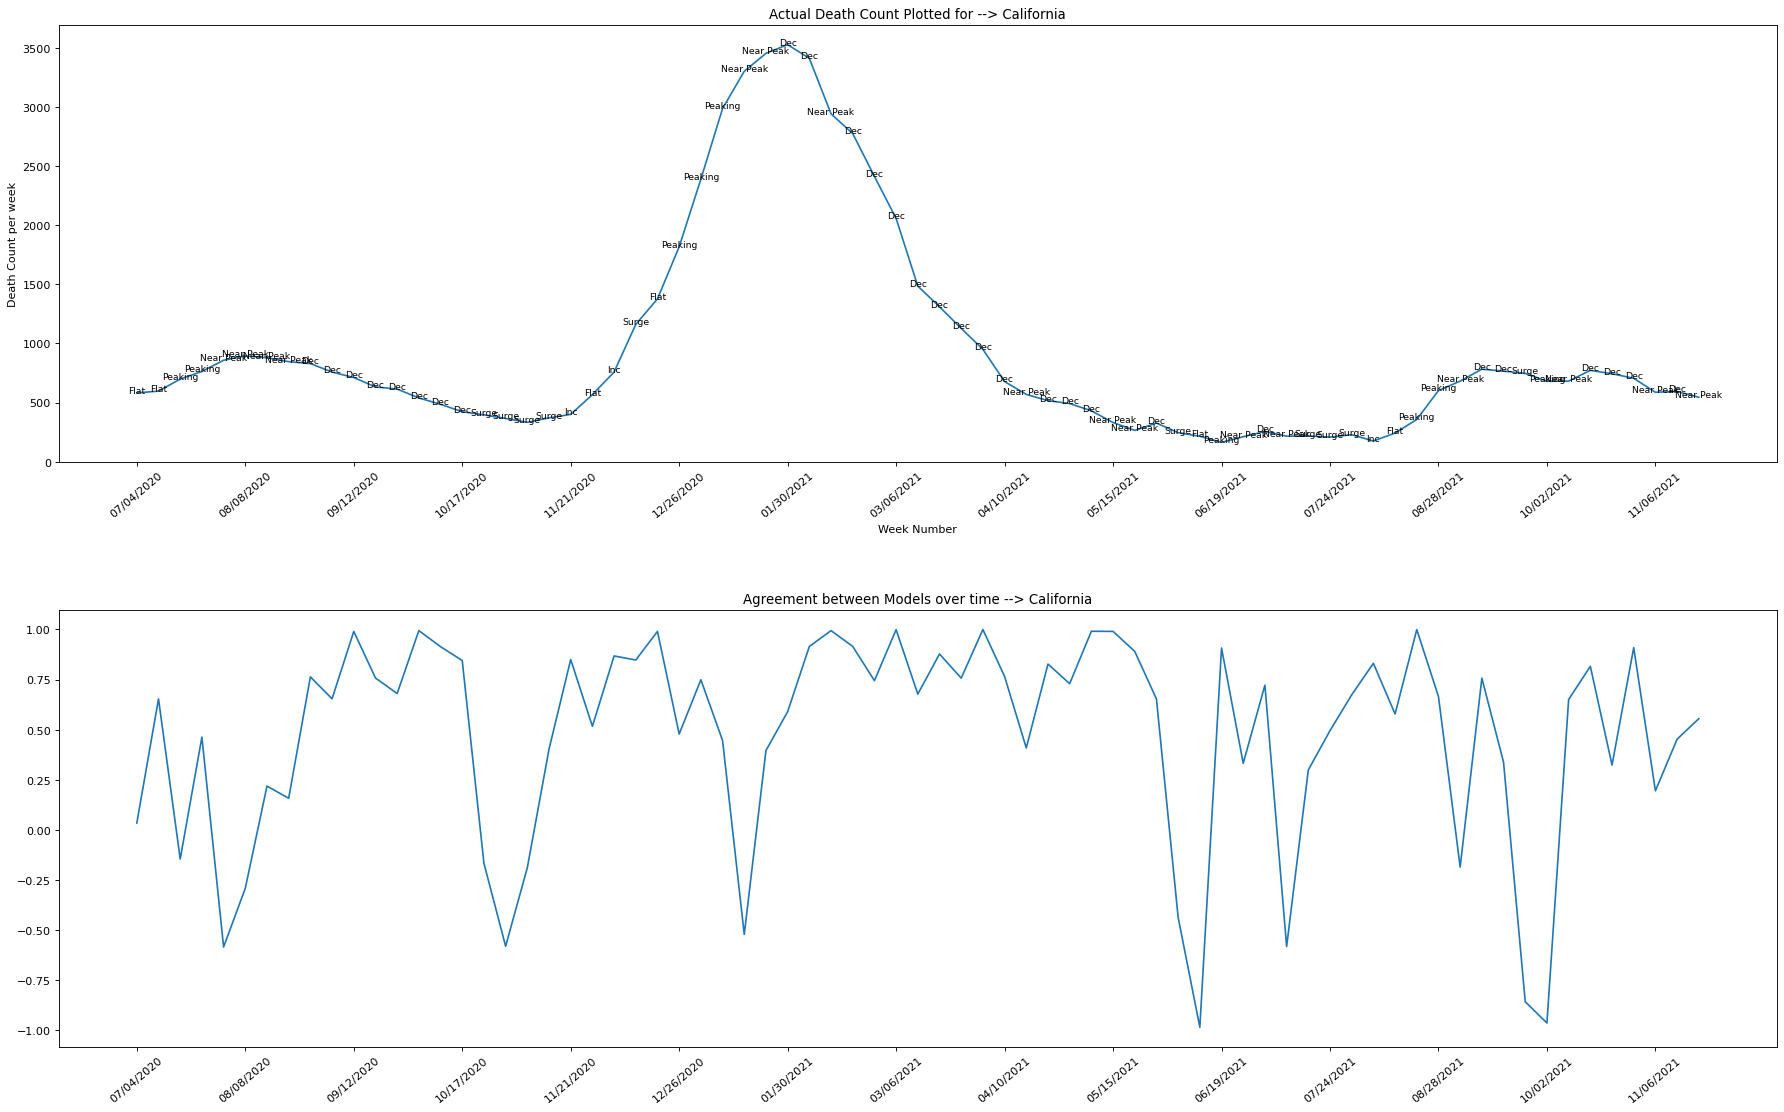

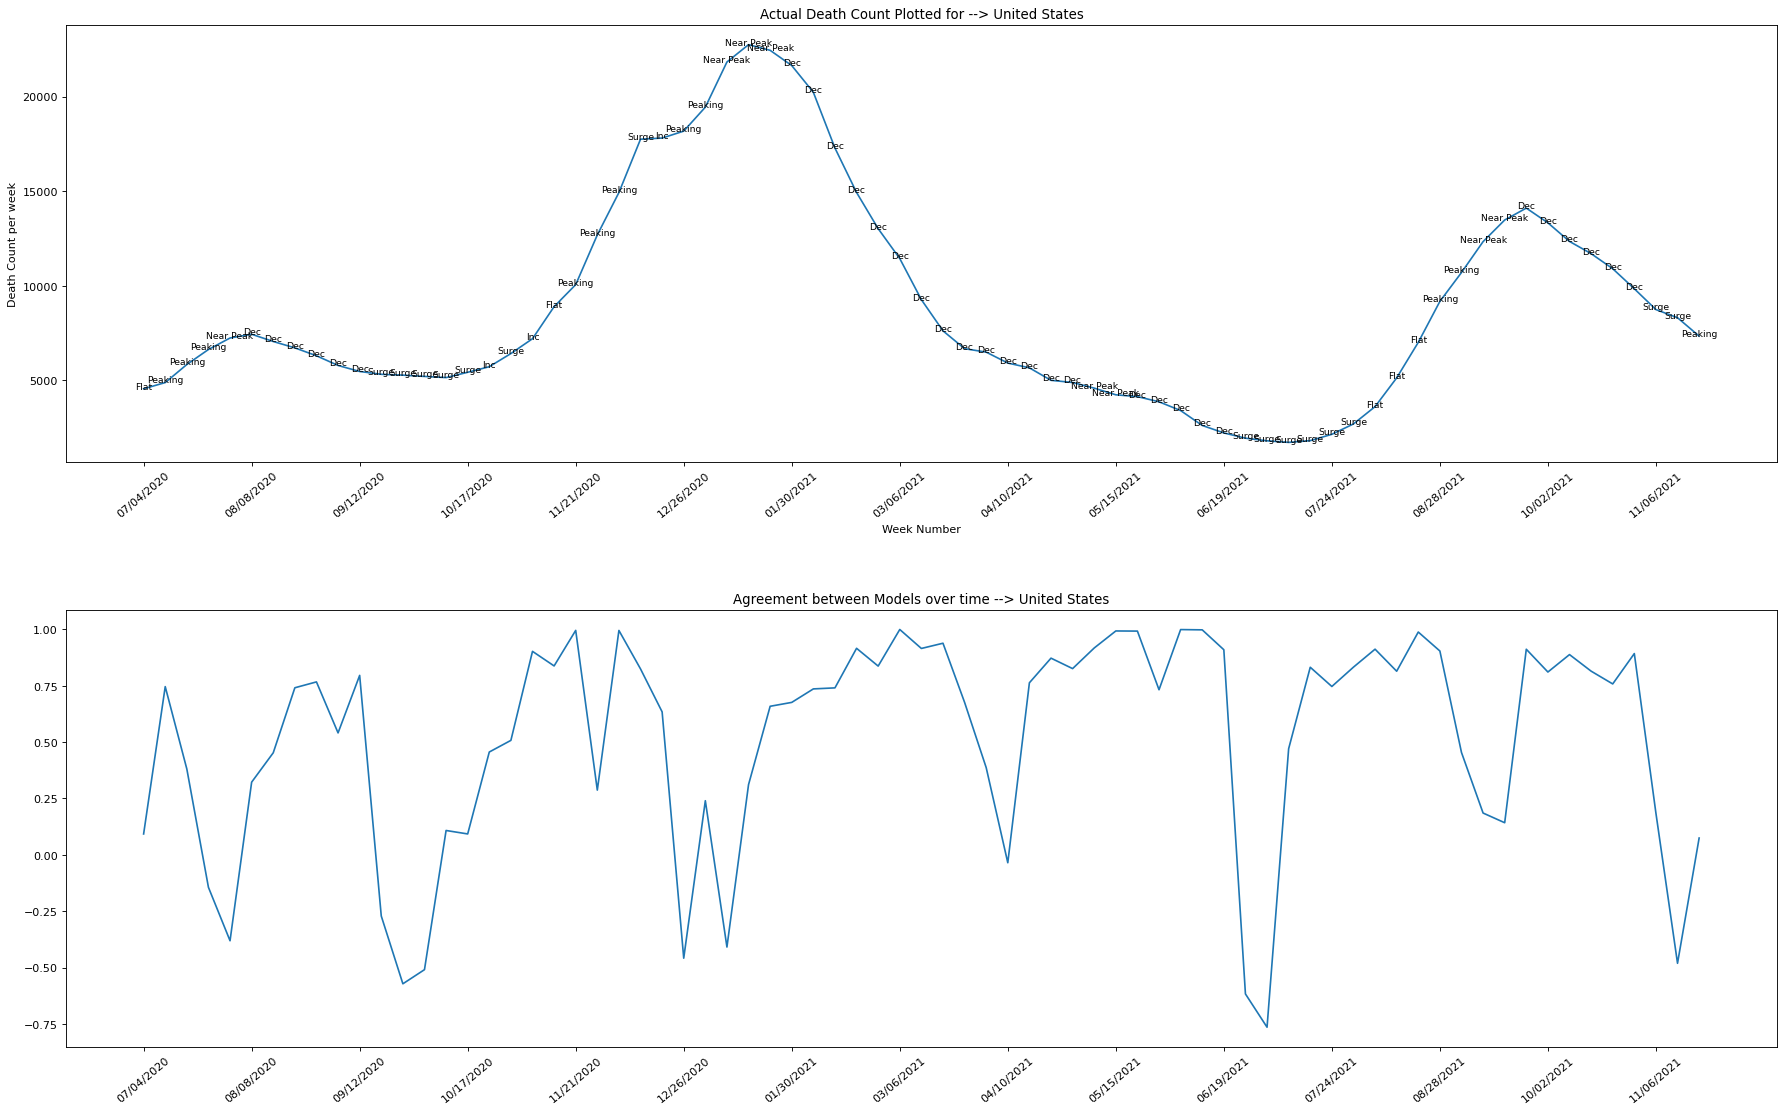

In [69]:
'''
Below code snipppte generate agrrement between models over time with propoer formatting

'''

State_Iteration_tmp = ['California','United States']

for state in State_Iteration_tmp:

    subset_data = plot_results_softmax[plot_results_softmax['State_x']==state].drop_duplicates(['Week Number','Label_Actual_x'])
    Actual_Case_cnt = (subset_data['Covid_case_count']/subset_data['Count_overall']).to_list()

    Predicted_label = subset_data['Predicted'].to_list()

    Actual_Label = subset_data['Label_Actual_x'].to_list()

    Week_nbr = subset_data['Week Number'].to_list()
    
    str_week_int = []
    str_week = []
    for i in range(0,len(Week_nbr),5):
        str_week_int.append(Week_nbr[i])
        str_week.append(date_formatting(Week_nbr[i]))
        
    print(len(Week_nbr))
    
#      = [str(w)+"A" for w in Week_nbr]

    fig, axs = plt.subplots(2,figsize=(25,16 ), dpi=80)

    #figure(figsize=(30,8 ), dpi=80)

    axs[0].plot(Week_nbr,Actual_Case_cnt)

    axs[0].set(xlabel="Week Number", ylabel="Death Count per week")

    axs[0].set_title("Actual Death Count Plotted for --> "+state)
    fig.tight_layout(pad=10.0)

    axs[0].set_xticks(str_week_int)
    axs[0].set_xticklabels(str_week,rotation=40)
    for val in list(zip(Week_nbr,Actual_Case_cnt,Actual_Label)):
        axs[0].text(val[0],val[1],val[2],size='small',horizontalalignment='center')


#     axs[1].plot(Week_nbr,Actual_Case_cnt)

#     axs[1].set(xlabel="Week", ylabel="Covid Case Count")

#     axs[1].set_title("Actual Case Volume Plotted with SoftMax Predicted Label --> "+state)

#     for val in list(zip(Week_nbr,Actual_Case_cnt,Predicted_label)):
#         axs[1].text(val[0],val[1],val[2])

        
    subset = MeanSimilarityModels[MeanSimilarityModels['State']==state]

    week_nbrs = list(subset['Week Number'].values)

    meanS_miliary = subset['Mean_Similarity'].values
    
    axs[1].plot(week_nbrs,meanS_miliary)
#     axs[1].set(xlabel="Week Number", ylabel="Agreement score between Models")

    axs[1].set_title("Agreement between Models over time --> "+state)
    
    str_week_int = []
    str_week = []
    for i in range(0,len(week_nbrs),5):
        str_week_int.append(week_nbrs[i])
        str_week.append(date_formatting(week_nbrs[i]))
    axs[1].set_xticks(str_week_int)
    axs[1].set_xticklabels(str_week,rotation=40)

    print(len(week_nbrs))
#     subset = MeanSimilarityModels_Actual[MeanSimilarityModels_Actual['State']==state]

#     week_nbrs = subset['Week Number'].values

#     meanS_miliary = subset['Mean_Similarity'].values
    
#     axs[1].plot(week_nbrs,meanS_miliary)
#     axs[1].set(xlabel="Week", ylabel="Mean Similarity of Models with Actual Week vector")

#     axs[1].set_title("Mean Similarity Value for Models with Actual --> "+state)


    plt.savefig('Shapelet_results/Data_toshare/Model Agreement Plot for Deaths '+state+'.png')



In [177]:
week_nbrs[0]

164

In [179]:
week_nbr = 164
t = 'Jan 22 2020'
format = '%b %d %Y'
now = datetime.strptime(t,format)
after = now + timedelta(days = week_nbr)
# return after.date().strftime("%m/%d/%Y")

In [181]:
date_formatting(int(week_nbrs[i]))

'11/06/2021'

In [176]:
    str_week_int = []
    str_week = []
    for i in range(0,len(week_nbrs),5):
        str_week_int.append(week_nbrs[i])
        try:
            str_week.append(date_formatting(week_nbrs[i]))
        except:
            print(week_nbrs[i])


164
199
234
269
304
339
374
409
444
479
514
549
584
619
654


<ipython-input-157-21c4c3d70460>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['two','six'])


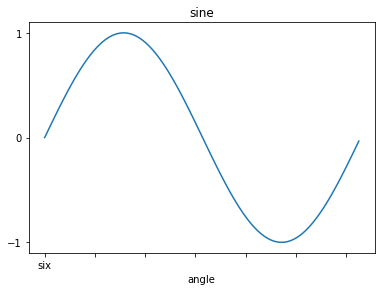

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import math
x = np.arange(0, math.pi*2, 0.05)
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
y = np.sin(x)
ax.plot(x, y)
ax.set_xlabel('angle')
ax.set_title('sine')
# ax.set_xticks([2,6])
ax.set_xticklabels(['two','six'])
ax.set_yticks([-1,0,1])
plt.show()

In [80]:

Master_df_actual_VS_Model_Agrrement_1 = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State'].isin(['California','United States'])]


In [81]:
Master_df_actual_VS_Model_Agrrement_2 = Master_df_actual_VS_Model_Agrrement_1.groupby(['State','Model Name']).agg(Mean_Similarity=("Cosine Similarty","mean"),Count_Similarity=("Cosine Similarty","count")).reset_index()


In [82]:
Master_df_actual_VS_Model_Agrrement_2


Master_df_actual_VS_Model_Agrrement_2["rank"] = Master_df_actual_VS_Model_Agrrement_2.groupby(["State"])["Mean_Similarity"].rank("dense", ascending=False)


In [83]:
Master_df_actual_VS_Model_Agrrement_2.sort_values(['rank']).to_csv("Model Ranking For US and California.csv")

In [84]:
Master_df_actual_VS_Model_Agrrement_2.sort_values(['rank'])

State                       Model Name  Mean_Similarity  \
25     California                  YYG_ParamSearch         0.860843   
31  United States               FH_CU_scenario_low         0.720191   
47  United States            FH_UCSD_NEU_DeepGLEAM         0.700289   
22     California               FH_UMass_MechBayes         0.734433   
21     California            FH_UCSD_NEU_DeepGLEAM         0.701266   
42  United States              FH_MOBS_GLEAM_COVID         0.691851   
19     California  FH_SteveMcConnell_CovidComplete         0.666280   
26  United States              FH_BPagano_RtDriven         0.691722   
3      California             FH_COVIDhub_ensemble         0.661947   
50  United States                   USC_SI_kJalpha         0.691445   
24     California                   USC_SI_kJalpha         0.646347   
30  United States                   FH_CU_nochange         0.688316   
48  United States               FH_UMass_MechBayes         0.682905   
16     California              FH_MOBS_GLEAM_COVID         0.642424   
13     California                   FH_Karlen_pypm         0.640861   
32  United States               FH_CU_scenario_mid         0.661404   
45  United States  FH_SteveMcConnell_CovidComplete         0.643503   
0      California              FH_BPagano_RtDriven         0.588195   
39  United States                   FH_Karlen_pypm         0.635469   
8      California         FH_CovidAnalytics_DELPHI         0.567008   
40  United States               FH_LANL_GrowthRate         0.586313   
11     California                  FH_JHUAPL_Bucky         0.559183   
49  United States        FH_epiforecasts_ensemble1         0.580684   
6      California               FH_CU_scenario_mid         0.543564   
4      California                   FH_CU_nochange         0.524230   
29  United States             FH_COVIDhub_ensemble         0.575931   
36  United States                  FH_GT_DeepCOVID         0.566178   
17     California                     FH_PSI_DRAFT         0.519489   
5      California               FH_CU_scenario_low         0.509038   
33  United States                     FH_CU_select         0.558481   
18     California            FH_RobertWalraven_ESG         0.508484   
37  United States                  FH_JHUAPL_Bucky         0.550162   
51  United States                  YYG_ParamSearch         0.520857   
10     California                  FH_GT_DeepCOVID         0.467343   
46  United States                   FH_TTU_squider         0.509812   
7      California                     FH_CU_select         0.465070   
34  United States         FH_CovidAnalytics_DELPHI         0.405095   
15     California             FH_MIT_CritData_GBCF         0.449338   
44  United States            FH_RobertWalraven_ESG         0.381571   
14     California               FH_LANL_GrowthRate         0.444222   
12     California               FH_JHU_IDD_CovidSP         0.393519   
43  United States                     FH_PSI_DRAFT         0.376076   
23     California        FH_epiforecasts_ensemble1         0.284768   
28  United States             FH_COVIDhub_baseline         0.359756   
20     California                   FH_TTU_squider         0.203032   
27  United States                     FH_CEID_Walk         0.359180   
41  United States             FH_MIT_CritData_GBCF         0.338921   
2      California             FH_COVIDhub_baseline         0.153351   
38  United States               FH_JHU_IDD_CovidSP         0.245075   
9      California                      FH_DDS_NBDS         0.144875   
35  United States                      FH_DDS_NBDS         0.033408   
1      California                     FH_CEID_Walk         0.058285   

    Count_Similarity  rank  
25                14   1.0  
31                56   1.0  
47                62   2.0  
22                73   2.0  
21                62   3.0  
42                72   3.0  
19                65   4.0  
26              

In [356]:
# 25	California	YYG_ParamSearch	0.860843	14	1.0
# 31	United States	FH_CU_scenario_low	0.720191	56	1.0
# 47	United States	FH_UCSD_NEU_DeepGLEAM	0.700289	62	2.0
# 22	California	FH_UMass_MechBayes	0.734433	73	2.0
# 21	California	FH_UCSD_NEU_DeepGLEAM	0.701266	62	3.0
# 42	United States	FH_MOBS_GLEAM_COVID	0.691851	72	3.0

In [358]:
# Master_df_actual_VS_Model_Agrrement_2.sort_values(['State','rank'])

length of x1 14
length of x11 73
length of x1 56
length of x11 62


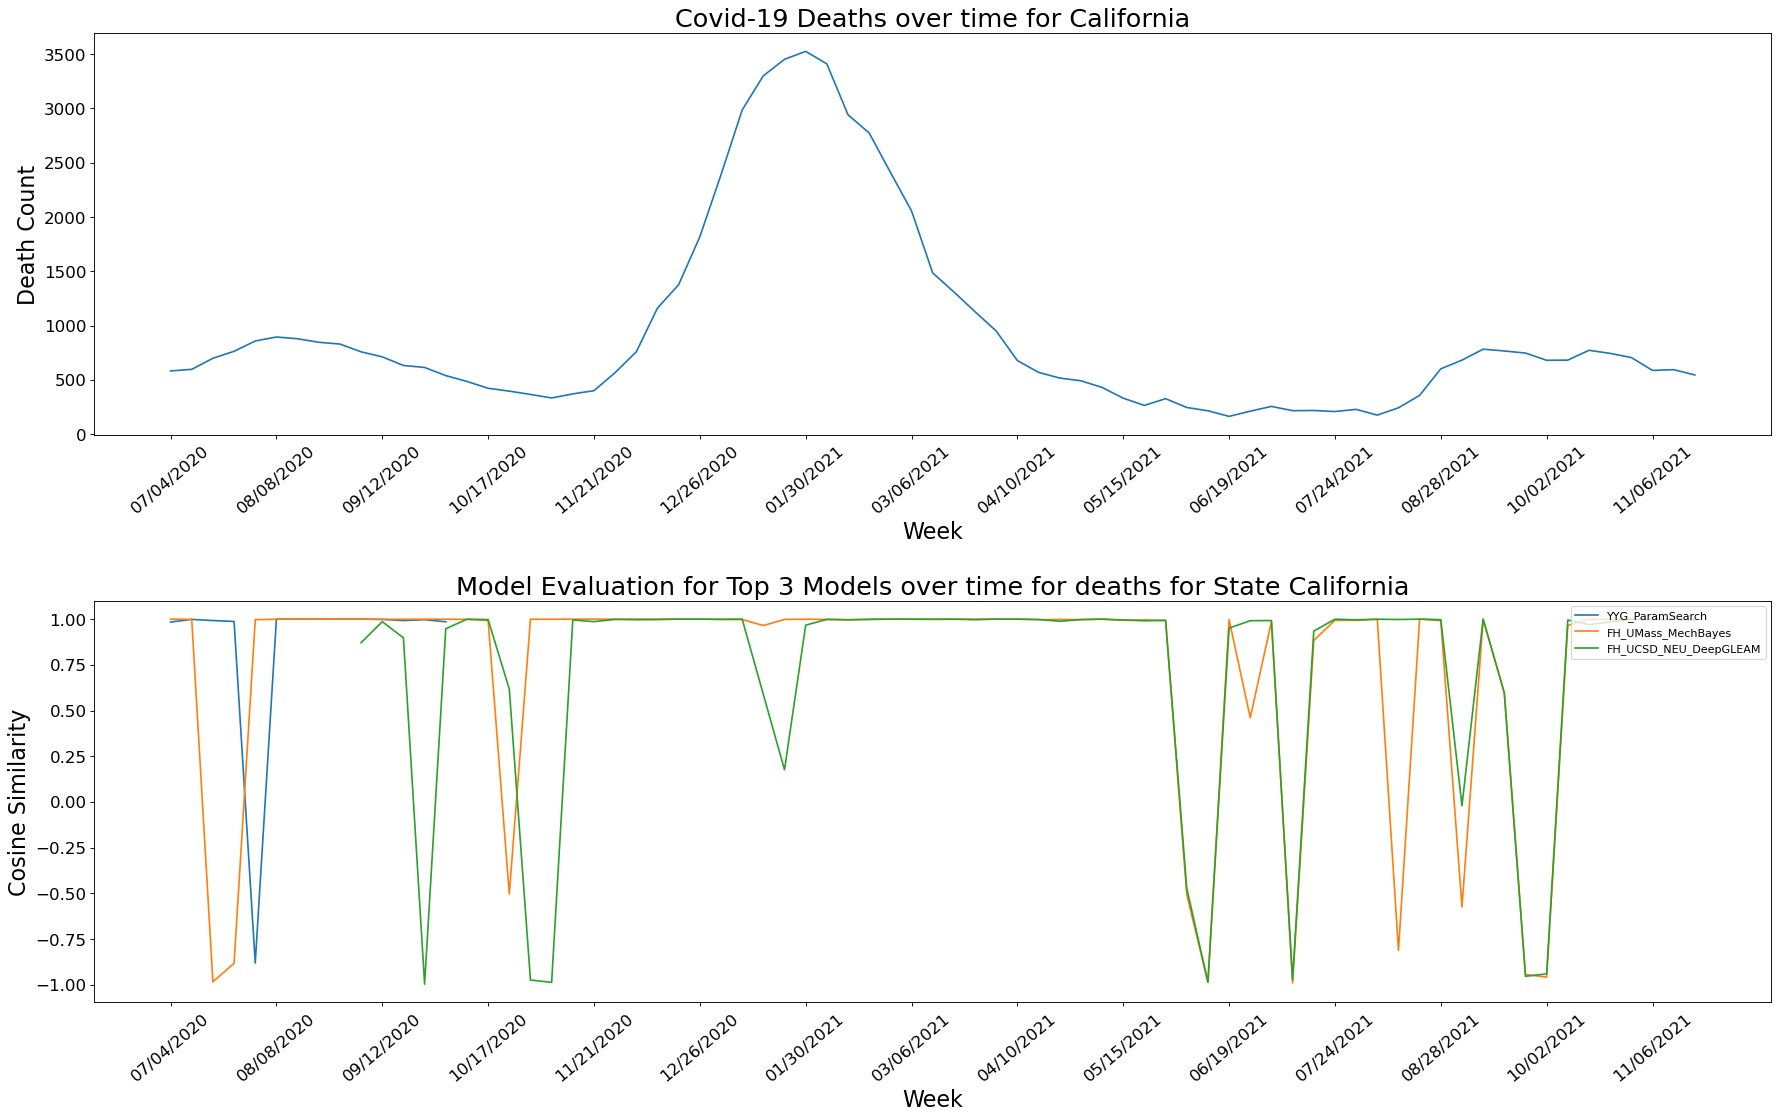

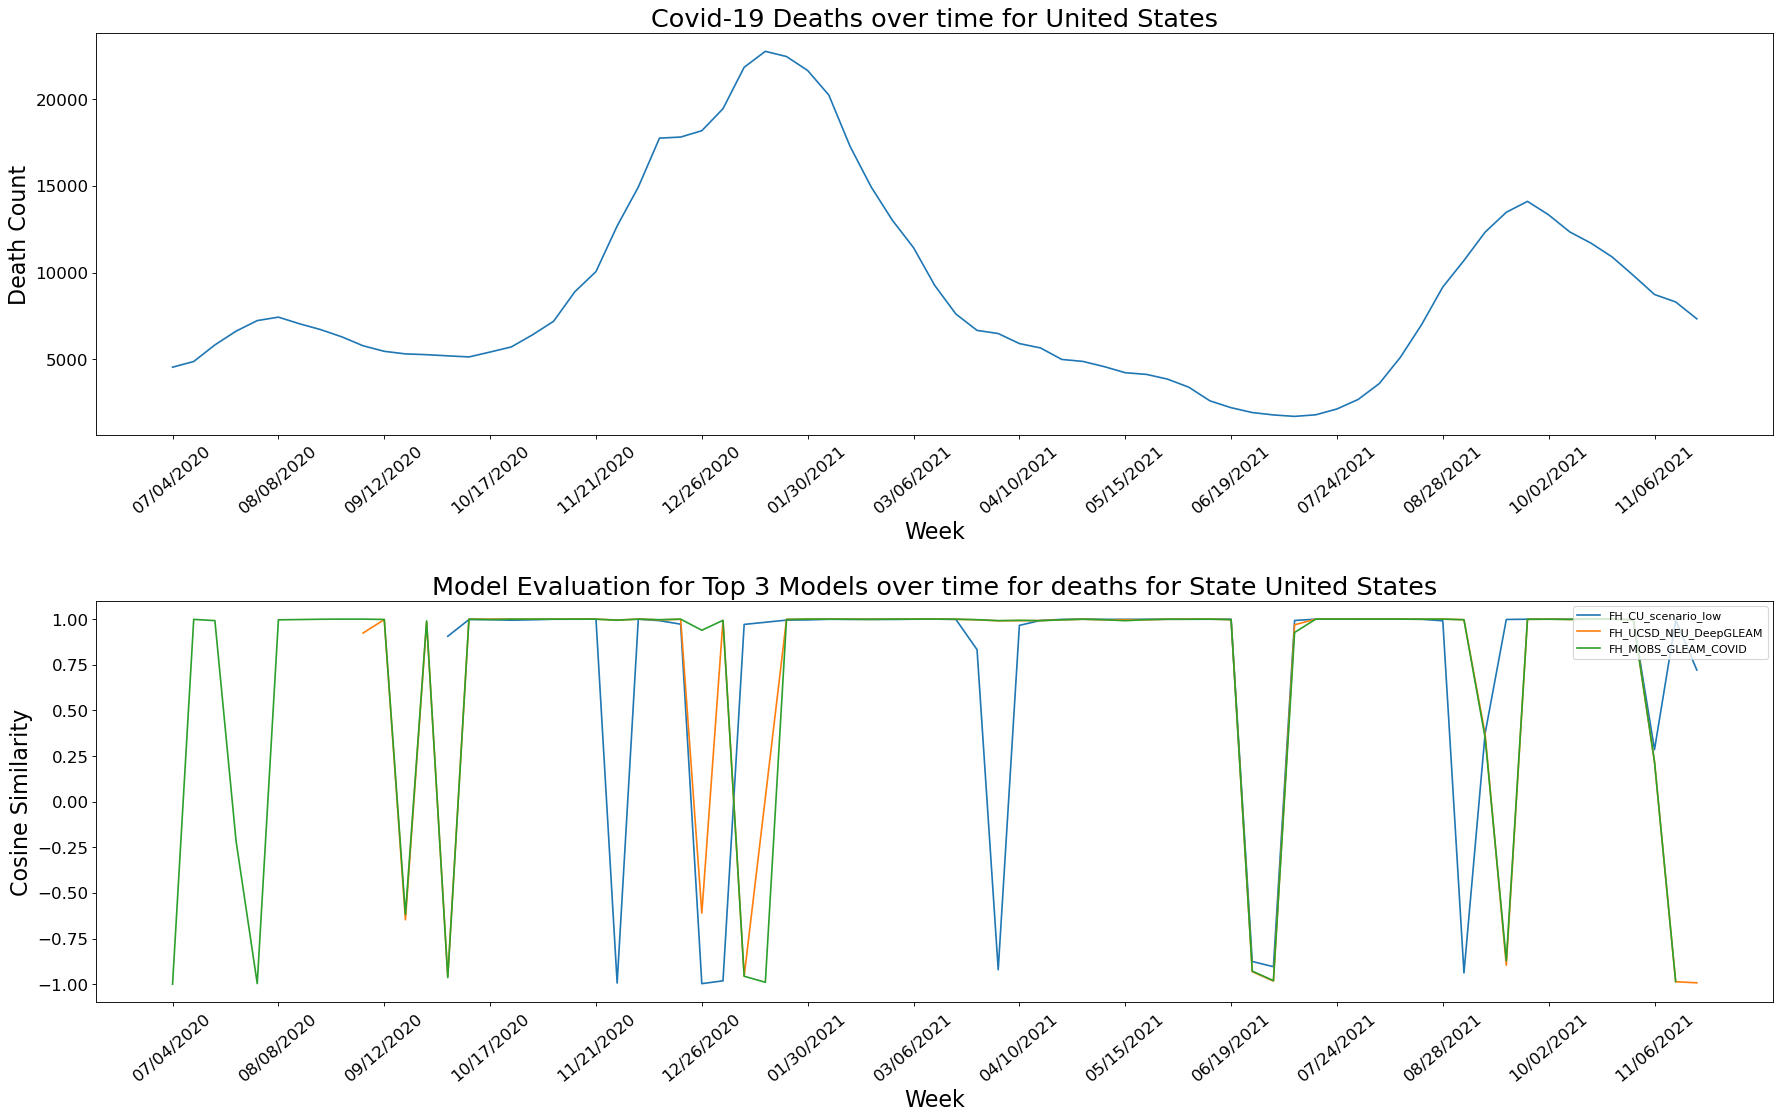

In [70]:
# state_lst = list(State_week_avg_ensemble.keys())

for state in state_lst:
    model_list = {"California":['YYG_ParamSearch','FH_UMass_MechBayes','FH_UCSD_NEU_DeepGLEAM'],
                  "United States":['FH_CU_scenario_low','FH_UCSD_NEU_DeepGLEAM','FH_MOBS_GLEAM_COVID']}
#     if state not in ['California','United States']:
#         continue
    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    fig, axs = plt.subplots(2,figsize=(25,16 ), dpi=80)

    fig.tight_layout(pad=13.0)

    subset_data = plot_results_softmax[plot_results_softmax['State_x']==state].drop_duplicates(['Week Number','Label_Actual_x'])
    Actual_Case_cnt = (subset_data['Covid_case_count']/subset_data['Count_overall']).to_list()

    Predicted_label = subset_data['Predicted'].to_list()

    Actual_Label = subset_data['Label_Actual_x'].to_list()
    
    
    Week_nbr = subset_data['Week Number'].to_list()
    Week_nbr2 = Week_nbr[:]
    str_week_int = []
    str_week = []
    for i in range(0,len(Week_nbr),5):
        str_week_int.append(Week_nbr[i])
        str_week.append(date_formatting(Week_nbr[i]))

#         print(len(Week_nbr))

    axs[0].plot(Week_nbr,Actual_Case_cnt)
    axs[0].set_xlabel('Week', fontsize = 20)
    axs[0].set_ylabel('Death Count', fontsize = 20)
    
#     axs[0].set(xlabel="Week", ylabel="Covid Case Count")

    axs[0].set_title("Covid-19 Deaths over time for "+state,fontsize=23)
    axs[0].set_xticks(str_week_int)
    axs[0].set_xticklabels(str_week,rotation=40,fontsize=15)
    axs[0].yaxis.set_tick_params(labelsize=15)
    
    lgh = -999
    wek = None

    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    subset_1 = subset[subset['Model Name']==model_list[state][0]]
    
    x1 = subset_1['Week Number'].values
    
    y1 = subset_1['Cosine Similarty'].values
    
    if len(x1)>lgh:
        print("length of x1",len(x1))
        lgh = x1
        wek = x1
#     print
    vectors = list(zip(x1,y1))

    vector_sorted = sorted(vectors,key = lambda x : x[0]) 

    x = [w[0] for w in vector_sorted ]
    y = [w[1] for w in vector_sorted ]
    Week_nbr = x

    usc = axs[1].plot(x,y,label=model_list[state][0])


    axs[1].set_xlabel('Week', fontsize = 20)
    axs[1].set_ylabel('Cosine Similarity', fontsize = 20)
    
    
#     usc = axs[2].set(xlabel="Week", ylabel="Cosine Similarity",label = "USC Shapelet Ensemble")

    axs[1].set_title("Model Evaluation for Top 3 Models over time for deaths for State {}".format(state),fontsize=23)
#         plt.show()

    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    subset_1 = subset[subset['Model Name']==model_list[state][1]]
    
    x11 = list(subset_1['Week Number'].values)
    print("length of x11",len(x11))
    y11 = subset_1['Cosine Similarty'].values
    if len(x11)>len(lgh):
        lgh = x11
        wek = x11

    
    vectors = list(zip(x11,y11))

    vector_sorted = sorted(vectors,key = lambda x : x[0]) 

    x = [w[0] for w in vector_sorted ]
    y = [w[1] for w in vector_sorted ]
    Week_nbr = x

    ensemble  = axs[1].plot(x,y,label=model_list[state][1])
    
    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    subset_1 = subset[subset['Model Name']==model_list[state][2]]
    
    x12 = list(subset_1['Week Number'].values)
    
    y12 = subset_1['Cosine Similarty'].values
    if len(x12)>len(lgh):
        lgh = x12
        wek = x12
    
    
    vectors = list(zip(x12,y12))

    vector_sorted = sorted(vectors,key = lambda x : x[0]) 

    x = [w[0] for w in vector_sorted ]
    y = [w[1] for w in vector_sorted ]
    Week_nbr = x

    ensemble2  = axs[1].plot(x,y,label=model_list[state][2])

#     axs[2].legend((usc,ensemble),('Perfis COPEX','Media'), loc = 'best')
    leg1 = axs[1].legend(loc='upper right')
    
    str_week_int = []
    str_week = []
    for i in range(0,len(Week_nbr2),5):
        str_week_int.append(Week_nbr2[i])
        str_week.append(date_formatting(Week_nbr2[i]))
    axs[1].set_xticks(str_week_int)
    axs[1].set_xticklabels(str_week,rotation=40,fontsize=15)
    axs[1].yaxis.set_tick_params(labelsize=15)


    plt.savefig('Shapelet_results/Data_toshare/Model_Evaluation Plot for Top3 Models Deaths '+state+'.png')


In [368]:
len(x11)

63

In [377]:
    subset = Master_df_actual_VS_Model_Agrrement[Master_df_actual_VS_Model_Agrrement['State']==state]
    subset_1 = subset[subset['Model Name']==model_list[state][0]]


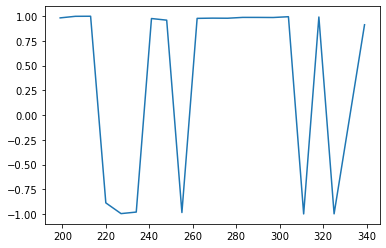

In [384]:
x1 = subset_1['Week Number'].values

y1 = subset_1['Cosine Similarty'].values

# if len(x1)>lgh:
#     print("length of x1",len(x1))
#     lgh = x1
#     wek = x1
#     print
vectors = list(zip(x1,y1))

vector_sorted = sorted(vectors,key = lambda x : x[0]) 

x = [w[0] for w in vector_sorted ]
y = [w[1] for w in vector_sorted ]
Week_nbr = x

usc = plt.plot(x[:20],y[:20],label=model_list[state][0])


In [86]:

best_model_label_df = Master_df_actual_VS_Model_Agrrement.groupby(['True Label','Model Name']).agg(Mean_Score=("Cosine Similarty","mean")).reset_index()


In [87]:
best_model_label_df["rank"] = best_model_label_df.groupby(['True Label'])["Mean_Score"].rank("dense", ascending=False)


In [88]:
best_model_label_df.sort_values(['True Label','rank']).to_csv("Best_model_shapelet_6.csv")

In [89]:
Master_df_actual_VS_Model_Agrrement['True Label'].unique()

array(['Peaking', 'Surge', 'Dec', 'Inc', 'Flat', 'Near Peak'],
      dtype=object)

In [90]:

Master_df_actual_VS_Model_Agrrement['newlable'] = np.where(Master_df_actual_VS_Model_Agrrement['True Label'].isin(['Flat', 'Inc', 'Dec']),"Continued Trend","Others")


In [91]:
Master_df_actual_VS_Model_Agrrement


best_model_label_df = Master_df_actual_VS_Model_Agrrement.groupby(['newlable','Model Name']).agg(Mean_Score=("Cosine Similarty","mean")).reset_index()

best_model_label_df["rank"] = best_model_label_df.groupby(['newlable'])["Mean_Score"].rank("dense", ascending=False)


In [92]:
best_model_label_df.sort_values(['newlable','rank']).to_csv("Best_model_shapelet_continued_trendVS_others_Deaths.csv")